# Welcome to AUTO-ONTO 

Your one-stop fully automated solution for generating deep and versatile ontologies.

In order to run the model for the first time, please un-comment the commented code below as they are required dependencies.

Due to confidentiality reasons, the code for reading the dataset and EDA has been revoked.

##### Sample outputs and visualization from the model has been provided in the outputs directory

In [1]:
## Below are the dependencies, please run them if running for the first time

#import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#!pip install pandas --user
#!pip install wordcloud
#!pip uninstall scikit-learn --y
#!conda install scikit-learn==0.22.0 --y

# Below are the imports
import nltk
import re
import pandas as pd
import gensim
from nltk.stem import WordNetLemmatizer
from functools import lru_cache
import html
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from collections import Counter
from gensim.models import FastText
from gensim.models.word2vec import LineSentence
from nltk.stem import PorterStemmer
import datetime as dt
from minio import Minio
from functools import partial
import warnings
import json
import ast
import numpy as np
import math
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import os
import networkx as nx
import shutil

### Imports for EDA
import matplotlib.pyplot as plt
import string
import math
import spacy
import seaborn as sns
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

ps = PorterStemmer()
tqdm.pandas()

/opt/conda/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1. Getting the data and cleaning

### Data cleaning - 

1) Dropping duplicate data

2) Handling Missing titles

3) Picking only titles and abstract - as they have the most relevant info

4) Cleaning text and titles - Removing stopwords, lemmatizing, normalizing spaces, removing punctuations

In [3]:
df_en['pre_text'] = df_en['title'] + ' ' + df_en['text'] #Combining title and text

In [4]:
#### Pre-processing Functions

wnl = WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(wnl.lemmatize)

def lemma_words(word):
    return lemmatize(word)


# Check if a word is a Stopword

stopwords = nltk.corpus.stopwords.words('english')


domain_stopwords = ['first','second','etc','kind','wherein','comprises', 'discloses', 'provides','using','thereof', 'system','without','method', 'systems','methods', 'p','herein','including','dupli','described','provided','de','example','dtype','apparatus','apparatuses','c','may','present','invention']

for ds in domain_stopwords:
    stopwords.append(ds)
    
# Check if a word is a Stopword
# Stopword is a word that is commonly present in most of the documents and does not affect the model

def isNotStopWord(word):
    return word not in stopwords


def preprocessingText(text):
    
    tokens = []
    temp = ""
    
    if len(text) > 0:
        
        
        text = re.sub("(\d+)",'',text) #Removing digits
        text = re.sub(r"[^A-Za-z0-9]+",' ',text) #Replace special characters with space
        sentences = nltk.sent_tokenize(text)
        

        for sentence in sentences:
            
            words = nltk.word_tokenize(sentence)
            
            #Converting to LowerCase
            words = map(str.lower, words)
            words = map(lemma_words,words)
            words = filter(lambda x: isNotStopWord(x), words)
            
            # Removing punctuations except '<.>/<?>/<!>'
            punctuations = '"#$%&\'()*+,-/_:;<=>@\\^`{|}~.!?'
            words = map(lambda x: x.translate(str.maketrans('', '', punctuations)), words)
            
            # Remove empty strings
            words = filter(lambda x: len(x) > 2, words)
            
            tokens = tokens + list(words)
            
            
        temp = ' '.join(word for word in tokens)
        
        temp = ' '.join(word for word in temp.split())
        
    return temp

## 2. Exploratory Data Analysis 



## Round - 1 : Before data cleaning

## Round - 2:  After data cleaning

1st round is done with minimal cleaning (removing stopwords, punctuations and invalid characters only)

- **Wordclouds**; For understanding frequency of words in the corpus and determining domain specific stopwords


- **N-gram analysis**; To analyze the pattern of phrases appearing in data


- **Statistical text analysis**; Box plots to identify the distribution of document lengths and identify the outliers. BoxPlots were also used to understand the distrubution of stopwords in the dataset

In [5]:
#### Minimal data cleaning for 1st round of EDA

df_en['cleaned_text'] = df_en['text'].apply(str.lower)
df_en['cleaned_text'] = df_en['cleaned_text'].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", " ", x))
df_en['cleaned_text'] = df_en['cleaned_text'].apply(lambda x: ' '.join(word for word in x.split()))

df_en['cleaned_title'] = df_en['title'].apply(str.lower)
df_en['cleaned_title'] = df_en['cleaned_title'].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", " ", x))
df_en['cleaned_title'] = df_en['cleaned_title'].apply(lambda x: ' '.join(word for word in x.split()))

#For N-gram analysis

txt_cleaned = df_en['cleaned_text'].squeeze()
title_cleaned = df_en['cleaned_title'].squeeze()

In [6]:
#Checking Emply columns

patents.isnull().sum()

abstract_localized                   0
application_kind                     0
application_number                   0
application_number_formatted       327
art_unit                        239488
assignee                             6
assignee_harmonized              22124
child                           258314
citation                        120046
claims_localized                120050
country_code                         0
cpc                              34770
entity_status                   244559
examiner                        214479
family_id                            0
fi                              285465
filing_date                          0
fterm                           286583
grant_date                      185100
inventor                         22551
inventor_harmonized              22902
ipc                                241
kind_code                            0
parent                          236485
pct_number                      224534
priority_claim           

### Wordcloud analysis

In [7]:
#Define the word cloud functions

def plot_wordcloud(text, mask=None, max_words=300, max_font_size=100, figure_size=(10,10), 
                   title = None, title_size=20, image_color=False):
    stopwords = set(STOPWORDS)
    #define additional stop words that are not contained in the dictionary
    more_stopwords = {'kind','system','without','method', 'systems','methods', 'p','herein','including','dupli','described','provided','de','example','dtype','apparatus','apparatuses','c','may','present','invention'}
    #more_stopwords = {}
    stopwords = stopwords.union(more_stopwords)
    #Generate the word cloud
    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    #set the plot parameters
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    


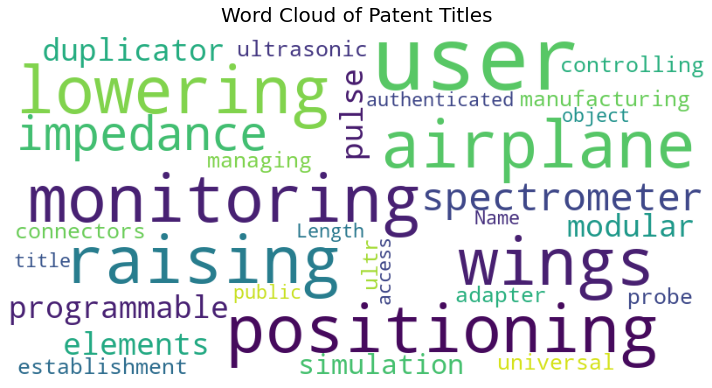

In [8]:
plot_wordcloud(df_en['title'], title="Word Cloud of Patent Titles")
#plot_wordcloud(df_en['cleaned_title'], title="Word Cloud of Patent Titles")
# system,without,method - redundant (Remove after lemmatization - plurals are there too)

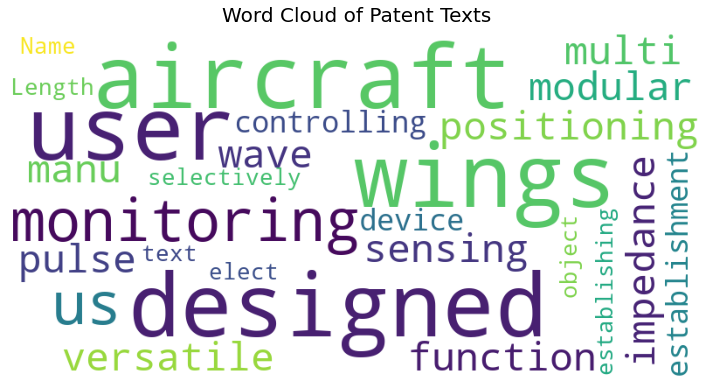

In [9]:
plot_wordcloud(df_en['text'], title="Word Cloud of Patent Texts")
#plot_wordcloud(df_en['cleaned_text'], title="Word Cloud of Patent Texts")
#p,(all the above stopwords),herein,including,dupli,described,provided,de,example

## N-Gram analysis

In [10]:
# Define the functions used for N-gram analysis

def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

#Function to construct side by side comparison plots
def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="royalblue")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="royalblue")

    ax[0].set_xlabel('Word count', size=14)
    ax[0].set_ylabel('Words', size=14)
    ax[0].set_title('Top words in sincere questions', size=18)

    ax[1].set_xlabel('Word count', size=14)
    ax[1].set_ylabel('Words', size=14)
    ax[1].set_title('Top words in insincere questions', size=18)

    fig.subplots_adjust(wspace=space)
    
    plt.show()

### Exploring Titles

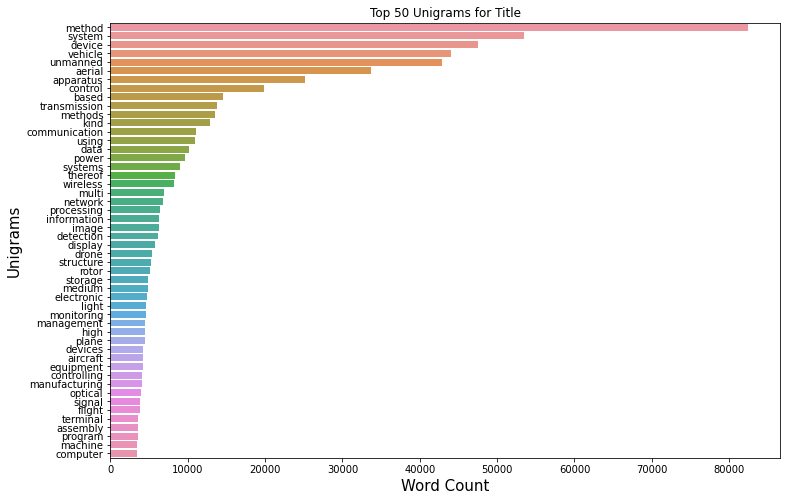

In [11]:
title_unigram = generate_ngrams(title_cleaned, 1, 50)
plt.figure(figsize=(12,8))
sns.barplot(x = title_unigram["wordcount"], y = title_unigram["word"])
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Unigrams", fontsize=15)
plt.title("Top 50 Unigrams for Title")
plt.show()

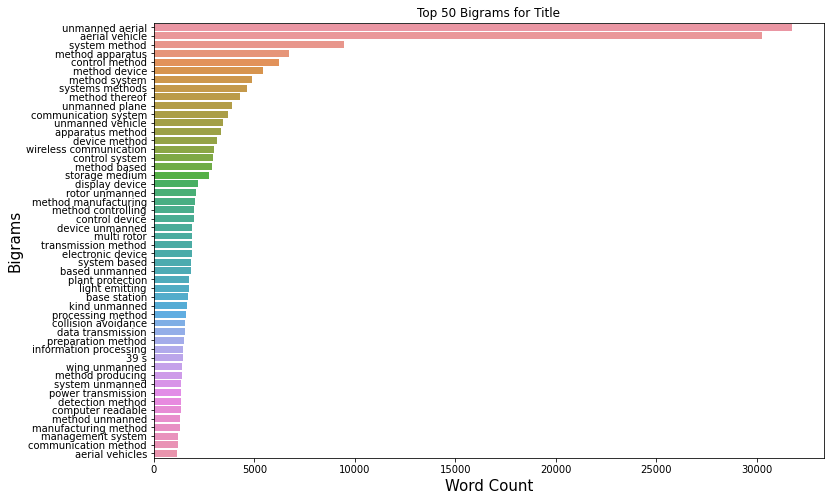

In [12]:
title_bigram = generate_ngrams(title_cleaned, 2,50)
plt.figure(figsize=(12,8))
sns.barplot(x = title_bigram["wordcount"], y = title_bigram["word"])
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Bigrams", fontsize=15)
plt.title("Top 50 Bigrams for Title")
plt.show()

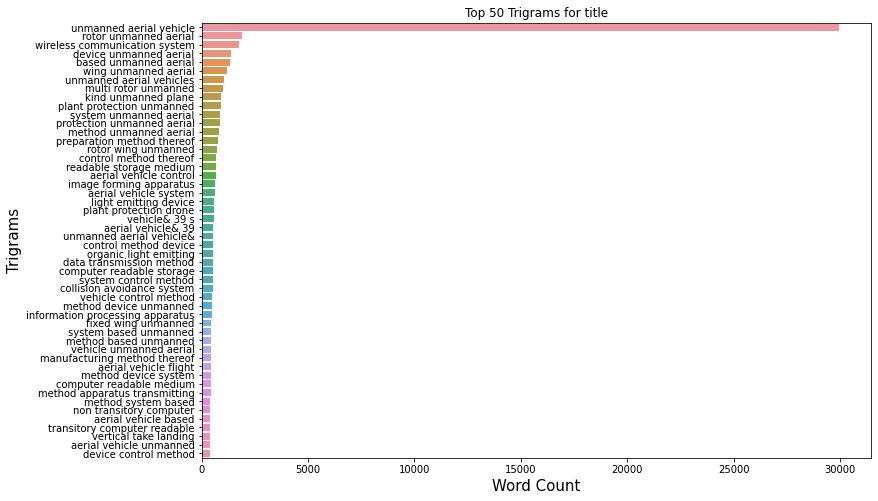

In [13]:
title_trigram = generate_ngrams(title_cleaned, 3, 50)
plt.figure(figsize=(12,8))
sns.barplot( x = title_trigram["wordcount"], y = title_trigram["word"])
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Trigrams", fontsize=15)
plt.title("Top 50 Trigrams for title")
plt.show()

## Exploring Text

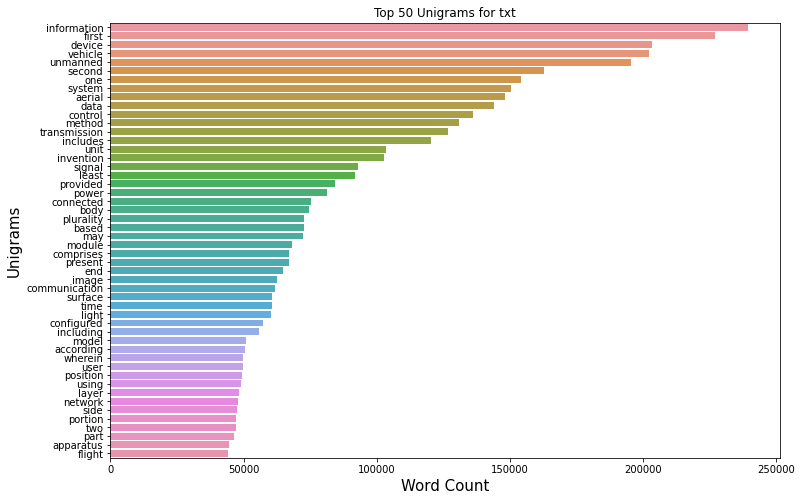

In [14]:
txt_unigram = generate_ngrams(txt_cleaned, 1, 50)
plt.figure(figsize=(12,8))
sns.barplot(x=txt_unigram["wordcount"],y=txt_unigram["word"])
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Unigrams", fontsize=15)
plt.title("Top 50 Unigrams for txt")
plt.show()

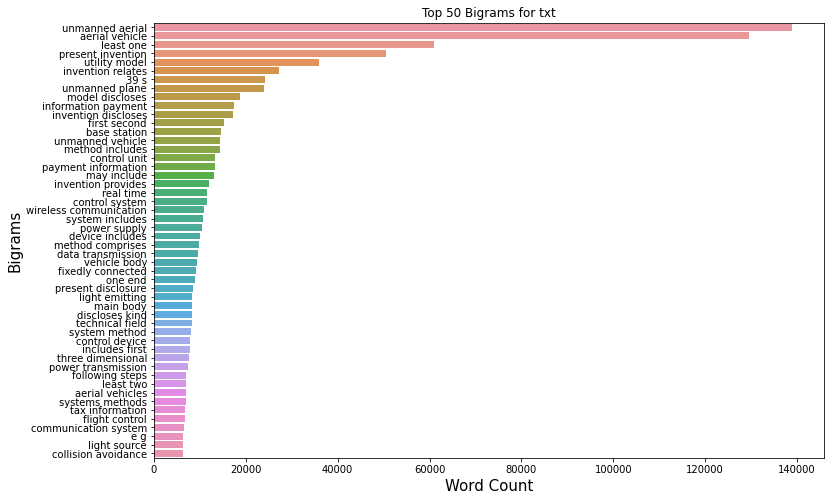

In [15]:
txt_unigram = generate_ngrams(txt_cleaned, 2, 50)
plt.figure(figsize=(12,8))
sns.barplot(x=txt_unigram["wordcount"],y=txt_unigram["word"])
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Bigrams", fontsize=15)
plt.title("Top 50 Bigrams for txt")
plt.show()

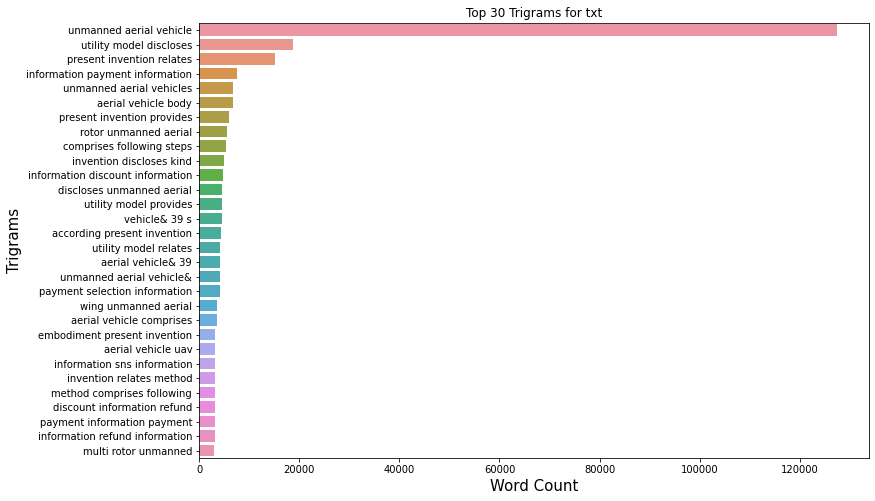

In [16]:
txt_unigram = generate_ngrams(txt_cleaned, 3, 30)
plt.figure(figsize=(12,8))
sns.barplot(x=txt_unigram["wordcount"],y=txt_unigram["word"])
plt.xlabel("Word Count", fontsize=15)
plt.ylabel("Trigrams", fontsize=15)
plt.title("Top 30 Trigrams for txt")
plt.show()

 Remove domain specific stopwords in round - 2

## Statistical Text Analysis

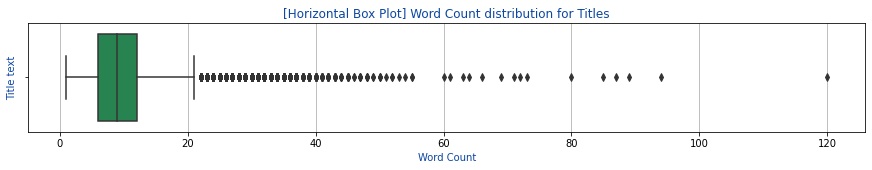

In [17]:
# Word Count distribution for Titles

txt_clean = pd.DataFrame(np.array(title_cleaned).reshape(-1))
txt_clean.columns = ["ques_body"]
txt_clean = txt_clean.squeeze()

# Number of words in the question_body
txt_clean["word_count"] = txt_clean.apply(lambda x: len(str(x).split()))
fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="word_count", data= txt_clean, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Title text', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Word Count distribution for Titles', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

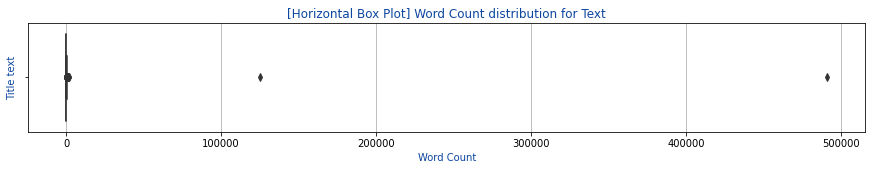

In [18]:
# Word Count distribution for Text

txt_clean = pd.DataFrame(np.array(txt_cleaned).reshape(-1))
txt_clean.columns = ["ques_body"]
txt_clean = txt_clean.squeeze()

# Number of words in the question_body
txt_clean["word_count"] = txt_clean.apply(lambda x: len(str(x).split()))
fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="word_count", data= txt_clean, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Title text', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Word Count distribution for Text', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()


 Remove the outliers in Round 2

- Stopwords frequency in the document

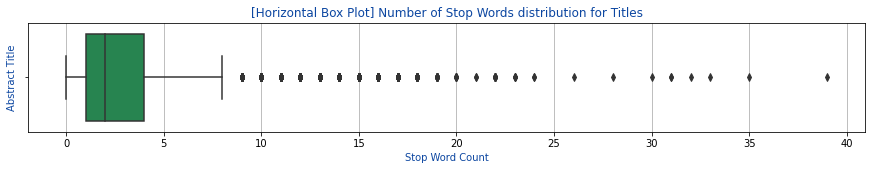

In [19]:
stopwords = set(STOPWORDS) #define additional stop words that are not contained in the dictionary
more_stopwords = {'system','without','method', 'systems','methods', 'p','herein','including','dupli','described','provided','de','example','dtype','apparatus','apparatuses','c','may','present','invention'}
#more_stopwords = {}
stopwords = stopwords.union(more_stopwords)
title_cleaned["stop_words_count"] = title_cleaned.apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="stop_words_count", data=title_cleaned, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Stop Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Abstract Title', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Number of Stop Words distribution for Titles', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

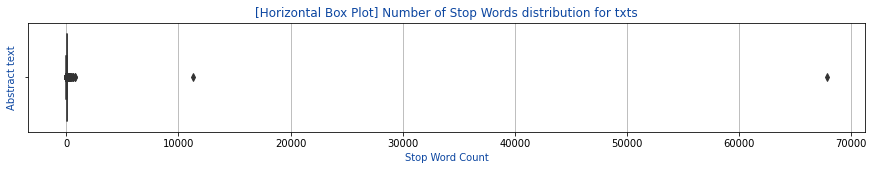

In [20]:
# Number of stopwords in question_body
stopwords = set(STOPWORDS)
#define additional stop words that are not contained in the dictionary
more_stopwords = {'system','without','method', 'systems','methods', 'p','herein','including','dupli','described','provided','de','example','dtype','apparatus','apparatuses','c','may','present','invention'}
#more_stopwords = {}
stopwords = stopwords.union(more_stopwords)
txt_cleaned["stop_words_count"] = txt_cleaned.apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="stop_words_count", data=txt_cleaned, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Stop Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Abstract text', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Number of Stop Words distribution for txts', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

## ROUND - 2 : Perform data cleaning and run EDA again

- Removing domain specific stopwords,using lemmatization and handling outliers

In [21]:
df_en = df_en.drop([df_en.index[70962]]) #3 million words
df_en = df_en.drop([df_en.index[6552]]) #800k words (avg is around 50k tokens)
df_en = df_en.drop([df_en.index[7658]]) 
df_en = df_en.drop([df_en.index[12861]])

#Remember to reset the indexes
df_en.reset_index(drop=True,inplace=True)
try:
    df_en.drop(columns=['index'],inplace=True)
except:
    pass

In [22]:
# Cleaning
print('Started Cleaning Title...')
df_en['cleaned_title'] = df_en['title'].progress_apply(lambda x : preprocessingText(html.unescape(x)))
print('Done Cleaning Title...\n')
print('Started Cleaning Text...')
df_en['cleaned_text'] = df_en['text'].progress_apply(lambda x : preprocessingText(html.unescape(x)))
print('Done Cleaning Text...')

Started Cleaning Title...


  0%|          | 0/239244 [00:00<?, ?it/s]

Done Cleaning Title...

Started Cleaning Text...


  0%|          | 0/239244 [00:00<?, ?it/s]

Done Cleaning Text...


## 3. Extracting Keywords and Keyphrases

1) Approach 1 - Use YAKE and get top-n keywords for individual documents, pick the top N keywords for final list using frequency; replace phrases (unmanned_aerial) in the original text - TIME CONSUMING, NOT FEASIBLE

2) Approach 2 - Train doc2vec on full data, use spherical K-means to cluster documents, Extract relevant keywords from each cluster;- (REDUNDANT)

3) Approach 3 - Remove domain specific stopwords, use NP chunking to get keyphrases and use TF-IDF for keywords (FAST,FEASIBLE) 

### For keywords : TF-IDF

In [23]:
df_en['post_text'] = df_en['pre_text'].progress_apply(lambda x: preprocessingText(x))

docs=df_en['post_text'].tolist()

#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv=CountVectorizer(max_df=0.85,stop_words=stopwords,max_features=20000)
word_count_vector=cv.fit_transform(docs)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names()

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """ output - list containing topn keywords (using TF-IDF)"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    #score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, _ in sorted_items:
        
        #keep track of feature name and its corresponding score
        #score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    
    return feature_vals

def get_unigrams(doc):
    
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords = extract_topn_from_vector(feature_names,sorted_items,5)
    
    return keywords

keyp = []

for doc in tqdm(docs):
    keyp.append(get_unigrams(doc))

x = []
for k in keyp:
    for i in k:
        x.append(i)

final_unigrams = [fkey[0] for fkey in sorted(dict(Counter(x)).items(),key=lambda x:x[1],reverse=True)[:800]]

  0%|          | 0/239244 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


  0%|          | 0/239244 [00:00<?, ?it/s]

### For keyphrases: Noun Phrase extraction

In [24]:
## Finding relevant key phrases - 
#1) Extract Unigram - This has to been through TF-IDF 
#2) Extract Bigrams ({<NN.*|JJ><NN.*>}) 
#3) Extract tri-grams - ({<NN.*|JJ>{<NN.*|JJ><NN.*>}) 

#### Preprocessing Required for KP condidate generation ######
# lower case ,remove punct excet few, remove stopwords, lemmatize

keyphrases = []

def kp_preprocessingText(text):
    text = text.lower()
    #print(nltk.sent_tokenize(text))
    text = re.sub("(\d+)",'',text)
    text = re.sub(r"[^A-Za-z0-9\.\?\!]+",' ',text) #Removing punct excet <.?!>
    text = filter(lambda x: isNotStopWord(x), text.split())

    text = ' '.join([word for word in text])
    
    #for kp extraction
    sent_token = nltk.sent_tokenize(text)
    for idx,sent in enumerate(sent_token):
        temp = map(lemma_words,list(nltk.word_tokenize(sent)))
        temp = filter(lambda x: len(x) > 2, temp)
        temp = filter(lambda x: isNotStopWord(x), temp)
        sent_token[idx] = nltk.pos_tag(list(temp))
    
    return sent_token

def unique_ngram_candidates(strings):
    """
    ['machine learning', 'machine', 'backward induction', 'induction', 'start'] ->
    ['backward induction', 'start', 'machine learning']
    :param strings: List of string
    :return: List of string where no string is fully contained inside another string
    """
    results = []
    for s in sorted(set(strings), key=len, reverse=True):
        if not any(re.search(r'\b{}\b'.format(re.escape(s)), r) for r in results):
            results.append(s)
    return results

def np_replace(word):
    return '_'.join(w for w in word.split())

def parse_np(sent):
    
    GRAMMAR_EN = r"""  NP: {<NN.*|JJ><NN.*|JJ><NN.*>} # Trigrams
                {<NN.*|JJ><NN.*>}  # Adjective/Noun + Noun  - Bigrams
                """

    keyphrase_candidate = []
    np_parser = nltk.RegexpParser(GRAMMAR_EN)  # Noun phrase parser
    trees = np_parser.parse_sents(kp_preprocessingText(sent))  # Generator with one tree per sentence

    for tree in trees:
        for subtree in tree.subtrees(filter=lambda t: t.label() == 'NP'):  # For each nounphrase
            # Concatenate the token with a space
            keyphrase_candidate.append(' '.join(word for word, tag in subtree.leaves()))

    keyphrase_candidate = [kp for kp in keyphrase_candidate if (len(kp.split()) <= 3)]
        
    for k in keyphrase_candidate:
        if len(k.split()) > 1:
            key = k.split()

            if len(key) == 2 and ps.stem(key[0]) == ps.stem(key[1]):
                #print("removing keyword - {}".format(k))
                keyphrase_candidate.remove(k)

            if len(key) == 3 and (ps.stem(key[0]) == ps.stem(key[1]) or ps.stem(key[1]) == ps.stem(key[2]) or ps.stem(key[0]) == ps.stem(key[2]) or ps.stem(key[0])==ps.stem(key[1])==ps.stem(key[2])): #removing repeating NPs
                #print("removing keyword - {}".format(k))
                keyphrase_candidate.remove(k)
    
    keyphrase_candidate = list(set(keyphrase_candidate))
    #keyphrase_candidate = unique_ngram_candidates(keyphrase_candidate)

    temp = preprocessingText(sent)
    for idx,keyph in enumerate(keyphrase_candidate): 
        if len(keyph.split()) > 1: 
            temp = temp.replace(keyph,np_replace(keyph)) 
    
    
    keyphrases.append(keyphrase_candidate)
    
    return temp

## Extract NPs from text (containing '_' )

nps = []

def extract_noun_phrases(text):
    tok_text = nltk.word_tokenize(text)
    for k in tok_text:
        if '_' in k:
            
            if len(k.split('_')) > 3:
                print("removing keyword - {}".format(k))
                continue

            if len(k.split('_')) > 1:
                key = k.split('_')

                if len(key) == 2 and ps.stem(key[0]) == ps.stem(key[1]):
                    print("removing keyword - {}".format(k))
                    continue

                if len(key) == 3 and (ps.stem(key[0]) == ps.stem(key[1]) or ps.stem(key[1]) == ps.stem(key[2]) or ps.stem(key[0]) == ps.stem(key[2]) or ps.stem(key[0])==ps.stem(key[1])==ps.stem(key[2])): #removing repeating NPs
                    print("removing keyword - {}".format(k))
                    continue
        
            nps.append(k)

### Parsing each document, identify and replace NPs

In [25]:
print("Started parsing noun phrases in corpus")
df_en['proc_text'] = df_en['pre_text'].progress_apply(lambda x: parse_np(html.unescape(x)))
print("Done parsing noun phrases in corpus")

Started parsing noun phrases in corpus


  0%|          | 0/239244 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Extracting NPs from each doc as a keyphrase

In [26]:
print("Started extracting keyphrases from corpus")
df_en['proc_text'].progress_apply(lambda x: extract_noun_phrases(x))
print("Done extracting keyphrases from corpus")

Started extracting keyphrases from corpus


  0%|          | 0/239244 [00:00<?, ?it/s]

removing keyword - vehicle_vehicle
removing keyword - vehicle_vehicle
removing keyword - mobile_terminal_cloud_platform
removing keyword - embodiment_search_rescue_drone
removing keyword - embodiment_search_rescue_drone
removing keyword - motor_vehicle_aircraft_landing_portion
removing keyword - center_thereof_body_portion
removing keyword - driving_portion_generate_impellent
removing keyword - preferred_embodiment_crop_soil_analysis
removing keyword - base_station_user_equipment_computer_program
removing keyword - aspect_determine_user_equipment
removing keyword - user_authorized_recipient_payload
removing keyword - user_authorized_recipient_payload
removing keyword - receive_information_drone_swarm
removing keyword - available_integrated_battery_material_layer
removing keyword - aircraft_ground_support_platform
removing keyword - aircraft_ground_support_platform
removing keyword - aircraft_ground_support_platform
removing keyword - audio_data_uav_cancel
removing keyword - background_

removing keyword - second_remote_control_device
removing keyword - second_remote_control_device
removing keyword - control_device_second_remote
removing keyword - procedure_unmanned_air_vehicle
removing keyword - light_field_capture_device_notification
removing keyword - capture_device_wearable_assembly
removing keyword - instruction_vehicle_area_interest
removing keyword - camera_generate_image_data_area_interest
removing keyword - drone_platform_various_technique
removing keyword - position_second_position
removing keyword - position_second_position
removing keyword - novel_process_preparation_dronedarone_formula
removing keyword - thrust_plurality_rotor_unit
removing keyword - temporal_breakdown_hierarchy_level
removing keyword - delivery_platform_verification_management_technique_delivery_platform_verification_management
removing keyword - propeller_blade_movable_guard
removing keyword - control_signal_wind_generator_cause_wind_generator
removing keyword - location_vehicle_user_dev

removing keyword - emergency_landing_location_uav
removing keyword - order_predict_emergency_landing_location_uav_land
removing keyword - particular_user_behavior_investigation_generation
removing keyword - surface_opposite_convex_surface
removing keyword - cardiovascular_hospitalization_mortality_article_manufacture
removing keyword - connection_mobile_communication_network
removing keyword - move_towards_destination_point_performs_communication
removing keyword - container_gate_controlling_unit
removing keyword - transmitted_gate_controlling_unit
removing keyword - radar_pulse_uav_radar
removing keyword - device_controller_collaborative_operating_profile
removing keyword - extraction_vitamin_plant_matter_process_extraction
removing keyword - second_plant_matter_quantity
removing keyword - non_caloric_sweetener_various_food
removing keyword - operable_hold_torpedo_ship
removing keyword - ass_condition_inventory_item_report_condition
removing keyword - uav_align_flight_direction
removi

removing keyword - pivot_axis_independent_pivot
removing keyword - package_delivery_unmanned_kiosk
removing keyword - identification_package_delivery_device
removing keyword - identification_package_delivery_device
removing keyword - package_aerial_delivery_device_transport_package
removing keyword - simulated_migratory_bird_evolutionary_snowdrift
removing keyword - simulated_migratory_bird_evolutionary_snowdrift
removing keyword - aerial_vehicle_wearable_device
removing keyword - aerial_vehicle_wearable_device
removing keyword - request_information_spatial_location
removing keyword - pir_sensor_detect_recognize
removing keyword - drone_drone
removing keyword - drone_drone
removing keyword - flight_path_image_data
removing keyword - program_eradication_animal_specie
removing keyword - electric_power_grid_plurality_device
removing keyword - hangar_structure_configurable_mount
removing keyword - task_task
removing keyword - imaging_device_response_indication
removing keyword - propeller_

removing keyword - drone_term_pitch_roll
removing keyword - first_track_declaration_message
removing keyword - powered_rotor_perimeter_structure_image_capture
removing keyword - terminal_provide_status_data_device
removing keyword - non_existent_wireless_communication_coverage
removing keyword - dimensional_model_data_center
removing keyword - closable_barrier_open_condition
removing keyword - intelligent_drone_traffic_management
removing keyword - intelligent_drone_traffic_management
removing keyword - receive_drone_flight_configuration
removing keyword - receive_driving_state_signal
removing keyword - transmit_wireless_alert_signal
removing keyword - predetermined_distance_location_anchor
removing keyword - uav_flown_location_anchor
removing keyword - flight_plan_plurality_second_way
removing keyword - first_way_point_second_way
removing keyword - module_socket_module
removing keyword - module_socket_module
removing keyword - module_socket_module
removing keyword - uav_ground_station

removing keyword - package_pickup_delivery_air_traffic
removing keyword - flight_path_plurality_location_travel_specific_order
removing keyword - flight_path_plurality_location_travel
removing keyword - information_vehicle_embodiment_disclosure_vehicle_information
removing keyword - store_plurality_event_data_plurality
removing keyword - information_select_background_data_event
removing keyword - control_unit_configured_transmit
removing keyword - uav_receive_mec_node
removing keyword - end_effector_electromagnetic_end_effector
removing keyword - incorporated_surface_propeller_blade
removing keyword - monitoring_plurality_emergency_event_queue_emergency
removing keyword - display_emergency_network_entity
removing keyword - unmanned_vehicle_mission_information
removing keyword - unmanned_vehicle_execute_mission
removing keyword - optical_axis_camera_device
removing keyword - uav_preamble_base_station
removing keyword - manage_access_base_station
removing keyword - detect_first_status_in

removing keyword - tropical_cyclone_tropical_storm
removing keyword - image_curve_flight_path
removing keyword - interconnect_member_able_travel
removing keyword - unmanned_vehicle_remote_station
removing keyword - ground_plane_video_feed
removing keyword - ground_plane_video_feed
removing keyword - optimization_framework_air_ground
removing keyword - optimization_framework_air_ground
removing keyword - arm_connecting_device_switch
removing keyword - paired_feature_point_second_image
removing keyword - restricted_area_data_aggregator
removing keyword - restricted_area_data_aggregator
removing keyword - audio_signature_device_identify
removing keyword - real_time_plurality_image
removing keyword - electromagnetic_radiation_emr_sensor
removing keyword - radio_sensor_determine_position
removing keyword - uav_omni_directional_mobile_transceiver
removing keyword - weight_size_center_gravity
removing keyword - communication_port_battery_gauge
removing keyword - communication_port_pressure_di

removing keyword - initiation_point_delivery_point
removing keyword - cell_unit_second_cell_unit
removing keyword - second_control_circuit_response
removing keyword - generate_first_sensor_data
removing keyword - ground_store_information_drone
removing keyword - fleet_fleet_list
removing keyword - object_location_road_vehicle
removing keyword - end_drone_exit_end
removing keyword - end_drone_exit_end
removing keyword - vehicle_emergency_vehicle
removing keyword - vehicle_emergency_vehicle
removing keyword - optimal_route_emergency_vehicle
removing keyword - inflatable_drone_shape_memory_alloy_wire
removing keyword - shape_memory_alloy_wire
removing keyword - work_machine_support_server
removing keyword - contact_possibility_high_operation
removing keyword - configuration_information_plurality_antenna_output
removing keyword - uav_relative_mobile_platform
removing keyword - relative_position_drone_respect
removing keyword - relative_velocity_drone_respect
removing keyword - event_failur

removing keyword - controller_detect_disruption_flight_operation_uav
removing keyword - disruption_flight_operation_uav
removing keyword - unmanned_aerial_vehicle_uav
removing keyword - angle_arm_encoder_wherein
removing keyword - transfer_power_base_station
removing keyword - proximal_end_angle_arm_tether_pass
removing keyword - distal_end_angle_arm_center_mass
removing keyword - determine_characteristic_sensor_data
removing keyword - vehicle_transmit_position_data_vehicle
removing keyword - network_plurality_aerial_drone
removing keyword - flight_mode_uav_response
removing keyword - area_flight_restriction_zone
removing keyword - information_flight_restriction_zone_response_flight_mode
removing keyword - information_flight_restriction_zone
removing keyword - initiate_second_fail_safe_routine
removing keyword - mobile_unmanned_vehicle_avoid_entry
removing keyword - uav_fly_flight_path
removing keyword - set_imaging_data_damage_vehicle
removing keyword - frequency_band_microstrip_anten

removing keyword - flown_nde_sensor_unit
removing keyword - measurement_range_structure_area_interest
removing keyword - location_place_repair_tool_contact_surface
removing keyword - camera_nde_sensor_unit
removing keyword - first_antenna_module_second_antenna_module
removing keyword - first_antenna_module_second_antenna_module
removing keyword - side_second_antenna_module
removing keyword - first_strip_line_feed
removing keyword - first_strip_line_feed
removing keyword - second_strip_line_feed
removing keyword - second_strip_line_feed
removing keyword - third_strip_line_feed_third_oscillator_unit
removing keyword - third_strip_line_feed
removing keyword - third_strip_line_feed
removing keyword - second_strip_line_feed
removing keyword - axial_thrust_balance_chamber
removing keyword - data_acquisition_unit_attitude_acquisition
removing keyword - data_acquisition_unit_attitude_acquisition
removing keyword - data_acquisition_unit_attitude_acquisition
removing keyword - current_location_u

removing keyword - technical_field_wireless_communication
removing keyword - foot_monitor_coverage_area
removing keyword - remote_observation_automatic_route
removing keyword - permanent_magnet_top_bottom
removing keyword - permanent_magnet_top_bottom
removing keyword - permanent_magnet_top_bottom
removing keyword - permanent_magnet_top_bottom_face_center
removing keyword - piloted_aircraft_airborne_sensor
removing keyword - interceptor_intercept_radio_transmission
removing keyword - technology_accelerate_dense_optical_flow
removing keyword - lighting_device_solar_energy
removing keyword - generate_user_altitude_data
removing keyword - drone_device_fish_finder
removing keyword - drone_device_electric_wire
removing keyword - real_estate_service_server
removing keyword - real_estate_service_server
removing keyword - real_estate_service_chat
removing keyword - wall_window_wider_width_letter
removing keyword - coverage_path_drone_unit
removing keyword - battery_pack_high_altitude
removing 

removing keyword - air_purifier_lifespan_prediction_model
removing keyword - dual_rotor_turbine_driven
removing keyword - aerodynamic_configuration_good_effect
removing keyword - data_analysis_capable_minimizing
removing keyword - unit_restriction_slowdown_rear_obstacle
removing keyword - road_surface_prediction_maximum_deceleration
removing keyword - route_point_acceleration_deceleration_command
removing keyword - unmanned_vehicle_autonomous_determination
removing keyword - route_point_acceleration_deceleration_command
removing keyword - engagement_portion_wind_turbine
removing keyword - robot_relative_wind_turbine
removing keyword - base_portion_first_end
removing keyword - jet_type_directional_motor
removing keyword - input_module_processing_module
removing keyword - increase_decrease_value_inclination
removing keyword - coordinate_sub_point_airline
removing keyword - increase_decrease_value_inclination
removing keyword - coordinate_sub_point_airline
removing keyword - upper_side_br

removing keyword - signal_receiving_radio_wave
removing keyword - drone_transmission_signal_non_standard
removing keyword - second_position_transmit_coil
removing keyword - small_unmanned_aircraft_azimuth_elevation
removing keyword - perform_detection_minimum_safe_height
removing keyword - recovery_unmanned_flight_vehicle_cluster_flight
removing keyword - sub_unmanned_flight_vehicle
removing keyword - recovery_unmanned_flight_vehicle_cluster_flight
removing keyword - deviation_unmanned_flight_vehicle
removing keyword - omni_directional_antenna_video
removing keyword - binary_segmentation_antenna_image
removing keyword - antenna_candidate_box_module
removing keyword - driving_motor_driving_shaft
removing keyword - geographic_region_catchment_area
removing keyword - device_wherein_island_region_site
removing keyword - unit_second_wind_speed_detection
removing keyword - image_unit_geometric_correction
removing keyword - hyperspectral_image_collection_area
removing keyword - installed_end_

removing keyword - wireless_signal_indicative_location_airborne_uav
removing keyword - network_access_point_transmits
removing keyword - uav_chassis_upper_portion
removing keyword - load_unload_parcel_carrier_uav_chassis
removing keyword - respective_plurality_unmanned_vehicle
removing keyword - projector_image_projector
removing keyword - control_target_device_agricultural_machine
removing keyword - module_uav_motor_module
removing keyword - point_hover_uav_flight
removing keyword - drone_road_traffic_monitoring
removing keyword - aerial_drone_road_traffic_monitoring
removing keyword - aerial_drone_physical_marker
removing keyword - position_altitude_combination_thereof
removing keyword - combination_thereof_physical_marker
removing keyword - multi_sensor_agent_device
removing keyword - multi_sensor_agent_device
removing keyword - connection_ground_control_device_local_area
removing keyword - estimate_crowd_pressure_estimation_value_indicative_likelihood
removing keyword - crowd_data_

removing keyword - image_capturing_point_allows
removing keyword - mechanical_connection_control_center
removing keyword - fleet_vehicle_particular_road
removing keyword - data_indicative_location_smart_container
removing keyword - smart_container_content_condition
removing keyword - uav_mission_plan_respective_mission_plan
removing keyword - iii_compute_scale_factor
removing keyword - sensor_detect_exclusion_zone_wherein_exclusion_zone
removing keyword - information_drone_display_panel_device
removing keyword - low_cost_wide_area
removing keyword - alignment_determine_potential_identity
removing keyword - respective_part_delivery_vehicle
removing keyword - oblique_distance_uav_ground
removing keyword - base_station_core_network
removing keyword - base_station_core_network
removing keyword - base_station_demand_flight_information
removing keyword - surface_surface_plurality
removing keyword - shape_conductive_motor_terminal
removing keyword - control_rack_position_information
removing 

removing keyword - separation_distance_navigation_information
removing keyword - device_management_device
removing keyword - target_position_uava_face
removing keyword - gas_cylinder_valve_module
removing keyword - point_metal_low_melting
removing keyword - landing_unmanned_air_vehicle
removing keyword - collision_obstacle_flight_airspace_allocation
removing keyword - communication_terminal_license_purchaser
removing keyword - communication_terminal_license_purchaser
removing keyword - secondary_battery_negative_electrode
removing keyword - secondary_battery_negative_electrode
removing keyword - uav_control_intermediary_device
removing keyword - user_input_control_order
removing keyword - aerial_vehicle_state_information
removing keyword - deep_learning_posture_estimation
removing keyword - deep_learning_posture_estimation
removing keyword - modular_wing_comprised_series
removing keyword - compensate_difference_rate_thermal_expansion
removing keyword - artificial_intelligence_fire_supp

removing keyword - image_capture_target_object
removing keyword - aerial_vehicle_different_angle
removing keyword - air_fuel_ratio_low_part
removing keyword - demand_decrease_air_fuel_ratio
removing keyword - unmanned_vehicle_execution_flight
removing keyword - device_body_filter_canister
removing keyword - activate_cartridge_release_gas
removing keyword - video_analytics_utilized_determine
removing keyword - uav_chassis_upper_portion
removing keyword - load_unload_parcel_carrier_uav_chassis
removing keyword - infrared_energy_second_sensor
removing keyword - prevent_formation_hurricane_typhoon
removing keyword - surface_temperature_ocean_formation
removing keyword - hurricane_typhoon_northern_equator
removing keyword - prevents_formation_hurricane_typhoon
removing keyword - flight_control_circuit_board
removing keyword - flight_control_circuit_board_electronic_governor
removing keyword - temporary_travel_control_data
removing keyword - temporary_travel_control_data
removing keyword - i

removing keyword - propeller_propeller
removing keyword - rotational_speed_propeller_propeller
removing keyword - flight_range_drone_module
removing keyword - part_surface_body_part
removing keyword - pilot_navigation_transport_aircraft_field_transport
removing keyword - pilot_navigation_transport_aircraft
removing keyword - pilot_navigation_transport_aircraft
removing keyword - angle_attack_coefficient_efficiency
removing keyword - hinge_moment_angle_attack_rudder_deviation
removing keyword - coordinate_radio_frequency_radiation_source
removing keyword - store_information_pattern_database
removing keyword - magnetic_contact_magnetic_assembly
removing keyword - magnetic_contact_magnetic_assembly
removing keyword - information_delivery_uav_network_embodiment_deliver
removing keyword - sensor_determines_emergency_step
removing keyword - plurality_manufacturing_process_station
removing keyword - environment_model_environment
removing keyword - index_estimate_rice_biomass
removing keyword 

removing keyword - cnpc_channel_allocation_communication
removing keyword - allocation_data_frequency_spectrum_authority
removing keyword - allocation_data_interference_analysis_reference
removing keyword - unmanned_air_vehicle_power_supply
removing keyword - vehicle_wireless_power_supply_unit
removing keyword - position_information_plurality_cargo
removing keyword - image_processing_unit_receives
removing keyword - mobile_communication_terminal_unit
removing keyword - mobile_communication_terminal_unit
removing keyword - portable_uav_control_device
removing keyword - bidirectional_communication_portable_unmanned_air
removing keyword - digital_moving_map_safe_navigation
removing keyword - digital_moving_map_safe_navigation
removing keyword - aerial_vehicle_low_cost
removing keyword - bottom_plate_side_plate
removing keyword - current_turning_point_uav
removing keyword - current_turning_point_uav
removing keyword - lifting_motor_octo_copter
removing keyword - virtual_reality_view_intera

removing keyword - second_end_front_arm
removing keyword - first_end_rear_arm
removing keyword - second_end_rear_arm
removing keyword - image_information_vital_sign
removing keyword - action_characteristic_information_vital_sign
removing keyword - drone_comprise_flight_mechanism_receiver_navigation
removing keyword - command_interrupt_flight_maneuver_user
removing keyword - flight_mechanism_command_interrupt_flight
removing keyword - flightpath_array_image_metadata_array
removing keyword - entry_video_metadata_array
removing keyword - deployment_mechanism_deployment_hinge
removing keyword - vehicle_presence_faulty_vehicle
removing keyword - environmental_condition_location_faulty_vehicle
removing keyword - environmental_condition_location_faulty_vehicle
removing keyword - propellant_net_container_net
removing keyword - uav_collect_plurality_image_sensor
removing keyword - uavs_form_fan_beam_ground_coverage
removing keyword - second_muxed_data_set
removing keyword - substreams_original_

removing keyword - outside_virtual_caution_area
removing keyword - dimensional_image_low_cost
removing keyword - unmanned_aircraft_field_photography
removing keyword - field_aviation_particular_aircraft
removing keyword - pertain_quad_rotor_aerial_drone_thermoelectric_generator
removing keyword - companion_unit_companion
removing keyword - grid_frame_attachable_motherboard
removing keyword - central_body_plurality_arm
removing keyword - relative_second_body_portion
removing keyword - track_object_track
removing keyword - maintain_wireless_communication_rate
removing keyword - device_control_window_blind
removing keyword - frequency_ground_station_airborne_radio
removing keyword - indicative_particular_type_medical_situation
removing keyword - navigate_uav_approximate_target_location_first_navigation
removing keyword - generates_flight_control_signal
removing keyword - generates_flight_control_signal
removing keyword - display_advertising_message_response
removing keyword - anode_lithiu

removing keyword - auxiliary_device_cellular_phone
removing keyword - unit_store_map_information_wherein_road_link
removing keyword - road_link_adjacent_information_point_departure
removing keyword - rear_side_drone_body_generate_propulsion
removing keyword - rear_side_drone_body_control_direction
removing keyword - aerial_vehicle_prevent_destruction_damage
removing keyword - stopover_destination_flight_leader_drone
removing keyword - control_signal_fire_extinguisher
removing keyword - gas_fire_grenade_launcher
removing keyword - device_cause_vehicle_body
removing keyword - winch_drive_motor_drive_pulley
removing keyword - reel_motor_reel_deployment_tether
removing keyword - source_unmanned_flight_equipment
removing keyword - source_unmanned_flight_equipment
removing keyword - source_unmanned_flight_equipment_comprises
removing keyword - power_device_oil_drive
removing keyword - paramett_landing_unmanned_aircraft_parajut_landing_unmanned_aircraft
removing keyword - parachute_landing_un

removing keyword - field_aviation_particular_countering
removing keyword - path_speed_unmanned_transportation
removing keyword - plate_landing_base_module
removing keyword - aerial_vehicle_wireless_communication
removing keyword - plurality_air_vehicle_data_monitoring
removing keyword - smart_drone_facility_safety_diagnosis
removing keyword - cost_operating_work_machine
removing keyword - ultralight_fuel_cell_stack_metallic_flow
removing keyword - ultra_light_fuel_cell_stack
removing keyword - ultra_light_fuel_cell_stack
removing keyword - hydrogen_sulphide_water_depth_robot
removing keyword - code_mark_recognition_unit
removing keyword - signal_transfer_code_mark_recognition_unit
removing keyword - unmanned_transport_vehicle_plurality_space
removing keyword - unmanned_aerial_vehicle_uavs_fly
removing keyword - item_land_transportation_vehicle
removing keyword - agreement_owner_transportation_vehicle
removing keyword - transportation_vehicle_available_landing
removing keyword - plurali

removing keyword - pollution_information_golf_course_analyze
removing keyword - data_manage_golf_course_lawn
removing keyword - battery_pack_battery_charger_battery_charger
removing keyword - battery_pack_battery_charger_battery_charger
removing keyword - battery_pack_free_battery
removing keyword - battery_pack_able_minimize
removing keyword - optimal_color_channel_gain
removing keyword - body_second_body
removing keyword - body_second_body
removing keyword - aerial_vehicle_signal_coverage_information
removing keyword - determine_signal_coverage_information
removing keyword - determine_signal_coverage_information
removing keyword - positioning_device_comprises_case
removing keyword - design_layout_circuit_board
removing keyword - entire_rtk_positioning_device
removing keyword - entire_rtk_positioning_device
removing keyword - state_light_image_data
removing keyword - flow_controller_responsive_instruction
removing keyword - open_expose_storage_area
removing keyword - gamma_radiation_d

removing keyword - server_select_pilot_station
removing keyword - aerial_vehicle_route_planning_thereof
removing keyword - aerial_vehicle_route_planning_thereof
removing keyword - sound_source_drive_control_unit
removing keyword - thereon_explode_target_point_comprises
removing keyword - algorithm_accordance_flight_environment
removing keyword - unmanned_aircraft_fix_parcel
removing keyword - fin_main_fuel_tank_fuel
removing keyword - fuel_tank_aerodynamic_surface
removing keyword - lifespan_filter_air_cleaner
removing keyword - lifespan_filter_air_cleaner
removing keyword - touch_type_battery_pack
removing keyword - touch_type_battery_pack
removing keyword - game_image_coordinate_recognition
removing keyword - flight_battle_space_unit
removing keyword - flight_battle_space_unit
removing keyword - state_occupant_information_external_environment
removing keyword - smart_drone_internet_thing
removing keyword - part_underwater_part
removing keyword - first_control_sensor_second_control
re

removing keyword - pin_unit_determine_propulsion
removing keyword - indoor_map_unmanned_vehicle
removing keyword - indoor_map_unmanned_vehicle
removing keyword - stopping_time_processing_detected_obstacle
removing keyword - upper_portion_engine_main_body
removing keyword - flight_time_plurality_drone_computer
removing keyword - flight_time_plurality_drone
removing keyword - allow_flight_plurality_drone
removing keyword - allow_flight_plurality_drone
removing keyword - flight_time_plurality_drone
removing keyword - image_capture_information_moir_pattern
removing keyword - plurality_propulsion_device_unit
removing keyword - unit_remote_control_water_drone
removing keyword - distance_value_center_coordinate
removing keyword - distance_value_center_coordinate
removing keyword - sea_provide_rescue_equipment
removing keyword - detach_multiple_flight_module
removing keyword - main_body_connection_frame_drone_body
removing keyword - ground_space_drone_body_part
removing keyword - direction_top

removing keyword - dual_axis_ball_head_use
removing keyword - dual_axis_ball_head_use
removing keyword - frame_component_transmission_component_image
removing keyword - first_frame_bracket_second_frame_bracket
removing keyword - first_frame_bracket_second_frame_bracket
removing keyword - basic_primary_position_value
removing keyword - smart_device_primary_gps
removing keyword - beacon_air_secondary_correction
removing keyword - receives_primary_position_value
removing keyword - location_user_smartphone_person_ground
removing keyword - body_plurality_thrust_unit
removing keyword - position_comprises_communication_unit
removing keyword - landing_unmanned_air_vehicle_contact_terminal
removing keyword - transfer_module_contact_element_contact_terminal
removing keyword - housing_area_battery_fuel_element
removing keyword - aerial_vehicle_disaster_location
removing keyword - drone_micro_weather_condition
removing keyword - micro_weather_data_micro_weather_condition
removing keyword - antenna

removing keyword - message_flight_control_platform
removing keyword - message_flight_control_platform
removing keyword - data_flight_control_platform_drone_observation
removing keyword - weight_unbalance_device_correct_weight_unbalance
removing keyword - display_image_display
removing keyword - display_image_display_image
removing keyword - amount_information_battery_weight_information_location
removing keyword - groove_unit_drone_main_body
removing keyword - plurality_propulsion_unit_arm_frame
removing keyword - mobile_communication_base_station
removing keyword - mobile_communication_base_station
removing keyword - mobile_communication_base_station
removing keyword - uav_comprises_communication_unit
removing keyword - position_maximum_frequency_resource
removing keyword - calculated_position_communication_unit
removing keyword - use_negotiation_control_unit
removing keyword - supplied_water_location_fire
removing keyword - position_posture_information_indoor
removing keyword - positi

removing keyword - change_load_position_camera_upper_end
removing keyword - spring_damper_variable_length
removing keyword - change_load_position_camera
removing keyword - plate_cushion_spring_damper
removing keyword - change_load_position_camera
removing keyword - dron_gas_spring_damper_movement_flight
removing keyword - unmanned_aerial_vehicle_second_sensor
removing keyword - flight_direction_force_lift
removing keyword - flight_direction_force_lifting
removing keyword - flight_direction_force_lift
removing keyword - fire_prevention_information_collection_communication
removing keyword - flight_direction_force_lift
removing keyword - pull_aircraft_flight_direction_force_lift
removing keyword - direction_flight_force_lift_force_fly
removing keyword - interior_exterior_aircraft_case
removing keyword - fire_prevention_information_collection_communication
removing keyword - air_gas_front_vehicle
removing keyword - pull_vehicle_flight_direction
removing keyword - flight_direction_force_li

removing keyword - damage_machine_body_external_object
removing keyword - external_object_heavy_earthquake
removing keyword - aerial_vehicle_control_device
removing keyword - used_control_event_failure
removing keyword - relative_position_vertical_take
removing keyword - relative_position_vertical_take
removing keyword - various_shape_aerial_vehicle
removing keyword - central_hub_tail_blade
removing keyword - tail_blade_propulsion_unit
removing keyword - various_form_aerial_vehicle
removing keyword - drone_control_flight_drone
removing keyword - road_network_sky_implementing
removing keyword - form_various_road_network
removing keyword - drone_move_body_unit_baggage
removing keyword - gear_unit_weight_baggage
removing keyword - event_information_real_time
removing keyword - dron_nozzle_water_pressure
removing keyword - nozzle_body_nozzle_connection
removing keyword - nozzle_body_control_unit
removing keyword - nozzle_body_valve_connection
removing keyword - rotation_stage_first_battery

removing keyword - signal_notifying_flight_path_change_step
removing keyword - collide_step_control_station
removing keyword - water_surface_underwater_drone
removing keyword - test_equipment_vibration_test_bench_sensor
removing keyword - specific_time_drone_flight
removing keyword - internal_image_real_time
removing keyword - high_speed_real_time
removing keyword - suction_pipe_discharge_pipe
removing keyword - suction_pipe_discharge_pipe
removing keyword - unintended_uncontrolled_impact_uav
removing keyword - implementation_utilize_damage_avoidance_detects
removing keyword - impact_risk_damage_object
removing keyword - entire_unmanned_aerial_vehicle
removing keyword - information_unmanned_vehicle_relates
removing keyword - information_unmanned_vehicle_communication_unit
removing keyword - wireless_communication_sensor_unit
removing keyword - intelligent_washing_machine_therefor_laundry
removing keyword - compete_drone_drone
removing keyword - device_front_drone_main_body_tilt_mechani

removing keyword - map_input_target_area
removing keyword - path_network_sky_target_area_vertical_flight
removing keyword - horizontal_vertical_flight_path_network
removing keyword - grid_generate_flight_path_network
removing keyword - comprise_memory_wireless_communication_part
removing keyword - power_line_unmanned_vehicle
removing keyword - live_wire_power_line
removing keyword - live_wire_power_line
removing keyword - live_wire_power_line_storage_unit
removing keyword - power_line_appropriate_state
removing keyword - cone_helix_cone
removing keyword - aerial_vehicle_human_pilot
removing keyword - vehicle_body_pair_propeller
removing keyword - control_computer_vehicle_body
removing keyword - servo_motor_bent_hinge
removing keyword - aerial_vehicle_communication_module
removing keyword - aerial_vehicle_communication_module_low_range
removing keyword - communication_relay_device_ghz_flight
removing keyword - aerial_vehicle_communication_module
removing keyword - aerial_vehicle_communi

removing keyword - kilogram_guava_star_fruit_cube
removing keyword - real_time_integral_data
removing keyword - image_data_processing_module_processing_image_data
removing keyword - image_data_processing_module_flight_data_processing_module
removing keyword - unmanned_vehicle_new_marketability
removing keyword - radio_obstsacles_navigation_safety_facility
removing keyword - embodiment_detecting_radio_wave_obstacle
removing keyword - unmanned_aerial_vehicle_specific_shape
removing keyword - control_device_uav_motion
removing keyword - state_plurality_sensor_drone_position_drone
removing keyword - control_management_controller
removing keyword - robotic_manipulator_form_drone
removing keyword - prototype_movement_capture_mechanism
removing keyword - timing_unmanned_aircraft_trigger_module
removing keyword - monitoring_management_control_module
removing keyword - control_flight_plurality_auxiliary_drone_short_range
removing keyword - flight_squadron_plurality_auxiliary_drone
removing keyw

removing keyword - network_arrival_notification_device_transmits
removing keyword - signal_room_master_unit
removing keyword - extra_circumference_drone_main_body_lift_generation
removing keyword - upper_portion_drone_main_body
removing keyword - sour_milk_prepared_step
removing keyword - unmanned_vehicle_geomagnetic_sensor
removing keyword - unmanned_vehicle_gps_information
removing keyword - agricultural_plant_device_implementation_thereof
removing keyword - agricultural_plant_device_implementation
removing keyword - external_device_control_unit
removing keyword - second_control_signal_external_device
removing keyword - power_supply_combination_motor_propeller
removing keyword - first_control_signal_function
removing keyword - communication_road_vehicle_road_user
removing keyword - determine_local_flight_path_avoid_collision
removing keyword - obstacle_superimpose_flight_path_local_flight_path
removing keyword - flight_data_number_switching_time
removing keyword - scale_rate_payload_

removing keyword - specific_location_acoustic_receiver
removing keyword - acoustic_data_industrial_machine
removing keyword - specific_location_acoustic_receiver
removing keyword - acoustic_data_industrial_machine
removing keyword - acoustic_receiver_uav_filtering
removing keyword - airborne_drone_carry_item_customer
removing keyword - exposed_external_terrestrial_vehicle
removing keyword - random_access_preamble_determines
removing keyword - random_access_preamble_set
removing keyword - neighboring_cell_uav_transmits
removing keyword - preamble_multiple_neighboring_cell
removing keyword - advertisement_message_light_emission
removing keyword - airborne_drone_carry_item_inventory_delivery
removing keyword - housing_support_slide_bar
removing keyword - component_separate_slide_bar
removing keyword - groove_displacement_slide_bar_cause_separation
removing keyword - rotor_drone_test_site_laying_device
removing keyword - rotor_drone_test_site_cloth_surface
removing keyword - ground_form_te

removing keyword - position_construction_target_structure
removing keyword - position_construction_target_structure_second_drone
removing keyword - side_construction_target_structure
removing keyword - side_construction_target_structure_second_drone
removing keyword - side_construction_target_structure
removing keyword - position_construction_target_structure
removing keyword - rear_photographing_position_construction_target_structure
removing keyword - rear_photographing_position_construction_target_structure
removing keyword - right_side_construction_target_structure
removing keyword - position_construction_target_structure
removing keyword - right_side_construction_target_structure_fifth_drone
removing keyword - position_construction_target_structure
removing keyword - position_construction_target_structure_fifth_drone
removing keyword - slope_construction_target_structure_image_information
removing keyword - safety_construction_target_structure
removing keyword - drone_forest_disas

removing keyword - unmanned_helicopter_fog_elimination
removing keyword - flight_vehicle_additional_module
removing keyword - convex_structure_cone_shaped
removing keyword - receive_image_information_image_service
removing keyword - position_information_real_time
removing keyword - past_position_information_history_image
removing keyword - position_information_history_image
removing keyword - process_module_drone_gas
removing keyword - uav_flight_route_information_content
removing keyword - uav_flight_route_information
removing keyword - uav_flight_route_information
removing keyword - route_information_base_station_radio_resource
removing keyword - uav_flight_route_information
removing keyword - route_information_base_station
removing keyword - information_client_monitoring_client
removing keyword - exchanger_double_round_bar_type
removing keyword - double_structure_flow_pipe
removing keyword - exchanger_double_round_bar_type_unmanned_flight
removing keyword - type_multipurpose_water_p

removing keyword - measured_value_image_data
removing keyword - drone_control_signal_trainee
removing keyword - signal_supervisory_drone_controller_prevent_safety
removing keyword - notification_unit_smart_device
removing keyword - drone_location_notification_unit_test_field
removing keyword - drone_location_notification_unit
removing keyword - home_network_integrated_management
removing keyword - control_intent_unit_drone_control_intent_alhonet
removing keyword - smart_device_inexpensive_aihonet_module
removing keyword - closed_part_body_half_seal_channel
removing keyword - unit_wireless_communication_unit
removing keyword - vehicle_use_vehicle
removing keyword - control_storage_medium_unmanned_vehicle
removing keyword - visible_area_target_camera
removing keyword - visible_area_target_camera
removing keyword - visible_area_target_camera_control
removing keyword - control_patrol_rfid_tag_path_drone
removing keyword - camera_video_data_drone
removing keyword - path_section_rfid_tag
rem

removing keyword - self_camera_photograph_user
removing keyword - watch_type_control_device
removing keyword - inputted_wrist_watch_type_control_device
removing keyword - rim_portion_touch_screen_part
removing keyword - watch_type_control_device
removing keyword - watch_type_control_device_convenient_carry
removing keyword - watch_type_control_device
removing keyword - radio_wave_transmission_source
removing keyword - radio_wave_transmission_source
removing keyword - radio_wave_transmission_source
removing keyword - module_transmits_position_information_internal_communication
removing keyword - emotion_information_position_information_drone_management
removing keyword - possible_transmit_position_information
removing keyword - distance_error_respective_satellite_first_communication
removing keyword - drone_information_distance_error_respective_satellite
removing keyword - lift_article_drone_wing
removing keyword - sunlight_device_drone_body
removing keyword - main_body_arm_portion
remo

removing keyword - autonomous_aero_land_vehicle
removing keyword - guava_leaf_part_mixed_water
removing keyword - pipe_control_cable_etc
removing keyword - efficient_stable_chemical_agent
removing keyword - board_control_ground_control_device
removing keyword - control_wherein_ground_radio_station
removing keyword - buckle_switch_power_supply_enable_power_supply
removing keyword - module_assemble_power_supply
removing keyword - aircraft_installation_power_supply
removing keyword - aircraft_installation_power_supply
removing keyword - state_parameter_intelligent_battery
removing keyword - state_parameter_intelligent_battery
removing keyword - multiple_independent_intelligent_battery
removing keyword - distance_error_vertical_take
removing keyword - rotary_wing_flight_mode
removing keyword - rotary_wing_flight_mode
removing keyword - rotary_wing_flight_mode
removing keyword - detect_alien_drone_wherein
removing keyword - encoder_wherein_position_ego_drone
removing keyword - geographic_in

removing keyword - pipe_member_pump_body_rupture_leakage
removing keyword - generate_steam_fuel_assembly_fuel_assembly
removing keyword - direction_test_flight_drone
removing keyword - chemical_solution_supply_container
removing keyword - chemical_solution_supply_container
removing keyword - drone_detect_flight_obstacle_drone
removing keyword - possible_generate_movement_path
removing keyword - central_processing_unit_count_number_rice
removing keyword - central_processing_unit_screen_output_unit
removing keyword - central_processing_unit_screen
removing keyword - artificial_object_high_resolution
removing keyword - topographic_result_region_interest
removing keyword - drone_adapter_act_car
removing keyword - upper_portion_drone_main_body
removing keyword - image_data_hinge_unit
removing keyword - side_surface_groove_electric_wire
removing keyword - path_multi_stage_rocket
removing keyword - space_uav_last_stage_launch_vehicle
removing keyword - correction_engine_space_uav_perform_avoi

removing keyword - lot_environment_license_plate
removing keyword - measurement_result_data_vehicle
removing keyword - aerial_vehicle_interesting_area
removing keyword - ultra_wideband_uwb_location
removing keyword - aerial_vehicle_interesting_area
removing keyword - unmanned_aircraft_land_second_step
removing keyword - optimal_flight_path_flight_time
removing keyword - modular_drone_able_modularize
removing keyword - location_information_plurality_service_point
removing keyword - plurality_intersection_region_interest
removing keyword - time_limit_service_point_travel_time
removing keyword - unmanned_flight_vehicle_wherein
removing keyword - inner_surface_second_angle
removing keyword - inserting_augmented_reality_information
removing keyword - inserting_augmented_reality_information_drone_video
removing keyword - plane_additional_reality_information
removing keyword - inserting_augmented_reality_information
removing keyword - inserting_augmented_reality_information_drone_video
removi

removing keyword - aircraft_outside_flight_allowance_area
removing keyword - control_unit_power_unit
removing keyword - guidance_area_dome_lens
removing keyword - array_transmits_drone_guidance_light
removing keyword - propeller_suspension_contact_collection_movement
removing keyword - design_functionality_computer_mouse_device
removing keyword - information_convergence_image_information_drone
removing keyword - information_convergence_image_information_drone
removing keyword - status_information_image_control_server
removing keyword - lpg_engine_type_hybrid_drone
removing keyword - lpg_engine_type_hybrid_drone
removing keyword - base_station_plurality_drone
removing keyword - data_wherein_control_device_transmits
removing keyword - angle_blade_wheel_tower_data
removing keyword - cone_spiral_cone
removing keyword - main_body_boom_bracket
removing keyword - unit_spread_primer_surface_work
removing keyword - unit_spread_silicon_surface_work
removing keyword - point_adjustment_real_time
r

removing keyword - propeller_accelerator_unmanned_flight
removing keyword - fluid_plurality_support_frame
removing keyword - hub_combination_part_propeller_flow_path
removing keyword - propeller_accelerator_unmanned_flight
removing keyword - control_device_difficulty_level_education_program
removing keyword - first_training_course_output
removing keyword - second_training_course_output_control
removing keyword - drone_utilization_education_program_dementia_prevention
removing keyword - aerial_vehicle_tool_free_structure
removing keyword - main_body_external_module
removing keyword - main_body_external_module
removing keyword - mobile_radio_network_node
removing keyword - plurality_speaker_speech_synthesis
removing keyword - enable_utterance_plurality_character
removing keyword - response_detection_disaster_event_container
removing keyword - sowing_device_control_therefor
removing keyword - discharge_port_target_rotational_speed
removing keyword - rotary_table_next_time
removing keyword

removing keyword - aerial_vehicle_body_holder_input
removing keyword - aerial_vehicle_body_loudspeaker
removing keyword - aerial_vehicle_body_alarm_light
removing keyword - level_police_business_execution
removing keyword - camera_sensor_virtual_reality
removing keyword - dron_stereo_camera_virtual_reality
removing keyword - launch_rail_water_rocket
removing keyword - wing_body_able_move
removing keyword - thrust_unmanned_flight_device
removing keyword - part_fix_delivery_box
removing keyword - rod_connect_installation_member
removing keyword - stopping_member_transport_installation
removing keyword - wire_support_electric_pole
removing keyword - ground_wire_pole_transformer
removing keyword - platform_use_compact_drone
removing keyword - landing_platform_object_facilitate
removing keyword - ground_effect_time_landing
removing keyword - type_solid_type
removing keyword - radio_wave_intensity_continuous_wave
removing keyword - second_control_transceiver_device
removing keyword - second_

removing keyword - pad_landing_field_base
removing keyword - first_state_response_uav_ground
removing keyword - aircraft_compensate_vehicle_current_movement
removing keyword - second_presentation_area_lie
removing keyword - claim_wherein_presentation_device_comprises
removing keyword - claim_use_workstation_device
removing keyword - thereof_smart_drone_house
removing keyword - mobile_communication_terminal_manual_flight
removing keyword - drone_type_compact_air
removing keyword - external_source_water_pollution_possibility
removing keyword - recognition_information_mark_recognizer
removing keyword - comprises_street_lamp_body
removing keyword - unit_drone_approach_position
removing keyword - unit_first_replacement_mode_inserting
removing keyword - base_station_core_network
removing keyword - base_station_core_network
removing keyword - base_station_demand_flight_information
removing keyword - aerial_vehicle_battery_therefor_wherein
removing keyword - match_relative_position_information

removing keyword - operation_drone_operate
removing keyword - shaft_motor_power_generation_part
removing keyword - dual_drone_air_pollution
removing keyword - handle_intuitive_control_aircraft
removing keyword - drone_comprise_flight_mechanism
removing keyword - signal_transmitting_navigation_signal
removing keyword - drone_proximate_flight_drone
removing keyword - open_source_drone_hardware
removing keyword - open_source_drone_hardware
removing keyword - command_information_synchronize_manage
removing keyword - unmanned_aerial_vehicle_vertical_take
removing keyword - multi_drone_construct_calibration_database
removing keyword - multi_drone_time_crowd
removing keyword - possible_synchronize_multi_drone
removing keyword - specific_position_photograph_image
removing keyword - drone_unit_second_input_information
removing keyword - specific_position_photograph_image
removing keyword - measure_second_input_information
removing keyword - transmit_second_input_information_drone_unit
removing 

removing keyword - power_generation_amount_measurement_sensor
removing keyword - solar_cell_array_object_inspected_failure
removing keyword - solar_cell_array_object
removing keyword - solar_cell_array_object
removing keyword - starch_mixing_mixture_thereof_sugar_honey
removing keyword - mixing_prepared_sauce_stir
removing keyword - word_drone_drone_body_fly_wind
removing keyword - drone_body_battery_charge
removing keyword - drone_body_fly_wind
removing keyword - lead_east_unmanned_aircraft_guide
removing keyword - auto_directional_vtol_drone_controlling
removing keyword - wind_directional_vertical_take
removing keyword - vtol_drone_control_thereof
removing keyword - synthetic_aperture_radar_sensor
removing keyword - possible_measure_slope_displacement_cost
removing keyword - proper_parallax_stereoscopic_camera
removing keyword - signal_setting_center_frequency
removing keyword - signal_correspond_band_synchronization_signal_pbch
removing keyword - body_transmit_flight_altitude_drone


removing keyword - uav_wherein_plurality_destination_position
removing keyword - return_direction_uav_basis
removing keyword - route_grid_plurality_cell
removing keyword - aircraft_second_state_information
removing keyword - information_basis_third_state_information
removing keyword - aircraft_fourth_state_information
removing keyword - first_frame_image_projection_transformation_second_frame
removing keyword - uavs_mmwave_communication_network
removing keyword - moving_unmanned_ground_vehicle
removing keyword - moving_unmanned_ground_vehicle
removing keyword - wherein_first_moment_posture_data_current_posture
removing keyword - power_source_storage_portion
removing keyword - power_source_storage_portion
removing keyword - replaceable_battery_uav_replacement
removing keyword - various_embodiment_pma_device_perform_moment
removing keyword - shaft_rotor_bearing_comprises
removing keyword - communication_drone_control_station_drone
removing keyword - lidar_sensor_compression_circuit
remov

removing keyword - monitor_state_floating_ice_real_time
removing keyword - floating_ice_observation_comprises
removing keyword - floating_ice_monitoring_device
removing keyword - substance_ground_control_station
removing keyword - mobile_radio_modem_control_data
removing keyword - remote_object_wherein_coordinate
removing keyword - range_finder_remote_object
removing keyword - remote_object_coordinate_remote_object
removing keyword - average_value_coordinate_reflector_angular_position
removing keyword - waste_water_beach_vacuum_suction
removing keyword - path_algae_removal_vessel
removing keyword - arrival_point_algae_removal_vessel
removing keyword - uav_radio_interference_environment
removing keyword - uav_radio_interference_environment_thereof
removing keyword - flight_path_generation_unit
removing keyword - flight_path_generation_unit_drone_flight_path_generation
removing keyword - aerial_photography_flight_area
removing keyword - negative_propeller_chemical_box_sprayer
removing ke

removing keyword - barrier_color_characteristic_owing
removing keyword - drone_status_data_flow
removing keyword - drone_status_data_flow
removing keyword - bar_screen_data_flow
removing keyword - control_handheld_ground_station_portable_point
removing keyword - slave_machine_send_data
removing keyword - target_address_host_machine
removing keyword - slave_machine_portable_point
removing keyword - waypoint_generation_device_electronic_equipment
removing keyword - lateral_threaded_hole_longitudinal
removing keyword - lateral_threaded_hole_longitudinal
removing keyword - lateral_threaded_hole_longitudinal
removing keyword - lateral_threaded_hole_longitudinal
removing keyword - lateral_threaded_hole_tail_junction_fuselage
removing keyword - obstacle_distance_safety_distance
removing keyword - avoid_direction_obstacle_distance_safety_distance
removing keyword - obstacle_module_avoidance_flight
removing keyword - decision_making_module_avoidance_flight
removing keyword - drone_delivery_item

removing keyword - flight_control_data_plurality_drone
removing keyword - flight_data_plurality_drone
removing keyword - image_data_plurality_drone
removing keyword - lamp_housing_detection_device
removing keyword - lamp_first_communication_device_lamp_housing
removing keyword - street_lamp_target_location_information
removing keyword - video_frame_search_frame_sequence
removing keyword - image_data_reference_frame_sequence
removing keyword - point_sequence_image_data
removing keyword - aerial_vehicle_location_information_flight_restriction_zone
removing keyword - aerial_vehicle_location_information_flight_restriction_zone
removing keyword - area_flight_restriction_zone
removing keyword - non_speed_control_mode
removing keyword - non_speed_control_mode
removing keyword - location_information_flight_restriction_zone
removing keyword - non_speed_control_mode
removing keyword - high_speed_non_speed_control_mode
removing keyword - motor_body_cover_base
removing keyword - stator_mount_rotor

removing keyword - electric_motor_horizontal_hinge
removing keyword - user_home_flight_drone
removing keyword - generation_primary_propulsion_fire
removing keyword - front_end_propulsion_unit
removing keyword - body_diameter_propulsion_unit
removing keyword - secondary_propulsion_injection_second_chemical
removing keyword - secondary_propulsion_injection_second_chemical
removing keyword - chemical_injection_second_chemical
removing keyword - unmanned_aircraft_uas_base
removing keyword - imaging_content_content_distribution
removing keyword - imaging_content_real_time
removing keyword - multi_net_net
removing keyword - multi_net_net
removing keyword - angle_respect_attachment_device_payload_discharge
removing keyword - atmospheric_pressure_heat_exchanger_heat
removing keyword - temperature_air_heat_exchanger
removing keyword - floating_device_video_camera
removing keyword - proper_amount_cirsium_setidens
removing keyword - improving_volume_sponge_dough_technique
removing keyword - unocc

removing keyword - mission_area_storage_module
removing keyword - mission_area_storage_module
removing keyword - control_operation_drone_robot_impossible_information
removing keyword - training_young_sportsman_opponent_sport
removing keyword - prevent_movement_football_player
removing keyword - inorganic_binder_part_weight_surfactant_part_weight_dispersant_part_weight_thickener_part_weight
removing keyword - video_information_audio_information
removing keyword - video_information_timestamp_information
removing keyword - video_information_audio_information
removing keyword - antenna_directional_antenna
removing keyword - generate_electricity_solar_panel
removing keyword - generate_electricity_supplementary_use
removing keyword - solar_panel_generate_electricity
removing keyword - generate_electricity_solar_panel
removing keyword - recovery_location_specimen_tray
removing keyword - unlocking_key_specimen_tray
removing keyword - embodiment_application_signal_processing_monitoring
removing

removing keyword - position_information_small_pole
removing keyword - tower_line_suspension_point
removing keyword - large_pole_tower_line_suspension_point
removing keyword - position_information_overhang_point
removing keyword - main_disease_insect_pest
removing keyword - main_disease_insect_pest
removing keyword - monitoring_main_plant_disease_insect_pest
removing keyword - plant_disease_insect_pest
removing keyword - data_meet_convergence_condition
removing keyword - model_parameter_vehicle_dynamic_model
removing keyword - model_parameter_vehicle_dynamic_model
removing keyword - infrared_image_weighted_fusion
removing keyword - intelligent_assistant_target_object
removing keyword - automatic_processing_real_estate
removing keyword - inspection_requirement_power_transmission_line
removing keyword - buffer_mechanism_upper_end
removing keyword - upper_end_support_plate
removing keyword - upper_end_support_plate
removing keyword - unmanned_aerial_vehicle_particular_plug
removing keyword

removing keyword - optimal_path_conventional_rrt
removing keyword - module_monitor_state_quantity_real_time
removing keyword - dirt_insulator_clean_water
removing keyword - transfer_radio_ground_station_judge
removing keyword - unmanned_plane_estimation_vision
removing keyword - unmanned_plane_current_location
removing keyword - mavlink_agreement_flight_control
removing keyword - inhibitor_metal_zinc_electrode
removing keyword - electrode_zinc_electrode
removing keyword - image_processing_server_external_signal
removing keyword - image_processing_server_ground_monitor_station
removing keyword - server_ground_monitor_station_wireless_communication
removing keyword - part_device_board_control_device
removing keyword - board_control_device_uav_output
removing keyword - antenna_second_output_input
removing keyword - channel_unmanned_aircraft_control_non_mission
removing keyword - embodiment_selecting_channel_unmanned_aircraft_control
removing keyword - interference_analysis_user_device
rem

removing keyword - angle_sensor_upper_inner
removing keyword - torquer_second_angle_sensor
removing keyword - double_ring_structure_body
removing keyword - vibration_blade_rotor_wing
removing keyword - vibration_blade_rotor_wing
removing keyword - unmanned_vehicle_flexible_control
removing keyword - unmanned_plane_payload_weight
removing keyword - first_support_plate_second_support
removing keyword - first_support_plate_second_support
removing keyword - first_support_plate_bottom
removing keyword - electric_pushrod_pin_rotation_electric_pushrod
removing keyword - aerial_vehicle_auxiliary_equipment
removing keyword - yaw_angle_unmanned_vehicle
removing keyword - yaw_angle_unmanned_vehicle
removing keyword - reflection_value_map_image
removing keyword - reflection_value_map_image
removing keyword - yaw_angle_unmanned_vehicle
removing keyword - rotation_angle_yaw_angle
removing keyword - yaw_angle_unmanned_vehicle
removing keyword - alkaline_earth_metal_substitution_alkyl
removing keyword

removing keyword - information_prompt_control_terminal_embodiment_application
removing keyword - signal_interference_circuit_device_signal_interference
removing keyword - generator_circuit_noise_circuit_level
removing keyword - app_airbag_protect_package
removing keyword - prevent_airflow_app_airbag
removing keyword - correction_amount_ground_sensor_abnormal_period
removing keyword - monitoring_state_monitoring
removing keyword - monitoring_state_monitoring_device_thereof
removing keyword - gesture_signal_control_command
removing keyword - arm_support_connection_member
removing keyword - group_device_enable_group_device
removing keyword - embodiment_disclosure_group_device_swarm_uavs
removing keyword - serving_cell_uav_application
removing keyword - device_open_roof_construction_figure_number
removing keyword - roof_construction_drone_communicate
removing keyword - wire_passage_hole_wire_passage_hole_communication
removing keyword - degree_anti_collision_support_foot
removing keyword -

removing keyword - foot_frame_base_station
removing keyword - connecting_component_foot_frame
removing keyword - environment_parameter_subframe_sequence
removing keyword - environment_different_subframe_sequence
removing keyword - configured_form_torsion_spring_assembly
removing keyword - dimensional_characteristic_aerodynamic_control_surface
removing keyword - component_first_transmission_mechanism
removing keyword - component_second_transmission_mechanism
removing keyword - component_first_transmission_mechanism_drive
removing keyword - first_push_rod_move
removing keyword - transmission_mechanism_drive_second_push_rod_move
removing keyword - autonomous_battery_replacement_device_energy_supply
removing keyword - autonomous_battery_replacement_device
removing keyword - autonomous_battery_replacement_device
removing keyword - packet_communication_control_station_drone
removing keyword - uplink_preamble_downlink_preamble
removing keyword - module_wherein_camera_monitoring_module_acquire

removing keyword - image_host_terminal_real_time
removing keyword - protective_gear_worn_worker
removing keyword - facial_image_host_terminal_check
removing keyword - first_spool_crane_motor_first_spool
removing keyword - propeller_drone_foldable_rotate
removing keyword - fan_upper_end_drone_cross_direction
removing keyword - gas_launch_control_unit
removing keyword - front_launch_control_unit
removing keyword - uavs_relates_ground_network_topology
removing keyword - packet_estimate_topology_communication_node
removing keyword - indicative_actual_location_remote_transmitter
removing keyword - first_location_remote_transmitter
removing keyword - uavs_relative_remote_transmitter
removing keyword - uavs_relative_remote_transmitter_target_arrangement
removing keyword - uavs_relative_remote_transmitter
removing keyword - first_location_remote_transmitter
removing keyword - second_location_remote_transmitter
removing keyword - target_arrangement_plurality_sensor
removing keyword - uavs_relat

removing keyword - transmission_mechanism_horn_transmission_mechanism
removing keyword - aerial_vehicle_utility_model
removing keyword - side_bottom_body_side_shield
removing keyword - second_spring_type_seat
removing keyword - middle_part_communication_panel
removing keyword - right_side_data_storage_converter
removing keyword - panel_top_communication_panel
removing keyword - filter_core_clearance_brush
removing keyword - output_shaft_clearance_motor_pass_top_filtering
removing keyword - clearance_brush_medial_surface
removing keyword - installation_cavity_air_inlet
removing keyword - unmanned_aerial_vehicle_inner_space
removing keyword - convenient_adjustment_surveillance_camera
removing keyword - unmanned_aerial_vehicle_adjustable_camera
removing keyword - unmanned_aerial_vehicle_adjustable_camera
removing keyword - great_improvement_plant_protection
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned

removing keyword - direct_sequence_spread_spectrum
removing keyword - direct_sequence_spread_spectrum
removing keyword - short_code_synchronous_information
removing keyword - direct_sequence_spread_spectrum
removing keyword - pseudorandom_sequence_spread_spectrum
removing keyword - synchronous_belt_transmission_device
removing keyword - power_membrane_electrolysis_electrode
removing keyword - water_inlet_delivery_port
removing keyword - water_container_water_container
removing keyword - electrical_control_water_container_normal_water
removing keyword - water_membrane_electrolysis_electrode
removing keyword - port_membrane_electrolysis_electrode
removing keyword - water_container_reasonable_greatization
removing keyword - independent_circuit_propeller_unit
removing keyword - conterminous_circuit_propeller_unit_direction_rotation
removing keyword - organism_organism
removing keyword - camera_unit_light_trap
removing keyword - antenna_structure_electric_connection
removing keyword - aeria

removing keyword - first_communication_module_second_communication
removing keyword - first_communication_module_second_communication
removing keyword - first_communication_port_server
removing keyword - second_communication_module_second_communication
removing keyword - elastic_member_elastic_modulus
removing keyword - audio_control_signal_audio_channel
removing keyword - lens_holder_hollow_structure
removing keyword - security_code_verification_box
removing keyword - express_delivery_box_user
removing keyword - express_delivery_box_user
removing keyword - detection_signal_rotation_encoder_disk
removing keyword - detection_signal_rotation_process_detection_signal
removing keyword - encoder_disk_rotation_process
removing keyword - revolution_basis_rotation_parameter
removing keyword - reduces_number_detection_signal
removing keyword - station_perform_normal_flight
removing keyword - housing_second_housing
removing keyword - housing_second_housing
removing keyword - second_part_movable_

removing keyword - information_user_data_management_platform
removing keyword - interference_module_signal_generator
removing keyword - interference_module_signal_generator
removing keyword - unmanned_plane_communication_signal
removing keyword - unmanned_plane_moral_privacy
removing keyword - global_positioning_miniature_drone_image
removing keyword - global_positioning_miniature_drone_image
removing keyword - mechanism_power_mechanism
removing keyword - vertical_column_guide_wheel
removing keyword - distance_sensor_distance_sensor
removing keyword - signal_connection_power_mechanism_power
removing keyword - unmanned_plane_unmanned_machine
removing keyword - unmanned_plane_necessary_user
removing keyword - module_bottom_fire_fighting
removing keyword - water_truck_high_pressure
removing keyword - control_thereof_vertical_take
removing keyword - body_fusion_body
removing keyword - turbofan_engine_lift_fan
removing keyword - body_fusion_body
removing keyword - body_fusion_body
removing 

removing keyword - mechanism_material_spreading_mechanism_rotate
removing keyword - sub_route_part_operation
removing keyword - route_information_sub_route
removing keyword - sub_route_poor_image
removing keyword - route_information_sub_route_adjacent_region
removing keyword - operation_radar_data_acquisition_device
removing keyword - second_communication_module_information
removing keyword - mobile_communication_network_first_communication
removing keyword - hollow_shaft_terminal_hollow_shaft
removing keyword - hinge_structure_hinge_shaft
removing keyword - component_possible_hinge_structure
removing keyword - drone_shaft_particular_lift
removing keyword - machine_mobile_robot_drone
removing keyword - location_mobile_robot_drone
removing keyword - good_mobile_robot_drone
removing keyword - vehicle_uav_ground_station
removing keyword - control_processor_second_housing_member_movable_relative
removing keyword - screen_second_housing_member
removing keyword - user_second_housing_member_o

removing keyword - band_microstrip_antenna_second_band_microstrip_antenna
removing keyword - feed_line_ground_end
removing keyword - feed_line_ground_end
removing keyword - second_substrate_second_microstrip_feed_line
removing keyword - provision_second_ground_end
removing keyword - ground_control_point_use_orthoimage_creation_road
removing keyword - image_ground_control_point_plurality_ground_control_point
removing keyword - photographed_image_orthoimage_creation_step
removing keyword - position_information_tour_inspection
removing keyword - position_information_multiple_device
removing keyword - multiple_piece_position_information
removing keyword - inner_surface_end_effector
removing keyword - comprises_ground_image_transmission_module
removing keyword - channel_ground_image_transmission_module
removing keyword - fast_transmission_data_packet
removing keyword - first_connection_device_rotation
removing keyword - first_fixed_device_rotation
removing keyword - second_fixed_device_perp

removing keyword - connector_male_plug_connector
removing keyword - battery_wherein_connector_male_plug
removing keyword - elastic_inner_core_abuts
removing keyword - elastic_inner_core_abuts
removing keyword - connector_male_plug_connector_female_plug
removing keyword - aerial_vehicle_device_mean_rtk
removing keyword - base_station_device_mean_rtk
removing keyword - location_service_network_operator
removing keyword - module_passenger_information_comparison_module_door_unlocking_module
removing keyword - battery_compartment_elastic_member
removing keyword - reliability_connection_battery_module
removing keyword - variable_area_bypass_nozzle
removing keyword - data_connection_uav_operation
removing keyword - data_connection_uav_operation
removing keyword - transceiver_data_connection_request_session_management
removing keyword - function_data_connection_request
removing keyword - index_device_traction_device_flight_field
removing keyword - pulley_rope_telescopic_structure_pulley
removi

removing keyword - replaceable_battery_drone_body
removing keyword - outer_wall_drone_body
removing keyword - outer_wall_drone_body
removing keyword - subtract_pendulum_cable_wire
removing keyword - storage_delivery_integrated_device
removing keyword - aerial_vehicle_embodiment_specification
removing keyword - format_delete_image_data
removing keyword - flight_track_ancient_building_type
removing keyword - plate_outer_side_main_body
removing keyword - inner_groove_rectangular_structure
removing keyword - inside_main_body_guide_plate
removing keyword - main_body_rectangular_plate
removing keyword - device_discloses_oil_electricity_hybrid
removing keyword - pawl_seat_pin_shaft_pawl
removing keyword - black_adopting_water_vapor_temperature
removing keyword - low_problem_schizolysis_carbon_black_structure
removing keyword - rectangular_frame_front_part
removing keyword - landing_rod_front_part
removing keyword - energy_flight_platform_pod
removing keyword - firmware_upgrading_management_co

removing keyword - communication_module_control_module_power
removing keyword - communication_module_control_module_power
removing keyword - staff_access_intelligent_mapping
removing keyword - lift_launch_load_equipment
removing keyword - airspeed_head_atmospheric_data
removing keyword - rod_undercarriage_front_wheel_support
removing keyword - rotate_relative_front_wheel_support
removing keyword - relative_rear_wheel_support
removing keyword - ground_rotation_front_wheel_crowbar
removing keyword - rear_wheel_crowbar_tail_end
removing keyword - crow_bar_front_wheel
removing keyword - structure_simple_structure
removing keyword - air_region_air
removing keyword - air_region_air
removing keyword - air_region_air
removing keyword - unmanned_vehicle_utility_model
removing keyword - kind_fixed_wing_unmanned_vehicle
removing keyword - fuselage_wherein_power_drive_unit
removing keyword - arm_second_drive_motor_first_drive_motor
removing keyword - unmanned_vehicle_utility_model_power
removing k

removing keyword - target_geographic_range_first_base_station_second_base_station
removing keyword - base_station_second_base_station
removing keyword - base_station_second_base_station
removing keyword - embodiment_application_signal_coverage_quality
removing keyword - deployment_time_base_station
removing keyword - automation_degree_base_station_deployment
removing keyword - vehicle_vehicle
removing keyword - propeller_release_tool_rapid_separation
removing keyword - terminal_device_lock_loss
removing keyword - code_phase_search_range_satisfies
removing keyword - range_code_phase_search_range_satellite_signal
removing keyword - aerial_vehicle_terminal_enables
removing keyword - avoid_frequent_cell_reselection_due_flight
removing keyword - cell_time_connection_establishment
removing keyword - connect_propeller_component_main_part
removing keyword - propeller_component_main_part
removing keyword - fly_unmanned_emergency_situation_recognition_unit
removing keyword - main_circuit_control

removing keyword - total_power_consumption_equal_power
removing keyword - power_supply_unit_battery_power_supply_unit_main_power_supply_unit_battery_power_supply_unit
removing keyword - area_destination_preset_position
removing keyword - quantity_area_destination_preset_position
removing keyword - area_destination_preset_position
removing keyword - aerial_vehicle_control_process_shortage
removing keyword - unmanned_aerial_vehicle_uav_trajectory
removing keyword - camera_optical_motion_capture
removing keyword - aerodynamic_braking_device_payload
removing keyword - flight_control_module_flight_control
removing keyword - flight_control_module_flight_control
removing keyword - calibration_adjustment_flight_control_module
removing keyword - flight_vehicle_intervention_device
removing keyword - mechanism_multiple_vehicle_arm
removing keyword - fuselage_multiple_vehicle_arm
removing keyword - rotor_assembly_multi_rotor
removing keyword - front_end_fre_uav_corresponding
removing keyword - fro

removing keyword - real_unreal_tire_blowout_process
removing keyword - security_condition_tire_blowout_process
removing keyword - body_second_body
removing keyword - body_second_body
removing keyword - body_second_body
removing keyword - body_second_body
removing keyword - state_state_sensing
removing keyword - body_second_body
removing keyword - unmanned_surface_vehicle_movement_recovery_device_vertical_direction
removing keyword - hydraulic_telescopic_rod_arc
removing keyword - signal_processing_subsystem_operable_communication
removing keyword - base_station_adjacent_source
removing keyword - base_station_flight_path
removing keyword - user_interface_boundary_point
removing keyword - bear_second_motor_base
removing keyword - second_working_mode_operate
removing keyword - information_access_network_device_information
removing keyword - change_access_network_device
removing keyword - change_access_network_device_change_control_strategy
removing keyword - orientation_wherein_target_mov

removing keyword - power_failure_communication_network_disclosure
removing keyword - power_failure_base_station_wireless_communication_network
removing keyword - base_station_wireless_communication_network
removing keyword - single_chip_microcomputer_measure
removing keyword - single_chip_microcomputer_moreover
removing keyword - battery_management_measurement_module
removing keyword - physical_parameter_cell_group
removing keyword - battery_management_measurement_module
removing keyword - electric_quantity_measurement_chip
removing keyword - electric_quantity_measurement_chip
removing keyword - battery_management_measurement_module
removing keyword - battery_management_measurement_module
removing keyword - mean_function_battery_management
removing keyword - entire_structure_battery_management
removing keyword - image_capture_module_ground
removing keyword - abnormal_offline_state_amf_sends
removing keyword - abnormal_offline_state_traffic_management
removing keyword - abnormal_offline

removing keyword - data_various_device_thereby
removing keyword - wind_generator_diagnosis_wind_turbine
removing keyword - second_grounding_end_second_face
removing keyword - first_end_microstrip_feeder_line
removing keyword - first_end_antenna_oscillator_arm_second_end
removing keyword - second_end_microstrip_feeder_line
removing keyword - communication_channel_target_communication_channel
removing keyword - control_device_communication_channel_target_communication_channel
removing keyword - mechanism_combat_communication_problem_embodiment_application
removing keyword - enable_redundant_video_data
removing keyword - blade_propeller_power_assembly
removing keyword - blade_root_blade_tip
removing keyword - blade_root_blade_tip_wherein_blade
removing keyword - blade_root_blade_tip_protective_layer
removing keyword - tyre_data_tyre_pressure
removing keyword - vehicle_seat_state_identifying_module
removing keyword - state_information_position_seat
removing keyword - planning_obstacle_avoi

removing keyword - tilt_second_position_relative_wing
removing keyword - relative_wing_tiltrotor_assembly
removing keyword - video_signal_digital_video_signal
removing keyword - control_device_tripod_head
removing keyword - overlap_signal_input_output_range
removing keyword - control_device_tripod_head
removing keyword - transformer_substation_data_transmission_device
removing keyword - respective_first_bridge_device_perform_wireless
removing keyword - data_transmission_device_transmits
removing keyword - structural_surface_roughness_fractal_dimension
removing keyword - rock_mass_stability_analysis_model
removing keyword - first_locking_structure_wherein
removing keyword - second_locking_structure_wherein
removing keyword - number_reference_navigation_point_data
removing keyword - number_reference_navigation_point_data
removing keyword - reading_preset_number_reference_navigation_point_data_memory
removing keyword - navigation_point_data_guidance
removing keyword - unmanned_aerial_vehi

removing keyword - comprises_flight_control_module
removing keyword - assemble_disassemble_flight_control_module
removing keyword - gas_turbine_engine_outer_bypass
removing keyword - gas_turbine_engine_outer_bypass
removing keyword - state_model_measurement_model
removing keyword - prescribed_task_agricultural_field
removing keyword - wait_accordance_movement_schedule
removing keyword - battery_cartridge_operation_member
removing keyword - end_battery_cartridge_operation_member
removing keyword - battery_cartridge_electrical_interface
removing keyword - battery_cartridge_operation_member_actuated_operation
removing keyword - device_device
removing keyword - stone_reading_fork_upper_position
removing keyword - battery_heat_management_device_uav
removing keyword - battery_cell_nonuniform_weight
removing keyword - section_housing_battery_cell
removing keyword - work_status_management_device_problem
removing keyword - unit_image_work_area
removing keyword - management_device_main_body
remo

removing keyword - propeller_unit_propeller
removing keyword - propeller_unit_propeller
removing keyword - body_unit_respective_propeller
removing keyword - aerial_vehicle_power_device_pan
removing keyword - shaft_bore_rotation_shaft
removing keyword - support_member_rotation_shaft_support_member
removing keyword - support_force_inner_race
removing keyword - operation_camera_relief_tube_capsule
removing keyword - accommodation_unit_waterjet_propellant_slide
removing keyword - touch_button_protrusion_part_management_server
removing keyword - control_terminal_thereof_attitude
removing keyword - side_wall_support_pipeline_capable_contact
removing keyword - side_support_coil_component
removing keyword - spiral_coil_signal_line
removing keyword - spiral_coil_signal_line
removing keyword - investigation_camera_travel_direction
removing keyword - aerial_vehicle_side_communication_unit
removing keyword - aerial_vehicle_side_communication_unit
removing keyword - thereof_plurality_air_flow_outle

removing keyword - load_equipment_transmission_part_information
removing keyword - information_second_communication_link
removing keyword - load_equipment_transmission_success_rate
removing keyword - body_bottom_battery_compartment
removing keyword - plurality_vertical_battery_compartment
removing keyword - side_consumption_oil_tank_wherein_oil
removing keyword - outlet_main_oil_tank
removing keyword - volume_consumption_oil_tank
removing keyword - frame_data_real_time
removing keyword - upright_rod_storehouse_door_part
removing keyword - unmanned_vehicle_navigation_accurate_safer
removing keyword - unmanned_vehicle_navigation_general_environment
removing keyword - cooperative_target_low_altitude
removing keyword - cooperative_target_certain_time
removing keyword - circular_base_multi_rotor
removing keyword - universal_joint_multi_rotor
removing keyword - iron_boron_magnet_distance_neodymium
removing keyword - dynamic_lane_change_track_planning
removing keyword - dynamic_lane_change_tr

removing keyword - protective_shell_inner_cavity
removing keyword - protective_shell_inner_cavity
removing keyword - protective_shell_inner_cavity_double_swerve
removing keyword - ground_power_supply_unit_step_equipment
removing keyword - bellow_hold_bottle_screw_thread
removing keyword - base_plurality_support_column
removing keyword - table_transverse_sliding_rod_bottom_shock
removing keyword - interference_ware_normal_use
removing keyword - unmanned_aerial_vehicle_basic_frame
removing keyword - rotor_group_top_bottom
removing keyword - brushless_motor_end_upper_brushless_motor
removing keyword - pvc_protective_sheath_helical_antenna_top_shaping
removing keyword - first_torsion_spring_second_torsion
removing keyword - inner_wall_equipment_box
removing keyword - first_torsion_spring_second_torsion
removing keyword - inner_wall_equipment_box
removing keyword - first_torsion_spring_second_torsion
removing keyword - first_torsion_spring_second_torsion
removing keyword - first_torsion_spr

removing keyword - interested_region_camera_image
removing keyword - real_time_target_detection
removing keyword - real_time_performance_good_splicing
removing keyword - guava_spread_tender_leaf_soft_food
removing keyword - rate_reach_tender_leaf
removing keyword - image_data_movable_capture
removing keyword - image_data_useful_area
removing keyword - surgical_treatment_hydronephrosis_patient_different_kind
removing keyword - platform_area_element_mother_uav_wherein
removing keyword - eject_land_platform_area_element_mother
removing keyword - platform_area_element_mother
removing keyword - platform_area_element_mother_uav_air
removing keyword - control_mean_configured_generate
removing keyword - vehicle_second_sensor_device
removing keyword - device_discloses_kind_novel
removing keyword - pharmaceutical_engineering_screening_plant_bottom
removing keyword - feed_hopper_screening_babinet
removing keyword - babinet_side_feed_hopper
removing keyword - kind_unmanned_plane_power_performance


removing keyword - negative_pressure_sample_thief
removing keyword - negative_pressure_sample_thief_collection_arm
removing keyword - negative_pressure_sample_thief_aspirate_sample
removing keyword - part_slide_guide_rail_swing_joint
removing keyword - mechanism_thereof_utility_model
removing keyword - extreme_nacelle_store_pylon_subtract_plurality
removing keyword - aerial_vehicle_utility_model
removing keyword - aerial_vehicle_oil_tank_body
removing keyword - right_side_oil_tank_body
removing keyword - right_side_oil_tank_body
removing keyword - unmanned_aerial_vehicle_simple_structure
removing keyword - prior_art_utility_model_discloses
removing keyword - unmanned_vehicle_transportation_longitudinal_movement
removing keyword - motor_cabinet_utility_model
removing keyword - utility_model_simple_construction
removing keyword - movement_charger_utility_model
removing keyword - controller_circuit_interface_circuit
removing keyword - sensor_array_positive_integer
removing keyword - senso

removing keyword - unmanned_vehicle_technical_field
removing keyword - motor_pedestal_buckle_structure_stator_fix
removing keyword - compression_gas_tank_rotor_motor
removing keyword - outer_third_gear_fourth_gear
removing keyword - gear_support_third_gear
removing keyword - gear_fourth_gear
removing keyword - gear_fourth_gear
removing keyword - aerial_vehicle_foot_rest_high_strength
removing keyword - aerial_vehicle_foot_rest
removing keyword - way_frame_support_bottom_tube_upper_support
removing keyword - aerial_vehicle_body_alarm_lamp
removing keyword - aerial_vehicle_body_maintenance_door
removing keyword - aerial_vehicle_horn_device_utility_model
removing keyword - aerial_vehicle_horn_device
removing keyword - horn_connected_machine_body_horn_telescopic_mechanism
removing keyword - power_supply_technical_field
removing keyword - top_run_round_hole_inboard_rotation
removing keyword - electric_connection_overcharge_protector_electric_wire
removing keyword - power_semiconductor_plura

removing keyword - spectrum_resource_allocation_flight_state
removing keyword - collaborative_data_distribution_optimization
removing keyword - ground_wireless_communication_network
removing keyword - spectrum_resource_allocation_flight_state
removing keyword - turntable_bearing_platform_main_pier
removing keyword - hybrid_rice_seed_production
removing keyword - hybrid_rice_seed_production
removing keyword - shoot_ware_cloud_platform
removing keyword - circuit_board_usb_input
removing keyword - cloud_platform_unmanned_vehicle
removing keyword - base_bottom_utility_model_novel_structure
removing keyword - mainframe_box_bottom_installation
removing keyword - organic_frame_medicine_chest_mainframe_box
removing keyword - drift_angle_mainframe_box
removing keyword - way_connection_multiple_charge
removing keyword - unmanned_aerial_vehicle_uav_control
removing keyword - unmanned_aerial_vehicle_uav_control
removing keyword - unmanned_aerial_vehicle_uav_control
removing keyword - unmanned_plan

removing keyword - installation_stability_motor_body
removing keyword - purification_current_dust_removal
removing keyword - elbow_pipe_dust_removal
removing keyword - male_joint_dust_absorption_mouth
removing keyword - elbow_pipe_dust_absorption_mouth
removing keyword - storage_facility_communication_tower
removing keyword - navigation_light_utility_model
removing keyword - control_device_robot_investigation
removing keyword - utility_model_simple_operation
removing keyword - inside_cavity_side_surface
removing keyword - retracting_undercarriage_utility_model
removing keyword - shell_component_certain_separation
removing keyword - spiral_shell_worm_ethyl_ester
removing keyword - spiral_shell_worm_ethyl_ester
removing keyword - spiral_shell_worm_ethyl_ester
removing keyword - spiral_shell_worm_ethyl_ester
removing keyword - autonomous_formation_accurate_measurement
removing keyword - autonomous_formation_accurate_measurement
removing keyword - extraction_white_owl_eye
removing keyword 

removing keyword - mainboard_communication_unit_external_tapping
removing keyword - street_lamp_pole_technical_field
removing keyword - side_opposite_return_electromagnet
removing keyword - operation_area_effectual_intelligent
removing keyword - special_vehicle_utility_model
removing keyword - lateral_wall_host_computer_fly
removing keyword - main_control_organism_vent
removing keyword - main_control_organism_end
removing keyword - first_image_module_second_image
removing keyword - wireless_communication_module_central_processing
removing keyword - first_image_module_second_image
removing keyword - use_rotate_data_transmission
removing keyword - unmanned_aerial_vehicle_particular_loading
removing keyword - article_comprises_machine_body
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - target_plate_lateral_wall
removing keyword - target_plate_receive_impact
removing keyword - target_plate_damaging_face
removing 

removing keyword - surface_numbering_frequency_spectrum_target
removing keyword - movement_direction_frequency_spectrum_target
removing keyword - position_change_frequency_spectrum_target
removing keyword - grade_target_frequency_spectrum_target
removing keyword - different_position_binocular_camera
removing keyword - different_position_binocular_camera
removing keyword - global_map_visual_odometer
removing keyword - wireless_sensor_network_ground
removing keyword - wireless_sensor_network_ground
removing keyword - single_wheel_balance_wheel_foldable_pedal_wherein
removing keyword - balance_wheel_parallel_form
removing keyword - noise_unknown_interference_source_information
removing keyword - viscosity_utilize_rotatory_separation
removing keyword - process_airspace_sound_characteristic_memory
removing keyword - aerial_vehicle_bottom_plate
removing keyword - joint_axle_end_horn
removing keyword - middle_part_bottom_plate
removing keyword - camera_battery_power_device
removing keyword - 

removing keyword - weight_disk_body_locate_bearing
removing keyword - weight_disk_body_bottom
removing keyword - outer_barrel_top_end
removing keyword - unmanned_cabinet_unmanned_car
removing keyword - selling_vehicle_simplify_structure
removing keyword - measurement_tower_crane_straightness_hang
removing keyword - aerial_vehicle_body_control
removing keyword - scene_infrared_distance_measuring_sensor
removing keyword - aerial_vehicle_body_hide
removing keyword - umbilical_cable_power_supply_hovers
removing keyword - road_block_traffic_signal_lamp
removing keyword - information_drone_status_information_establishes_flight
removing keyword - path_generates_flight_control_instruction
removing keyword - parallel_photogrammetry_block_adjustment
removing keyword - parallel_photogrammetry_block_adjustment
removing keyword - air_strip_adjustment_calculation
removing keyword - air_strip_adjustment_calculation_task_different_air
removing keyword - adjustment_calculation_single_air_strip_adjustme

removing keyword - trapped_people_high_rise
removing keyword - rescue_net_carbon_fiber_springboard_electric_remote
removing keyword - first_connecting_rod_adjustable_inclination
removing keyword - fulcrum_upper_end_position
removing keyword - coaxial_double_waveguide_optical_fiber
removing keyword - single_machine_control_mode_formation_control_mode
removing keyword - single_machine_control_mode
removing keyword - database_information_transmission_module_image_acquisition
removing keyword - module_wherein_propeller_transmission_module
removing keyword - unmanned_aerial_vehicle_particular_rotor
removing keyword - wind_speed_direction_sensor
removing keyword - wherein_wind_disturbance_acceleration
removing keyword - wind_speed_direction_sensor
removing keyword - filter_wind_disturbance_acceleration
removing keyword - wind_speed_direction_sensor
removing keyword - filter_wind_disturbance_acceleration
removing keyword - communication_module_acceleration_feedback_control_wireless_communicat

removing keyword - base_turntable_support_arm_camera
removing keyword - support_arm_shaft_rear_end
removing keyword - propeller_overturn_device_main_part
removing keyword - mutual_symmetry_connection_pad_top_connection_pad
removing keyword - host_computer_fortune_dimension_host_computer
removing keyword - fortune_dimension_host_computer
removing keyword - fortune_dimension_host_computer
removing keyword - host_computer_fortune_dimension_host_computer
removing keyword - basic_station_host_computer_fortune_dimension_host_computer
removing keyword - basic_station_host_computer_realization_fine
removing keyword - aerial_vehicle_commander_automobile
removing keyword - aerial_vehicle_commander_efficiency_energy
removing keyword - wherein_curb_plate_top_cap
removing keyword - bottom_plate_thickness_curb
removing keyword - polymeric_fiber_layer_stack
removing keyword - polymeric_fiber_layer_thickness_ratio
removing keyword - high_efficient_pesticide_sprinkler
removing keyword - high_efficient_

removing keyword - joint_bearing_drive_frame
removing keyword - fracture_equipment_claim_device
removing keyword - unmanned_vehicle_real_time
removing keyword - effective_point_cloud_data_point_cloud_data_vehicle
removing keyword - effective_point_cloud_data
removing keyword - effective_target_position_information_speed
removing keyword - effective_target_terminal_receives
removing keyword - message_network_component_terrestrial_wireless
removing keyword - embodiment_network_component_terrestrial_wireless
removing keyword - collection_signal_sensor_group_image
removing keyword - unmanned_aerial_vehicle_anti_collision_protective_device
removing keyword - unmanned_aerial_vehicle_anti_collision_protective_device
removing keyword - unmanned_aerial_vehicle_anti_collision_protective_device
removing keyword - unmanned_aerial_vehicle_anti_collision
removing keyword - protective_cover_external_object
removing keyword - uav_control_unmanned_plane
removing keyword - uav_control_unmanned_plane
rem

removing keyword - front_end_service_module
removing keyword - front_end_service_module
removing keyword - front_end_service_module
removing keyword - visual_identification_image_data
removing keyword - dimensional_speed_manual_interpretation
removing keyword - aerial_vehicle_storage_medium_wherein
removing keyword - deep_learning_capture_position
removing keyword - pulse_type_laser_radar
removing keyword - intelligent_battery_storage_medium_application
removing keyword - upgrading_firmware_upgrading_device
removing keyword - first_target_storage_area_firmware
removing keyword - fault_processing_device_equipment_storage
removing keyword - aerial_vehicle_storage_medium_control_cloud
removing keyword - aerial_vehicle_storage_medium
removing keyword - parameter_pan_tilt_head
removing keyword - cover_tail_air_duct
removing keyword - vertical_axis_air_duct_pressure_accumulation
removing keyword - control_motor_shell_aeration_control_motor
removing keyword - wherein_wireless_sensor_network
r

removing keyword - unmanned_plane_body_equipment
removing keyword - kind_unmanned_plane_high_storey_express_delivery
removing keyword - kind_unmanned_plane_high_storey_express_delivery
removing keyword - central_control_portion_major_function
removing keyword - rope_tripod_express_delivery_cover_bottom
removing keyword - kind_unmanned_plane_high_storey_express_delivery
removing keyword - side_surface_front_apron_upper_surface
removing keyword - significant_preventive_effect_jewfish_irritability
removing keyword - unmanned_plane_voice_transmission
removing keyword - unmanned_plane_non_metric_camera
removing keyword - unmanned_plane_non_metric_camera
removing keyword - pcb_board_function_control
removing keyword - installation_part_machine_body_quick_release
removing keyword - target_image_wherein_integer
removing keyword - fixing_seat_right_section_mould
removing keyword - section_mould_right_section_mould
removing keyword - left_side_section_die
removing keyword - right_side_section_di

removing keyword - plate_bottom_plate
removing keyword - oil_gas_type_buffer_strut
removing keyword - direction_compress_oil_gas_type
removing keyword - skid_strut_oil_gas_type
removing keyword - kind_accurate_landing_gear
removing keyword - kind_accurate_landing_gear
removing keyword - plant_protection_drone_medicine_chest
removing keyword - plant_protection_drone_medicine_chest
removing keyword - front_surface_medicine_chest
removing keyword - partition_board_bottom_medicine_chest
removing keyword - plant_protection_drone_medicine_chest
removing keyword - lateral_wall_collector_pipe_bottom_end
removing keyword - access_hole_pipe_box
removing keyword - thick_liquid_fuselage_side
removing keyword - aerial_vehicle_upper_end
removing keyword - unmanned_aerial_vehicle_quick_dismounting
removing keyword - end_part_support_frame
removing keyword - bottom_plate_lateral_wall
removing keyword - buckle_bos_locator_draw_groove_complex_return
removing keyword - electric_push_rod_front
removing ke

removing keyword - remote_controler_electric_quantity
removing keyword - remote_controler_unmanned_vehicle
removing keyword - first_power_state_information
removing keyword - second_power_state_information
removing keyword - first_power_state_information_second_power
removing keyword - remote_controler_second_electricity
removing keyword - capture_track_deception_signal
removing keyword - deception_signal_strip_real_signal
removing keyword - unmanned_aircraft_remote_controller_light
removing keyword - unmanned_aircraft_remote_controller_light
removing keyword - unmanned_aircraft_remote_controller_light
removing keyword - unmanned_aircraft_remote_controller_light
removing keyword - unmanned_aircraft_remote_controller
removing keyword - unmanned_aircraft_remote_controller_light
removing keyword - texture_information_certain_weight
removing keyword - principal_component_inverse_transformation
removing keyword - operation_multispectral_fusion_result_high_wave_band_quantity
removing keyword

removing keyword - state_parameter_wireless_network_flight_state
removing keyword - self_lock_switch_reset
removing keyword - shell_body_right_panel
removing keyword - main_shaft_axis_body
removing keyword - second_cotter_hole_central_axis
removing keyword - second_cotter_hole_top_outer
removing keyword - main_shaft_axis_body
removing keyword - kind_duct_unmanned_vehicle
removing keyword - unmanned_plane_fire_extinguishing
removing keyword - unmanned_plane_fire_extinguishing
removing keyword - inboard_wall_tube_body
removing keyword - inboard_wall_tube_body
removing keyword - long_axis_direction_fuselage
removing keyword - aerial_vehicle_technical_field
removing keyword - discloses_kind_multi_rotor
removing keyword - mounting_structure_aircraft_utility
removing keyword - reinforcement_front_wing_fuselage
removing keyword - aerial_vehicle_reverse_device_integrating
removing keyword - gesture_control_embodiment_utility
removing keyword - body_wherein_gesture_controller
removing keyword -

removing keyword - amount_total_food_product
removing keyword - cultivation_technique_nullthe_discloses
removing keyword - measuring_device_second_weight
removing keyword - measuring_device_second_weight
removing keyword - measuring_device_measure_quality
removing keyword - measuring_device_second_weight
removing keyword - measuring_device_second_weight
removing keyword - measuring_device_measure
removing keyword - basic_lubricating_grease_part
removing keyword - part_antioxidant_part
removing keyword - interlayer_zirconium_phosphate_material_lupetazins
removing keyword - real_time_calibration_discloses_kind
removing keyword - real_time_calibration_connects
removing keyword - secondary_imaging_lens_group_atural_object
removing keyword - secondary_imaging_lens_group
removing keyword - lens_group_atural_object
removing keyword - high_buffering_characteristic_discloses
removing keyword - aerial_vehicle_main_scheme
removing keyword - first_ground_height_information
removing keyword - first

removing keyword - high_strength_bottom_backplate
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - high_strength_bottom_backplate
removing keyword - image_acquisition_module_solar_panel
removing keyword - image_acquisition_module_solar_panel
removing keyword - image_acquisition_module_solar_panel
removing keyword - monitoring_device_main_control
removing keyword - main_body_rear_portion
removing keyword - flat_flight_thrust_composite_wing
removing keyword - pair_telescopic_support_frame_pair
removing keyword - problem_current_express_delivery
removing keyword - economic_loss_express_delivery
removing keyword - aerial_vehicle_utility_model_discloses
removing keyword - column_compress_buffer_spring_moment
removing keyword - side_baffle_baffle
removing keyword - aerial_vehicle_aerial_survey
removing keyword - flight_specific_navigational_aid
removing keyword - m

removing keyword - shell_balance_mechanism_enables
removing keyword - aerial_vehicle_incline_rotor
removing keyword - big_data_platform_management_function
removing keyword - big_data_platform_management_function
removing keyword - communication_module_internet_thing
removing keyword - flight_data_operation_data
removing keyword - flight_data_operation_data
removing keyword - big_data_platform_management_function
removing keyword - big_data_platform_management_function
removing keyword - module_receives_flight_data_operation_data
removing keyword - aerial_vehicle_real_time
removing keyword - digital_signal_electroencephalogram_signal_data
removing keyword - large_scale_air_detection_sampling
removing keyword - intelligent_unmanned_logistics_transportation
removing keyword - intelligent_unmanned_logistics_transportation
removing keyword - data_information_logistics_transportation_overhead_passage
removing keyword - target_detection_identification_aim_solve
removing keyword - target_dete

removing keyword - rotor_arm_mount_pad_rotor_arm
removing keyword - box_explosive_box
removing keyword - wing_structure_many_multilayer
removing keyword - oar_press_side_group
removing keyword - right_oar_press_side_group
removing keyword - propeller_right_spiral_oar
removing keyword - free_end_cross_axle
removing keyword - oar_press_side_tail_end
removing keyword - right_oar_press_side_tail_end
removing keyword - side_oar_press_side_group
removing keyword - right_oar_press_side_group
removing keyword - central_line_cross_axle
removing keyword - side_oar_press_side_group
removing keyword - connection_right_side_oar_press_side_group
removing keyword - unmanned_vehicle_water_installation_carrier
removing keyword - unmanned_vehicle_cooperation_realizes
removing keyword - unmanned_vehicle_floatability_ability
removing keyword - controller_air_contaminant_sensing
removing keyword - aerial_vehicle_cross_plate
removing keyword - wheel_structure_utility_model
removing keyword - aerial_vehicle_

removing keyword - central_plate_machine_arm
removing keyword - power_mechanism_oil_drive_direct_driven_structure
removing keyword - structure_drive_bearing_group_support_drive_bevel
removing keyword - unmanned_vehicle_user_identity
removing keyword - group_air_traffic_control
removing keyword - group_air_traffic_control
removing keyword - upper_lid_bottom_shell
removing keyword - distributed_architecture_fault_diagnosis_module
removing keyword - unmanned_plane_accurate_detection
removing keyword - travel_speed_drone_treadbelt_treadmill
removing keyword - uncultivated_behavior_common_road
removing keyword - mobile_terminal_macro_base_station
removing keyword - mobile_terminal_small_cell
removing keyword - mobile_terminal_second_reference
removing keyword - small_cell_base_station
removing keyword - mobile_terminal_second_link
removing keyword - quality_report_small_cell
removing keyword - self_adaptive_landing_device_multi
removing keyword - self_adaptive_landing_device_multi
removing 

removing keyword - pillar_sleeve_sheet_rubber_first_spring
removing keyword - water_body_exception_area
removing keyword - water_body_exception_area
removing keyword - water_body_exception_area
removing keyword - water_body_exception_area
removing keyword - water_body_exception_area
removing keyword - unmanned_plane_ground_monitoring_data
removing keyword - water_body_exception_area
removing keyword - water_body_exception_area
removing keyword - function_pas_protection_mechanism_camera
removing keyword - interior_annular_graphene_shell_openwork_shape
removing keyword - point_intersection_graphene_shell
removing keyword - unmanned_plane_graphene_shell
removing keyword - antenna_signal_processing_module
removing keyword - multi_domain_collaborative_vector_group
removing keyword - comprehensive_characteristic_multi_domain_collaborative_vector_group
removing keyword - kind_suspended_matter_collection_purification
removing keyword - unmanned_vehicle_comprises_control
removing keyword - guav

removing keyword - plant_protection_comprehensive_management
removing keyword - plant_protection_comprehensive_management
removing keyword - safe_launching_device_hydrogen_cell
removing keyword - safe_launching_device_hydrogen_cell
removing keyword - safe_launching_device_comprises
removing keyword - cell_safety_machine_body
removing keyword - kind_micro_nano_bubble_water
removing keyword - device_discloses_kind_micro_nano_bubble_water
removing keyword - washer_layer_second_plate
removing keyword - washer_layer_hydrone_destroys
removing keyword - transition_position_entrance_outlet_section
removing keyword - installation_board_first_time
removing keyword - holder_top_multi_rotor
removing keyword - data_multiple_point_practical_fly
removing keyword - practical_fly_zone_boundary_position
removing keyword - operation_instruction_single_set
removing keyword - yellow_microwave_intervention_control_reaction
removing keyword - aerial_vehicle_data_acquisition
removing keyword - unmanned_aerial

removing keyword - vehicle_control_amount_unmanned_vehicle
removing keyword - performance_test_confidence_level
removing keyword - bin_pay_length_metering_device_tail_end
removing keyword - time_period_second_time
removing keyword - comparison_unmanned_vehicle_frequency_range
removing keyword - fusion_algorithm_prediction_function
removing keyword - mobile_carrier_posture_position
removing keyword - mobile_carrier_posture_position
removing keyword - aerial_vehicle_device_environment_hazard
removing keyword - aerial_vehicle_device_fly_communication
removing keyword - first_communication_module_second_communication
removing keyword - infrared_camera_pose_estimation
removing keyword - infrared_camera_pose_estimation
removing keyword - cooperative_mark_lamp_optical_filter
removing keyword - inertial_navigation_gnss_signal_use
removing keyword - assessment_level_gnss_signal
removing keyword - continuous_reliable_navigator_fix_information
removing keyword - image_commodity_delivery_container

removing keyword - landing_area_preset_type
removing keyword - aerial_vehicle_second_surface
removing keyword - image_cloud_platform_server
removing keyword - image_planning_target_path_preset_scene
removing keyword - glyphosate_hemp_stalk_field
removing keyword - steel_wire_rope_pull_wire
removing keyword - steel_wire_rope_pull_wire
removing keyword - end_part_steel_wire_rope_pull_wire
removing keyword - steel_wire_rope_pull_wire
removing keyword - wireless_communication_base_station_life_detection
removing keyword - wireless_communication_base_station
removing keyword - top_surface_mount_pad
removing keyword - unmanned_vehicle_utility_model
removing keyword - hole_prop_depression_bar_spring_end
removing keyword - radio_frequency_module_second_radio_frequency_module
removing keyword - photo_plane_utility_model
removing keyword - core_plate_aircraft_core_plate
removing keyword - core_plate_aircraft_middle_position
removing keyword - bench_board_cloud_platform
removing keyword - cloud_p

removing keyword - plug_component_plug
removing keyword - plug_component_plug
removing keyword - output_gear_box_base_input
removing keyword - box_output_gear_box
removing keyword - phenomenon_former_hold_range_input_process
removing keyword - circuit_board_battery_control_circuit_board_battery
removing keyword - battery_tank_battery
removing keyword - battery_control_circuit_board_battery_control_circuit_board
removing keyword - safe_production_surface_mine
removing keyword - camera_module_shoot_avoids
removing keyword - high_rise_building_fire
removing keyword - multi_rotor_wing_uav
removing keyword - high_rise_building_fire
removing keyword - multi_rotor_wing_uav_carry_fire
removing keyword - high_rise_building_fire
removing keyword - building_fire_initial_stage
removing keyword - kind_ground_test_device_flight_control
removing keyword - kind_ground_test_device_flight_control
removing keyword - spray_smoke_agent_pesticide_fruit
removing keyword - prominent_tunnel_condition_disaster_

removing keyword - unmanned_aerial_vehicle_particular_adaptive
removing keyword - delivery_item_respective_delivery
removing keyword - aerial_vehicle_power_line_inspection_particular_power_line_inspection
removing keyword - aerial_vehicle_cluster_wherein
removing keyword - aerial_vehicle_cluster_model
removing keyword - side_fuselage_vertical_propeller
removing keyword - real_time_data_transmission_medium_electronic_equipment
removing keyword - data_transmission_medium_electronic_equipment
removing keyword - station_transmits_inspection_data_control_center
removing keyword - inspection_data_control_center
removing keyword - third_plate_body_drive
removing keyword - third_plate_body_rock
removing keyword - field_air_ground_cooperative_device
removing keyword - large_unmanned_vehicle_device
removing keyword - small_unmanned_vehicle_device
removing keyword - large_unmanned_vehicle_device
removing keyword - small_unmanned_vehicle_device
removing keyword - integrated_air_ground_cooperative_

removing keyword - connection_side_link_plate
removing keyword - carriage_bottom_handle_frame
removing keyword - left_side_test_module
removing keyword - umbilical_cable_utility_model
removing keyword - single_mode_fiber_outer_layer
removing keyword - frame_upper_end_medical_kit
removing keyword - right_side_end_medical_kit
removing keyword - screw_hole_female_connection
removing keyword - unmanned_vehicle_body_process
removing keyword - end_pivot_stiff_end
removing keyword - augmented_reality_utility_model
removing keyword - augmented_reality_technical_field
removing keyword - pole_wall_gag_lever_post_spring_cup
removing keyword - pole_wall_gag_lever_post
removing keyword - support_frame_upper_surface
removing keyword - spout_spring_shock_attenuation_post
removing keyword - oil_electricity_hybrid_rotor
removing keyword - electricity_generation_frame_oil_tank
removing keyword - electric_energy_transport_interface
removing keyword - electric_energy_transport_interface
removing keyword -

removing keyword - relative_coordinate_violation_building_image
removing keyword - ground_information_processing_device
removing keyword - ground_segmentation_frame_depth_map
removing keyword - ground_region_frame_depth_map
removing keyword - ground_area_frame_depth_map
removing keyword - ground_area_frame_depth_map
removing keyword - ground_area_frame_depth_map
removing keyword - height_information_ground_area_frame
removing keyword - height_map_height_value
removing keyword - height_value_fusion_height_map
removing keyword - real_time_parallel_compression
removing keyword - real_time_parallel_compression
removing keyword - photovoltaic_plant_fault_detection
removing keyword - photovoltaic_battery_plate_prior_art
removing keyword - unmanned_aircraft_safe_site
removing keyword - mean_comparing_breadth_base_station_length_wire
removing keyword - mean_regulating_length_wire
removing keyword - baffle_house_atomization_mean_phytosanitary_product
removing keyword - inspection_defect_inspect

removing keyword - model_man_machine_pilot_step
removing keyword - speed_identification_intelligent_traffic_monitoring
removing keyword - flight_image_real_time
removing keyword - polar_plate_close_form
removing keyword - state_unlocking_state
removing keyword - horn_connector_electricity_adjusts
removing keyword - box_adsorb_dust_impurity
removing keyword - parallel_mechanism_auxiliary_platform
removing keyword - connection_board_second_machine
removing keyword - guide_pillar_platform_unmanned_vehicle
removing keyword - device_annular_iron_core_device_iron_core_comprises
removing keyword - iron_core_induction_electricity
removing keyword - rotatory_chuck_fine_pipe
removing keyword - unmanned_aerial_vehicle_normal_use
removing keyword - aerial_vehicle_discharge_device
removing keyword - bulkhead_arrange_material_ramp_plate
removing keyword - material_roller_arrange_material_ramp_plate
removing keyword - source_gas_foreign_body
removing keyword - kind_electric_line_foreign_matter
removi

removing keyword - accomplish_fixed_end_cover_propulsion
removing keyword - cylinder_body_water_inlet
removing keyword - water_outlet_cylinder_body
removing keyword - second_circulating_water_cavity
removing keyword - cylinder_body_plurality_water
removing keyword - cylinder_body_adopts_water
removing keyword - aerial_vehicle_body_rotor_bottom
removing keyword - aerial_vehicle_body_convenient_installation
removing keyword - aerial_vehicle_body_explosive_barrel
removing keyword - speed_regulation_multi_rotor
removing keyword - time_comprises_engine_motor
removing keyword - active_carbon_filter_piece
removing keyword - filtration_efficiency_active_carbon
removing keyword - filter_piece_active_carbon
removing keyword - first_steel_frame_top_bearing
removing keyword - horn_adapter_sleeve_lock
removing keyword - fuselage_adapter_sleeve_lock_sleeve_suit_horn_adapter
removing keyword - fuselage_adapter_sleeve_lock
removing keyword - fuselage_adapter_sleeve_lock
removing keyword - screw_rod_pr

removing keyword - reactive_signal_smart_home_device
removing keyword - small_smart_home_device
removing keyword - central_control_analysis_module
removing keyword - control_platform_stable_operation
removing keyword - central_control_module_central_control
removing keyword - communication_module_flight_simulation
removing keyword - second_driving_mechanism_installation_frame
removing keyword - avoidance_decision_quadrotor_drone
removing keyword - logic_algorithm_avoidance_decision
removing keyword - establishes_kinetic_model_vehicle
removing keyword - unmanned_aerial_vehicle_manual_operation
removing keyword - aerial_vehicle_wireless_power_supply
removing keyword - data_acquisition_module_data
removing keyword - vehicle_surroundings_real_time
removing keyword - bomb_enter_fire_scene
removing keyword - point_throw_fire_extinguishing
removing keyword - unmanned_plane_task_platform
removing keyword - unmanned_plane_discloses_kind_quick_release
removing keyword - unmanned_plane_task_platf

removing keyword - road_network_data_road_network_data
removing keyword - sensor_data_road_network_data
removing keyword - block_chain_technology_store
removing keyword - steel_cable_cable
removing keyword - magnetic_flux_leakage_detection_solve
removing keyword - aerial_vehicle_top_auxiliary
removing keyword - wireless_transmission_module_signal_connection
removing keyword - relay_signal_base_station
removing keyword - unmanned_ship_position_course
removing keyword - position_course_unmanned_ship
removing keyword - base_station_second_positioning
removing keyword - position_course_unmanned_ship
removing keyword - ship_calculates_course_data
removing keyword - preset_threshold_delay_ignition_control
removing keyword - delay_ignition_control_board
removing keyword - delay_ignition_control_board
removing keyword - face_area_target_user
removing keyword - preset_position_horizontal_center_line
removing keyword - wireless_controller_data_processor_memory_power
removing keyword - wireless_c

removing keyword - paddle_component_main_cabin
removing keyword - thermal_dye_sublimation_transfer_printing
removing keyword - thermal_dye_sublimation_transfer_printing
removing keyword - thermal_dye_sublimation_transfer_printing
removing keyword - substrate_paper_water_suction_pervious_bed
removing keyword - porous_layer_surface_channel_layer
removing keyword - micron_passage_water_suction_pervious_bed
removing keyword - dyestuff_increase_blotting_amount_hand_pas
removing keyword - water_suction_pervious_bed
removing keyword - intermeshed_adjusting_rod_adjusting
removing keyword - air_transmitter_automatic_driving
removing keyword - top_controller_straighforward_operation_handle
removing keyword - circuit_board_technical_problem
removing keyword - protective_frame_drone_body
removing keyword - kind_aviation_uav_forest
removing keyword - fuselage_cool_torpedo_shell
removing keyword - storage_temperature_control_terminal
removing keyword - shaped_plate_equal_sliding
removing keyword - m

removing keyword - masking_device_stop_pedestal
removing keyword - aerial_vehicle_control_instruction
removing keyword - aerial_vehicle_control_instruction
removing keyword - operating_status_power_motor
removing keyword - drift_angle_flight_path_angle_motion
removing keyword - high_pressure_gas_cylinder
removing keyword - column_gas_release_valve_wherein
removing keyword - high_pressure_gas_cylinder
removing keyword - table_gas_bag_bin
removing keyword - high_pressure_gas_cylinder
removing keyword - high_pressure_gas_cylinder_gas_bag_bin_gas_column
removing keyword - local_optimal_double_layer
removing keyword - utilize_determined_position_camera
removing keyword - collection_module_image_video_compression
removing keyword - unit_wherein_image_video
removing keyword - collection_module_image_video_compression
removing keyword - comparison_history_video_data
removing keyword - comparison_history_video_data_current_history
removing keyword - comparison_analysis_video_data_convenient
rem

removing keyword - independent_small_air_bag
removing keyword - traffic_signal_lamp_image_traffic_signal_lamp
removing keyword - water_area_pollutant_emergency_situation
removing keyword - water_area_pollutant_emergency_situation
removing keyword - unmanned_aerial_vehicle_portable_spectrometer
removing keyword - kinetic_energy_engine_fuel_safety
removing keyword - kinetic_energy_engine_fuel_safety
removing keyword - auxiliary_lift_force_module
removing keyword - auxiliary_lift_force_module
removing keyword - due_influence_recoil_force
removing keyword - electromagnetic_radiation_detection_power_transmission
removing keyword - electromagnetic_radiation_detection_power_transmission
removing keyword - object_interpretation_model_classification
removing keyword - fine_cut_route_information_control_communication
removing keyword - fine_cut_route_information
removing keyword - manner_top_slide_block
removing keyword - angle_length_telescopic_rod
removing keyword - leaf_grass_cluster_motor_ii

removing keyword - installation_cover_arc_backplate
removing keyword - installation_cover_arc_backplate
removing keyword - loop_bar_outer_end
removing keyword - zigbee_wireless_transceiver_module
removing keyword - zigbee_wireless_transceiver_module
removing keyword - zigbee_wireless_transceiver_module
removing keyword - agriculture_forestry_top_pest
removing keyword - treatment_ware_activation_mechanism
removing keyword - rail_connection_box_activity_chamber
removing keyword - item_wherein_standard_box
removing keyword - single_line_laser_radar
removing keyword - single_line_laser_radar
removing keyword - first_control_module_comprises
removing keyword - single_line_laser_radar
removing keyword - control_signal_output_end
removing keyword - control_signal_output_end
removing keyword - control_signal_output_end
removing keyword - control_signal_output_end
removing keyword - unit_second_control_signal_output_end
removing keyword - unit_third_control_signal_output_end
removing keyword - 

removing keyword - first_tomography_device_operable_perform
removing keyword - unmanned_plane_slide_track
removing keyword - kind_simulation_night_vision_goggles
removing keyword - instruction_ability_unmanned_vehicle
removing keyword - control_unit_control_device
removing keyword - limitation_condition_lll_night_vision
removing keyword - double_channel_rotatable_axis
removing keyword - wheel_double_channel_rotatable_axis
removing keyword - double_channel_rotatable_axis
removing keyword - gas_tank_high_pressure
removing keyword - dry_powder_import_foam_inlet
removing keyword - double_channel_rotatable_axis
removing keyword - unmanned_plane_formation_connection
removing keyword - unmanned_plane_formation_connection
removing keyword - base_characterized_power_mechanism
removing keyword - device_comprises_mesh_enclosure
removing keyword - village_town_command_center_village_command_center
removing keyword - intermediate_frequency_signal_airborne_task
removing keyword - tail_end_escape_pip

removing keyword - main_control_unit_inferior_valve
removing keyword - lateral_wall_atress_board
removing keyword - aerial_vehicle_organism_spring
removing keyword - inclination_big_security_good_plant_protection
removing keyword - side_close_medicine_box_connector
removing keyword - large_scale_multifunctional_water
removing keyword - device_main_body_wherein_water
removing keyword - booster_pump_hot_water
removing keyword - chamber_reservoir_chamber
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - spring_improved_ease_use_device
removing keyword - task_data_acquisition_interface_task_data
removing keyword - unmanned_aerial_vehicle_safe_work
removing keyword - detection_device_data_processing_center_user_side
removing keyword - aerial_vehicle_utility_model
removing keyword - unmanned_aerial_vehicle_main_body
removing keyword - unmanned_aerial_vehicle_main_bo

removing keyword - component_respective_drive_unit
removing keyword - flight_state_prompting_operation
removing keyword - conductive_joint_strip_side
removing keyword - high_voltage_linear_distance_remote
removing keyword - first_rocker_arm_elastic_piece
removing keyword - first_rocker_arm_elastic_piece
removing keyword - plant_protection_particular_language
removing keyword - sound_management_unit_work_input_unit
removing keyword - completion_signal_work_input_unit_work
removing keyword - large_range_plant_protection
removing keyword - calculation_area_grid_division
removing keyword - display_screen_handheld_machine
removing keyword - aerial_vehicle_echo_accumulation
removing keyword - aerial_vehicle_echo_accumulation
removing keyword - peak_point_minimum_time
removing keyword - air_conditioner_habit_control_mode
removing keyword - air_conditioner_habit_control_mode
removing keyword - air_conditioner_habit_control_mode
removing keyword - air_conditioner_habit_control_mode
removing key

removing keyword - part_ceramic_dielectric_main_body
removing keyword - dimensional_scanner_perpendicular_ground
removing keyword - branch_pipe_support_arm
removing keyword - detection_water_utility_model_discloses
removing keyword - arm_claw_open_shut
removing keyword - device_top_end_gun_shell
removing keyword - mapping_device_utility_model
removing keyword - machine_arm_connecting_structure
removing keyword - hole_horn_technical_problem
removing keyword - unmanned_aerial_vehicle_major_structure
removing keyword - component_comprises_transmission_rod
removing keyword - geomagnetic_field_magnetic_compensator
removing keyword - form_magnetic_field_magnetic_compensator_magnetic_field
removing keyword - dissipation_layer_flame_retardant_layer
removing keyword - equal_diameter_polyacrylonitrile_water_absorption
removing keyword - oxygen_discloses_kind_preparation_magnetization
removing keyword - anti_suppression_anti_deception_jamming
removing keyword - anti_suppression_anti_deception_jam

removing keyword - electric_power_cruise_unmanned_plane
removing keyword - second_belt_pulley_able_drive_second_pulley_rotation
removing keyword - target_area_vegetation_pattern
removing keyword - feeder_channel_unmanned_plane
removing keyword - feeder_channel_unmanned_plane
removing keyword - feeder_channel_thin_portion
removing keyword - freezer_showcase_electric_field
removing keyword - freezer_showcase_electric_field
removing keyword - agent_low_frequency_electrostatic_wave_electric_transmitter
removing keyword - narrow_slit_furnace_box_side_wall
removing keyword - narrow_slit_tension_structure
removing keyword - flight_data_recording_module_wherein_inspection
removing keyword - operation_result_flight_data_recording_module
removing keyword - information_dynamic_flight_data_inspection
removing keyword - information_dynamic_flight_data_inspection
removing keyword - real_time_position_information_inspection
removing keyword - aerial_vehicle_dynamic_flight_data
removing keyword - flig

removing keyword - storehouse_install_battery_compartment
removing keyword - aerial_vehicle_fan_self
removing keyword - aerial_vehicle_fan_self
removing keyword - aerial_vehicle_operation_military_training
removing keyword - military_training_examination_platform_wherein
removing keyword - examination_platform_electronic_fence
removing keyword - military_training_examination_platform
removing keyword - examination_platform_prolong_life
removing keyword - military_training_examination_platform_inner_structure
removing keyword - aerial_vehicle_utility_model
removing keyword - top_shower_nozzle_main_part
removing keyword - connection_shower_nozzle_main_part
removing keyword - bottom_plate_anti_seismic_piece
removing keyword - anti_seismic_piece_certain_buffer
removing keyword - box_body_control_unit
removing keyword - discharge_hole_material_box_mechanism
removing keyword - aerial_vehicle_utility_model
removing keyword - bottom_bisymmetry_installation_base_ear_seat
removing keyword - surf

removing keyword - movement_communication_control_center
removing keyword - novel_airplane_suspension_type
removing keyword - novel_airplane_suspension_type
removing keyword - controller_airplane_suspension_telescopic_arm
removing keyword - controller_synchronous_controller
removing keyword - novel_airplane_suspension_type
removing keyword - statistical_unmanned_plane_monitoring_rice_blast
removing keyword - low_latitude_rice_blast_disease
removing keyword - detector_detection_rice_blast
removing keyword - technology_core_satellite_navigation
removing keyword - service_rice_blast_disease
removing keyword - rice_blast_disease_regional_control
removing keyword - prevent_prevalence_rice_blast
removing keyword - conjugant_second_conjugant
removing keyword - conjugant_second_conjugant
removing keyword - unmanned_aircraft_remote_control
removing keyword - unmanned_aircraft_sent_control
removing keyword - kind_unmanned_vehicle_outdoor_scene_real_time
removing keyword - deep_learning_kind_unma

removing keyword - rule_model_utilized_try
removing keyword - rule_model_hybrid_decision_model
removing keyword - unmanned_vehicle_ride_control_manipulation_precision
removing keyword - kind_unmanned_vehicle_ride_control_manipulation_precision
removing keyword - data_information_manipulation_path_length
removing keyword - standard_manipulation_distance_ride_control
removing keyword - signal_amplifier_flow_rate_liquid
removing keyword - gravity_sensor_flow_rate_liquid
removing keyword - gyroscope_acceleration_transducer_ultrasonic_sensor
removing keyword - master_controller_gyroscope_acceleration_transducer_ultrasonic_sensor
removing keyword - locator_gprs_communicator_master_controller
removing keyword - front_fuselage_joint_front_fuselage
removing keyword - fast_destination_data_transmission_baud
removing keyword - plane_carry_data_transmission
removing keyword - parameter_overhead_transmission_line_ambient_enviroment
removing keyword - position_overhead_transmission_line_pre
removing

removing keyword - oil_cylinder_bin_enters
removing keyword - unmanned_aerial_vehicle_early_warning
removing keyword - power_supply_input_end
removing keyword - unmanned_aerial_vehicle_signal_detection
removing keyword - unmanned_aerial_vehicle_early_warning
removing keyword - terminal_surface_air_park_end_base
removing keyword - surface_water_solar_photovoltaic
removing keyword - bolster_installation_reelpipe_ware
removing keyword - paddle_fixed_support_bos
removing keyword - axle_group_support_bos_center_department
removing keyword - bottom_end_anti_collision_block
removing keyword - installation_component_match_installation_fuselage
removing keyword - device_applicable_carry_mechanism_multiple_load
removing keyword - signal_carrying_rescue_position
removing keyword - aid_kit_rescue_position
removing keyword - inquiry_signal_rescue_terminal
removing keyword - preset_distance_rescue_position_rescue_personnel
removing keyword - emergency_rescue_resource_information_management
removing 

removing keyword - first_plate_body_upper_surface
removing keyword - first_plate_body_second_plate
removing keyword - layer_photocatalyst_layer
removing keyword - unmanned_plane_progress_telecommunication
removing keyword - dependent_instruction_data_real_time
removing keyword - consolidated_network_control_unit
removing keyword - fold_mechanism_location_structure
removing keyword - alarm_signal_master_controller
removing keyword - spray_fan_liquid_reserve
removing keyword - end_cabin_output_shaft
removing keyword - spray_fan_spray_head
removing keyword - positive_electrode_plate_negative_electrode
removing keyword - device_blow_water_mist_water_outlet
removing keyword - fuel_tank_second_fuel_tank
removing keyword - fuel_tank_second_fuel_tank_structure_transversal
removing keyword - fuel_tank_second_fuel_tank
removing keyword - aluminium_alloy_metal_material
removing keyword - satellite_interference_aerial_monitoring
removing keyword - main_transmission_single_rotor
removing keyword - 

removing keyword - position_select_effect_control_quaver
removing keyword - rate_related_effect_control_implement_object
removing keyword - unmanned_plane_functional_module
removing keyword - molecule_oxygen_molecule
removing keyword - aerial_survey_control_point
removing keyword - aerial_survey_control_point
removing keyword - dimensional_code_control_point_device
removing keyword - coordinate_information_ground_control_point_device_number
removing keyword - dimensional_code_control_point_device
removing keyword - dimensional_code_control_point_device_aerial_image
removing keyword - dimensional_code_control_point_device
removing keyword - coordinate_information_ground_control_point
removing keyword - device_number_automatic_identification
removing keyword - dimensional_code_control_point_device
removing keyword - pavement_crack_target_pavement
removing keyword - outer_side_target_disc
removing keyword - overall_precision_aerial_survey
removing keyword - chain_rail_cantilever_plate
rem

removing keyword - platform_positioning_module_trigger
removing keyword - point_projection_second_route
removing keyword - startup_shutdown_mechanism_battery_knob
removing keyword - reflector_fluorescence_conversion_material
removing keyword - foundation_excavation_device_building_construction_adopts
removing keyword - point_course_angle_data
removing keyword - road_administration_patrol_task
removing keyword - road_administration_patrol_task_solidification_route
removing keyword - aerial_vehicle_explosion_proof_function
removing keyword - explosion_proof_machine_body
removing keyword - machine_body_front_part
removing keyword - rear_part_machine_body
removing keyword - work_default_configuration_parameter
removing keyword - form_whole_engine_front
removing keyword - differential_gps_base_station_control_point
removing keyword - differential_gps_base_station
removing keyword - differential_gps_base_station_differential_gps
removing keyword - time_multi_channel_synchronous_data
removing

removing keyword - joint_oblique_horn_gear_second_rotates
removing keyword - oblique_horn_gear_second_drive
removing keyword - first_oblique_horn_gear
removing keyword - dual_rotor_power_supply
removing keyword - dual_rotor_power_supply
removing keyword - prior_art_utility_model
removing keyword - pair_screw_fuselage_frame_mechanism_right_side
removing keyword - control_module_communication_module_motor
removing keyword - internet_module_network_cloud_disk
removing keyword - outside_wing_equipment_compartment_afterbody
removing keyword - unmanned_plane_drone_body
removing keyword - engine_arm_second_end
removing keyword - second_connecting_rod_shaft
removing keyword - second_connecting_rod_shaft
removing keyword - kind_unmanned_vehicle_horn_component
removing keyword - terminal_fixing_seat_light_aid
removing keyword - protective_role_light_aid_extend_service
removing keyword - head_connector_sleeve_water
removing keyword - pipe_joint_body_water
removing keyword - small_tube_head_connec

removing keyword - unmanned_vehicle_mobile_move
removing keyword - unmanned_vehicle_discloses_kind
removing keyword - current_frame_image_corner_speed
removing keyword - angle_point_current_frame
removing keyword - angle_point_previous_frame
removing keyword - line_selection_power_transmission_line
removing keyword - line_selection_power_transmission_line
removing keyword - intelligent_level_power_transmission_line
removing keyword - desirable_provide_multi_rotor
removing keyword - pier_bridge_floor_junction_control
removing keyword - unmanned_plane_computer_storage
removing keyword - unmanned_plane_computer_storage
removing keyword - symmetric_key_earth_station
removing keyword - symmetric_key_earth_station_row_data_communication
removing keyword - unmanned_plane_computer_storage
removing keyword - bolt_upper_end_piston_rod_first_cylinder
removing keyword - vision_inertia_measurement_unit
removing keyword - vision_inertia_measurement_unit
removing keyword - frame_initialization_depth_

removing keyword - explosive_box_support_plate_explosive_box
removing keyword - delivery_pump_spray_bar_perfusion_tube
removing keyword - plate_lid_slide_bar
removing keyword - optimal_wireless_communication_mode
removing keyword - unmanned_aerial_vehicle_horizontal_attitude
removing keyword - dimensional_map_navigation_way
removing keyword - aerial_vehicle_inspection_unit
removing keyword - aerial_vehicle_inspection_unit
removing keyword - aerial_vehicle_inspection_unit
removing keyword - aerial_vehicle_inspection_unit
removing keyword - aerial_vehicle_inspection_unit
removing keyword - aerial_vehicle_inspection_control_underwater
removing keyword - second_vehicle_detection_model
removing keyword - second_vehicle_detection_model
removing keyword - second_vehicle_detection_model
removing keyword - terminal_kind_image_processing_device
removing keyword - operation_automatic_control_automatic_handling
removing keyword - capable_automatic_operation_automatic_control_automatic_handling
rem

removing keyword - unmanned_plane_protective_device
removing keyword - low_temperature_environment_drone_body
removing keyword - drone_body_upper_end
removing keyword - first_route_indoor_environment
removing keyword - autonomous_mode_instruction_guidance_propulsion
removing keyword - second_route_indoor_environment_guide_execution
removing keyword - monitoring_unit_member_online_group
removing keyword - unmanned_vehicle_intelligent_connection
removing keyword - image_processing_unmanned_computer
removing keyword - composite_image_base_image
removing keyword - task_allocation_optimization_model
removing keyword - task_allocation_scheme_complete_chromosome
removing keyword - algorithm_optimal_task_allocation_scheme
removing keyword - unmanned_vehicle_transverse_steady_state
removing keyword - electric_power_pole_tower_assembly
removing keyword - guide_support_rod_wherein
removing keyword - unmanned_aerial_vehicle_main_body
removing keyword - upper_end_outer_side_base_body
removing keywo

removing keyword - second_connecting_plate_connecting_rod
removing keyword - inner_wall_swing_joint
removing keyword - aerial_vehicle_body_horn_connect
removing keyword - first_recess_surperficial_overlap
removing keyword - fixed_block_inner_wall
removing keyword - second_hoop_cylinder_ring
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - surface_department_sleeve_post
removing keyword - cooperation_carry_life_buoy_carrier_rotatory
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - bracket_install_pesticide_box
removing keyword - medicine_mouth_pesticide_box
removing keyword - battery_charger_utility_model_discloses
removing keyword - connection_flight_control_module
removing keyword - inner_side_utility_model
removing keyword - aerial_vehicle_main_part
removing keyword - aerial_vehicle_main_part
removing keyword - water_tank_high_pressur

removing keyword - glutinous_rice_ball_guava
removing keyword - glutinous_rice_ball_guava
removing keyword - glutinous_rice_ball_guava
removing keyword - agar_powder_guava_jam
removing keyword - glutinous_rice_ball_guava_novel_taste
removing keyword - glutinous_rice_ball_diet_guava
removing keyword - glutinous_rice_ball_guava
removing keyword - total_step_route_planning
removing keyword - water_contact_detection_non
removing keyword - carry_water_detection_safety_protection
removing keyword - composite_foam_material_preparation
removing keyword - power_main_patrol_uav_control
removing keyword - carrier_radiation_appliance_power_carrier_radiation_appliance
removing keyword - carrier_radiation_appliance_control_power
removing keyword - meat_goose_fattening_feed
removing keyword - meat_goose_fattening_feed
removing keyword - meat_goose_fattening_feed_comprises
removing keyword - meat_goose_fattening_feed_beneficial_effect
removing keyword - raw_material_meat_goose_daily_feed
removing keyw

removing keyword - aerial_vehicle_base_camera
removing keyword - formula_production_sweet_fragrant_wine
removing keyword - combination_result_multi_constraint
removing keyword - remote_controller_low_position
removing keyword - aerial_survey_distance_data
removing keyword - aerial_survey_area_data_basis
removing keyword - scene_image_fire_detection_training
removing keyword - piece_possible_airframe_structure_easy_use
removing keyword - aerial_vehicle_engine_implementation_thereof
removing keyword - aerial_vehicle_engine_implementation_thereof
removing keyword - aerial_vehicle_engine_implementation_thereof
removing keyword - appearance_intelligent_water_tank
removing keyword - water_tank_top_installation
removing keyword - electronic_fan_water_tank_bottom_installation
removing keyword - outlet_department_water_tank
removing keyword - utility_model_anti_collision_protection_device
removing keyword - leave_blank_searchlighting_aircraft
removing keyword - aircraft_surface_power_supply_mec

removing keyword - cost_improves_research_development
removing keyword - osmosis_membrane_sea_water
removing keyword - osmosis_membrane_sea_water
removing keyword - osmosis_membrane_aperture_hydrone
removing keyword - maintenance_impossible_control_box
removing keyword - radiator_gradient_balun_feed_impedance_bandwidth
removing keyword - wireless_transmission_unit_video_capture
removing keyword - wireless_transmission_unit_video_capture
removing keyword - monitored_area_aerial_monitoring
removing keyword - quick_detaching_assembly_wherein_fuselage
removing keyword - regional_power_transmission_line
removing keyword - regional_power_transmission_line
removing keyword - regional_power_transmission_line
removing keyword - regional_power_transmission_line
removing keyword - aerial_vehicle_control_area_planning
removing keyword - aerial_vehicle_control_area
removing keyword - aerial_vehicle_control_area
removing keyword - aerial_risk_ground_risk_wherein
removing keyword - aerial_vehicle_con

removing keyword - crawler_type_car_body_double_layer
removing keyword - crawler_type_car_body
removing keyword - entire_flood_control_drainage_course_work
removing keyword - electromagnetic_coil_first_rotor_mechanism
removing keyword - portion_pesticide_liquid_bag
removing keyword - portion_pesticide_liquid_bag_control_valve
removing keyword - open_channel_water_delivery_monitoring
removing keyword - open_channel_water_delivery_monitoring
removing keyword - open_channel_water_delivery_monitoring
removing keyword - fault_tolerant_control_motor_fault
removing keyword - fault_degree_quad_rotor
removing keyword - self_adaptive_threshold_value_design
removing keyword - album_creation_server_creation_thereof
removing keyword - pasture_grassland_pasture
removing keyword - buoyancy_propulsion_base_body
removing keyword - flight_device_plurality_base_body
removing keyword - fall_shaft_closure_flap
removing keyword - provide_inspection_windmill_receptor
removing keyword - antenna_measurement_po

removing keyword - base_driving_mechanism_rotor
removing keyword - unmanned_vehicle_point_cloud_data
removing keyword - aerial_vehicle_frequency_spectrum_detection
removing keyword - white_list_management_module_signal_rule
removing keyword - radio_interference_whole_reduces
removing keyword - aerial_vehicle_base_station_embodiment_discloses
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station_initial_position
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station
removing keyword - aerial_vehicle_base_station
removing keyword - operation_track_target_area_accuracy
removing keyword - fan_gas_flow_distribution_box
removing keyword - device_gas_flow_distribution_box
removing key

removing keyword - body_flight_control_machine
removing keyword - barometric_altitude_sensor_electronic_speed
removing keyword - civil_air_defense_emergency_command
removing keyword - monitoring_center_civil_air
removing keyword - personnel_data_civil_air
removing keyword - defense_command_civil_air
removing keyword - personnel_data_civil_air
removing keyword - wherein_bottom_power_box
removing keyword - outline_edge_steel_bar
removing keyword - real_area_steel_bar
removing keyword - real_area_steel_bar_acceptance_standard
removing keyword - main_body_vertical_plate
removing keyword - main_body_bracket_rotor
removing keyword - main_body_bracket_rotor
removing keyword - aerial_vehicle_particular_intelligent
removing keyword - machine_case_guide_rail
removing keyword - platform_support_action_wheel
removing keyword - large_range_sea_area_multiple
removing keyword - large_range_sea_area_multiple
removing keyword - aerial_vehicle_collaborative_path
removing keyword - large_range_sea_area_m

removing keyword - upper_side_cross_beam
removing keyword - protective_sheet_right_side
removing keyword - folding_seat_middle_position
removing keyword - hollow_body_second_gear
removing keyword - quick_witted_case_pass_bolt
removing keyword - unmanned_aerial_vehicle_receive_invasion
removing keyword - first_power_module_laser_radar_wireless_communication
removing keyword - module_laser_radar_wireless_communication
removing keyword - art_enough_water_pipe_route_overall_arrangement
removing keyword - wherein_second_flight_path
removing keyword - material_technology_kind_protective_coating
removing keyword - reference_frame_target_drone
removing keyword - rocker_component_magneto_rheological_damping
removing keyword - unmanned_plane_characteristic_carry
removing keyword - survey_diagnostic_irrigation_technology
removing keyword - purpose_provide_kind_application
removing keyword - plane_inverter_real_time
removing keyword - local_path_planning_application
removing keyword - local_path_p

removing keyword - toper_connector_conical_structure
removing keyword - folding_rod_elasticity_block
removing keyword - folding_rod_upper_end
removing keyword - electronic_parking_device_drive_wire
removing keyword - provide_reliable_drive_wire_chassis
removing keyword - vehicle_novel_drive_wire_chassis
removing keyword - position_correspondence_installation_counter
removing keyword - seat_second_brushless_motor
removing keyword - plate_second_output_shaft
removing keyword - camera_good_shock_attenuation_effect_motor
removing keyword - motor_pass_transmission_shaft
removing keyword - second_sliding_block_front_end
removing keyword - supply_transceiver_communication_antenna_circuit_ground
removing keyword - supply_cable_electric_connection
removing keyword - supply_cable_small_light
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_part
removing keyword - unmanned_aerial_vehicle_main_

removing keyword - inspection_image_defect_identification
removing keyword - inspection_image_front_end
removing keyword - inspection_image_defect_identification
removing keyword - scale_precision_space_data_coordinate_importing
removing keyword - space_data_tile_service
removing keyword - cache_mechanism_map_service
removing keyword - module_video_conversion_module
removing keyword - small_size_flight_control_machine
removing keyword - small_sized_flight_control_machine
removing keyword - machine_body_sensor_power
removing keyword - finishing_operation_flight_control
removing keyword - received_remote_control_instruction
removing keyword - gas_cylinder_steel_spring_drive
removing keyword - tape_control_radio_signal_recepition
removing keyword - prior_art_utility_model
removing keyword - flight_controller_bird_repellent_device
removing keyword - battery_module_solar_energy
removing keyword - vertical_type_express_delivery_box_top
removing keyword - express_delivery_integrative_guarante

removing keyword - introduction_dynamic_lift_aircraft
removing keyword - production_technology_dronedarone_hydrochloride_piece
removing keyword - production_technology_dronedarone_hydrochloride_piece
removing keyword - dronedarone_hydrochloride_bulk_drug
removing keyword - operation_part_second_operation
removing keyword - body_drive_shaft_device_pass
removing keyword - shaft_device_pass_motor_drive
removing keyword - solar_auxiliary_power_supply_multi_rotor
removing keyword - solar_auxiliary_power_supply_multi_rotor
removing keyword - solar_auxiliary_power_supply
removing keyword - solar_auxiliary_power_supply
removing keyword - electric_quantity_power_supply
removing keyword - light_source_acquisition_angle
removing keyword - inspect_hoistway_machine_room_elevator
removing keyword - inspect_shaft_machine_room_target_elevator
removing keyword - aerial_vehicle_power_transmission_line
removing keyword - car_body_tangential_acceleration
removing keyword - car_body_tangential_acceleration

removing keyword - channel_estimation_sub_network_signal_detection
removing keyword - time_placement_vehicle_hub
removing keyword - inner_wall_rectangular_hole
removing keyword - vehicle_relates_kind_emulation_figure
removing keyword - unmanned_vehicle_embodiment_application
removing keyword - environmental_information_external_driving
removing keyword - aerial_vehicle_motion_track_polynomial
removing keyword - track_wherein_target_function
removing keyword - objective_function_convex_optimization_problem
removing keyword - geometric_center_box_body
removing keyword - box_body_flat_shape
removing keyword - suitable_stabilization_quadrotor_drone_control
removing keyword - unmanned_plane_electric_energy
removing keyword - mixed_move_multi_rotor
removing keyword - mixed_move_multi_rotor
removing keyword - engine_module_generator_module_head
removing keyword - second_fixed_plate_engine_module
removing keyword - plane_power_supply_mainboard_figure_hero
removing keyword - type_power_hatch_co

removing keyword - cylinder_comprises_plurality_arc_plate_contract
removing keyword - plurality_arc_plate_contract
removing keyword - technical_scheme_utility_model_rotor
removing keyword - usb_interface_communication_interface_microcontroller
removing keyword - open_source_functional_module
removing keyword - open_source_function_module
removing keyword - open_source_function_module
removing keyword - open_source_function_module_control_program
removing keyword - bee_colony_image_collector_convenient
removing keyword - bee_colony_image_collector
removing keyword - protective_box_utility_model
removing keyword - radix_pseudostellariae_semen_nelumbinis
removing keyword - musae_fruit_fructus_vitis_viniferae
removing keyword - crawl_device_transmission_reduction_gearbox
removing keyword - control_equipment_drone_body
removing keyword - separation_layer_catalyst_matrix
removing keyword - wireless_signal_location_information
removing keyword - tool_stationary_fire_detector
removing keyword 

removing keyword - machine_body_telescopic_boom
removing keyword - output_end_power_device
removing keyword - machine_body_power_device
removing keyword - aerial_vehicle_intelligent_operation
removing keyword - aerial_vehicle_monitoring_platform
removing keyword - aerial_vehicle_monitoring_platform
removing keyword - aerial_vehicle_monitoring_platform_wherein
removing keyword - aerial_vehicle_monitoring_platform
removing keyword - aerial_vehicle_monitoring_platform
removing keyword - aerial_vehicle_monitoring_platform
removing keyword - aerial_vehicle_monitoring_platform
removing keyword - aerial_vehicle_monitoring_platform
removing keyword - aerial_vehicle_monitoring_platform_prevent
removing keyword - equipment_particular_data_measurement_control
removing keyword - stabilization_measurement_control_module_image_video
removing keyword - stabilization_measurement_control_module
removing keyword - cabin_body_solar_panel
removing keyword - tail_end_cross_beam_bracket
removing keyword - b

removing keyword - internal_layer_outer_layer_sand_dust
removing keyword - long_distance_transport_crop
removing keyword - inner_groovy_bottom_plate
removing keyword - power_test_platform_parallel_structure
removing keyword - chassis_base_frame_parallel_guide
removing keyword - auxiliary_measuring_spring_slide_block_baffle
removing keyword - seat_thereof_base_frame
removing keyword - outer_side_base_frame
removing keyword - block_baffle_upper_end
removing keyword - block_baffle_movable_platform
removing keyword - column_antenna_array_element_column
removing keyword - network_antenna_array_element_column
removing keyword - longitudinal_uniform_arrangement_single_row
removing keyword - second_support_arm_motor_mount
removing keyword - side_surface_first_support
removing keyword - meteorological_analysis_utility_model_discloses
removing keyword - mounting_structure_cargo_platform
removing keyword - electric_power_optimization_module
removing keyword - electric_power_optimization_module_ba

removing keyword - navigation_picture_configuration_automatic_obstacle
removing keyword - posture_information_depth_map
removing keyword - posture_information_depth_map
removing keyword - unmanned_plane_measurement_module
removing keyword - range_sensor_laser_range_sensor
removing keyword - high_grade_laser_range_sensor
removing keyword - sub_region_sub_region
removing keyword - drone_remote_control_device
removing keyword - augmented_reality_experiential_thereof
removing keyword - augmented_reality_experiential_thereof
removing keyword - supplemental_characteristic_user_terminal_virtual_scene
removing keyword - pump_discharge_pump_intake
removing keyword - high_density_cultivation_roller_hollow
removing keyword - fiber_conduit_culture_solution
removing keyword - fiber_conduit_culture_solution
removing keyword - front_surface_water_tank
removing keyword - outer_wall_water_tank
removing keyword - kind_cell_model_construction_micro
removing keyword - emulation_mode_embodiment_application

removing keyword - support_bottom_car_main_part
removing keyword - controller_power_car_main_part
removing keyword - laser_radar_installation_cloud_platform
removing keyword - laser_radar_installation_cloud_platform
removing keyword - order_form_plurality_needle_body_space
removing keyword - sieve_mesh_solid_state
removing keyword - needle_body_high_speed
removing keyword - fender_bracket_first_motor
removing keyword - joint_end_cleaning_rod
removing keyword - target_drone_installs_base
removing keyword - surface_position_target_drone_remove
removing keyword - fixed_plate_front_side
removing keyword - control_element_control_battery
removing keyword - elastic_energy_storage_element
removing keyword - elastic_energy_storage_element
removing keyword - guide_groove_hammer_head
removing keyword - storage_state_impact_rod_component
removing keyword - electric_power_cabinet_electric_power
removing keyword - pilot_pin_bottom_plate_diaphragm
removing keyword - unmanned_aerial_vehicle_different

removing keyword - unmanned_plane_impact_force_dispersion_plate
removing keyword - impact_force_dispersion_plate
removing keyword - body_bottom_impact_force_dispersion_plate
removing keyword - impact_force_dispersion_plate
removing keyword - impact_force_dispersion_plate
removing keyword - fan_air_discharge_grille
removing keyword - electric_heater_fan_air_inlet_grille
removing keyword - synchronous_pulley_synchronous_belt
removing keyword - first_glass_fiber_layer
removing keyword - epoxy_resin_glue_layer_balsa_wood_layer
removing keyword - epoxy_resin_glue_layer_second_glass
removing keyword - fiber_layer_balsa_wood_layer
removing keyword - epoxy_resin_glue_layer_balsa_wood_layer_second_glass
removing keyword - epoxy_resin_glue_layer
removing keyword - arm_assembly_utility_model
removing keyword - port_female_connection_material
removing keyword - block_bin_utility_model
removing keyword - guide_rod_reset_piece
removing keyword - piece_pass_spring_beam_link
removing keyword - mountin

removing keyword - real_time_position_information
removing keyword - real_time_position_information
removing keyword - car_body_storage_compartment_tank_body
removing keyword - unmanned_plane_additional_shield
removing keyword - unmanned_plane_fix_closing
removing keyword - monitoring_river_runoff_remote
removing keyword - monitoring_river_runoff_remote
removing keyword - monitoring_river_runoff_remote
removing keyword - laser_measuring_device_comprises
removing keyword - transmission_direction_laser_pulse
removing keyword - unmanned_aerial_vehicle_absorb_vibration
removing keyword - rail_guide_module_synchronous_belt
removing keyword - agricultural_regulate_control_pesticide
removing keyword - aerial_vehicle_agricultural_regulation
removing keyword - notification_notification
removing keyword - notification_notification
removing keyword - vision_recognition_responsible_area
removing keyword - vision_recognition_responsible_time
removing keyword - vision_recognition_responsible_area
re

removing keyword - unique_code_multiple_ultrasonic_wave
removing keyword - ultrasonic_wave_unique_code
removing keyword - ultrasonic_wave_unique_code
removing keyword - ultrasonic_wave_unique_code
removing keyword - unique_code_multiple_ultrasonic_wave
removing keyword - real_time_fluorescence_pcr_relative_expression
removing keyword - standard_pcr_real_time
removing keyword - arc_radius_circular_arc
removing keyword - number_reference_locus_point_coordinate_vehicle_bodywork_reference
removing keyword - number_reference_locus_point_coordinate_generation
removing keyword - uav_flown_road_vehicle_route
removing keyword - local_path_planning_algorithm
removing keyword - local_path_planning_algorithm_avoids
removing keyword - local_path_planning_algorithm
removing keyword - unmanned_aerial_vehicle_particular_road_real_time
removing keyword - gasoline_generator_solar_panel
removing keyword - prior_art_intelligent_vehicle
removing keyword - parallel_corresponding_side_edge_roller
removing ke

removing keyword - glue_line_nanoscale_micro
removing keyword - particulate_matter_monitoring_device_control_center
removing keyword - particulate_matter_monitoring_device_installs
removing keyword - particulate_matter_monitoring_device_battery
removing keyword - particulate_matter_monitoring_device_control_center
removing keyword - particulate_matter_monitoring_device
removing keyword - control_center_monitoring_device_monitor_route
removing keyword - particulate_matter_monitoring_device
removing keyword - installation_particulate_matter_monitoring_device
removing keyword - unmanned_vehicle_engine_flight
removing keyword - unmanned_aerial_vehicle_electronic_plant_protection_battery
removing keyword - curb_plate_opposite_face
removing keyword - glass_cement_slow_setting
removing keyword - glass_cement_slow_setting
removing keyword - glass_cement_slow_setting
removing keyword - glass_cement_glue_gun
removing keyword - time_avoid_glass_cement_solidification
removing keyword - high_speed_

removing keyword - plate_third_backup_pad
removing keyword - base_manure_guava_preparation_thereof
removing keyword - straw_part_broad_bean
removing keyword - high_precision_map_generation
removing keyword - high_precision_map_generation
removing keyword - high_precision_map_generation
removing keyword - comprises_image_shooting_module_horizontal_laser
removing keyword - geographical_information_data_precision_gps_information
removing keyword - real_time_panoramic_stitching
removing keyword - real_time_panoramic_stitching
removing keyword - real_time_panoramic_stitching
removing keyword - real_time_panoramic_stitching
removing keyword - real_time_panoramic_stitching
removing keyword - kind_technique_health_drink
removing keyword - road_condition_information_vehicle
removing keyword - particle_sensor_real_time
removing keyword - compression_uav_multichannel_particle_data
removing keyword - sharpness_index_power_spectrum
removing keyword - liquid_function_monomer_ethoxy_vinyl
removing ke

removing keyword - height_target_air_line
removing keyword - different_maximum_operation_height
removing keyword - target_air_route_corresponding
removing keyword - flight_height_target_air_route
removing keyword - housing_bottom_outer_wall
removing keyword - lateral_wall_rotor_structure
removing keyword - outer_wall_welding_cap_revolves
removing keyword - connection_part_female_pole
removing keyword - output_module_nuclear_core
removing keyword - data_input_output_module
removing keyword - lamp_rescue_channel_guardrail
removing keyword - carrier_camera_anti_fog
removing keyword - air_combat_intention_man_machine
removing keyword - medical_kit_holistic_focus
removing keyword - aerial_vehicle_atmospheric_pollutant
removing keyword - rod_meteorological_detection_module_pas
removing keyword - platform_data_transmission_link
removing keyword - atmospheric_pollutant_detection_module
removing keyword - atmospheric_pollutant_detection_module
removing keyword - detection_result_radar_pair
remo

removing keyword - extension_board_protective_frame
removing keyword - fall_shock_attenuation_frame_upper_surface
removing keyword - surface_shock_attenuation_frame
removing keyword - outer_wall_movable_rod
removing keyword - collision_protect_anticollision_board
removing keyword - unwinding_device_utility_model_discloses
removing keyword - unmanned_aerial_vehicle_different_equipment
removing keyword - beneficial_effect_utility_model_stir_sample
removing keyword - montant_top_damper_box
removing keyword - inner_chamber_side_bottom
removing keyword - flight_platform_utility_model
removing keyword - aerial_vehicle_platform_nuclear_power
removing keyword - protection_device_utility_model
removing keyword - aerial_vehicle_platform_nuclear_power
removing keyword - backup_pad_top_thereby
removing keyword - first_installation_position_power_intelligent
removing keyword - first_installation_position_second_installation
removing keyword - prior_art_plant_protection
removing keyword - shunt_pipe

removing keyword - crude_product_white_cigarette
removing keyword - precious_jade_medicine_compound_guava
removing keyword - mechanical_interface_annular_shape
removing keyword - peripheral_displacement_construction_site
removing keyword - vehicle_kind_antenna_module
removing keyword - substrate_multiple_array_element
removing keyword - different_direction_antenna_module_simple_construction
removing keyword - potential_accident_road_section
removing keyword - potential_accident_road_section
removing keyword - hovered_accident_road_section_field_condition
removing keyword - cable_wherein_retraction_cabin
removing keyword - unmanned_vehicle_feature_object
removing keyword - pesticide_application_safety_control
removing keyword - object_pesticide_application_area
removing keyword - object_pesticide_application_area
removing keyword - ultrasound_examination_multi_rotor
removing keyword - unmanned_vehicle_abnormal_operating_state_response
removing keyword - unmanned_vehicle_abnormal_operati

removing keyword - unmanned_vehicle_cloud_terrace
removing keyword - bearing_support_thereof_disclosure
removing keyword - unmanned_vehicle_cloud_terrace
removing keyword - bearing_support_thereof_relate
removing keyword - unmanned_vehicle_cloud_terrace
removing keyword - flight_controller_top_cap
removing keyword - upper_shock_attenuation_sponge_imu_module
removing keyword - floor_shock_attenuation_sponge
removing keyword - bottom_plate_flight_controller_top_cap
removing keyword - upper_shock_attenuation_sponge_imu_module
removing keyword - floor_shock_attenuation_sponge
removing keyword - flight_controller_bottom_plate_top_arrange
removing keyword - upper_shock_attenuation_sponge
removing keyword - floor_shock_attenuation_sponge_imu_module
removing keyword - power_supply_flight_controller_bottom_plate
removing keyword - linear_voltage_regulator_linear_voltage
removing keyword - internal_plant_power_supply
removing keyword - aircraft_mainframe_control_box_rotor_driver
removing keyword

removing keyword - medicine_inlet_inner_sleeve
removing keyword - medicine_inlet_inner_sleeve
removing keyword - network_parameter_actuator_network_evaluator
removing keyword - particular_automatic_pig_farm_inspection
removing keyword - pig_farm_inspection_comprises
removing keyword - acquisition_device_application_terminal
removing keyword - support_frame_inflatable_rubber
removing keyword - aerial_vehicle_swarm_scheduling
removing keyword - aerial_vehicle_swarm_scheduling
removing keyword - aerial_vehicle_swarm_relates
removing keyword - aerial_vehicle_swarm_scheduling
removing keyword - aerial_vehicle_cluster_control_han
removing keyword - aerial_vehicle_cluster_control_cloak
removing keyword - storage_medium_flight_control
removing keyword - storage_medium_flight_control
removing keyword - traditional_rrt_path_planning
removing keyword - aerial_vehicle_body_camera
removing keyword - aerial_vehicle_body_horizontal_adjusting
removing keyword - unmanned_aerial_vehicle_prior_art
removi

removing keyword - upper_end_inner_section
removing keyword - growth_condition_crop_farmland_farmer
removing keyword - growth_condition_crop_farmland
removing keyword - simulator_power_amplification_circuit_receiver
removing keyword - contact_terminal_female_contact_terminal
removing keyword - input_voltage_buck_module
removing keyword - input_voltage_buck_module
removing keyword - propeller_propeller
removing keyword - kind_guava_health_protection_tea
removing keyword - kind_guava_health_protection_tea
removing keyword - global_path_planning_global_path
removing keyword - global_path_planning_global_path
removing keyword - short_distance_information_exchange_intelligent_road
removing keyword - short_distance_information_exchange
removing keyword - discloses_unmanned_vehicle_universal_platform
removing keyword - wherein_vehicle_body_shape_transformation
removing keyword - vertical_take_landing_process
removing keyword - communication_mean_communication
removing keyword - communication_

removing keyword - upper_surface_support_plate_link_block
removing keyword - support_rod_bottom_surface
removing keyword - part_nose_landing_gear_external_organism
removing keyword - part_nose_landing_gear
removing keyword - part_nose_landing_gear_external_organism
removing keyword - part_nose_landing_gear_pas
removing keyword - part_nose_landing_gear_external_organism
removing keyword - part_nose_landing_gear
removing keyword - main_landing_gear_external_organism
removing keyword - main_landing_gear_main_landing
removing keyword - main_landing_gear_pas_type
removing keyword - beneficial_effect_utility_model_reliability_connection
removing keyword - aerial_vehicle_body_plurality_power_assembly
removing keyword - aerial_vehicle_body_wherein
removing keyword - aerial_vehicle_body_end
removing keyword - hydraulic_cylinder_piston_rod
removing keyword - detection_device_power_transmission_line
removing keyword - pivot_pivot
removing keyword - aerial_vehicle_utility_model_discloses
removing 

removing keyword - hole_injection_layer_good_hole
removing keyword - vessel_comprises_electric_cabinet
removing keyword - small_smoke_particle_separator_suspension
removing keyword - section_lampblack_absorber_body
removing keyword - lampblack_absorber_body_oil_smoke
removing keyword - unmanned_plane_parachute_piece
removing keyword - unmanned_plane_parachute_piece
removing keyword - ultrasound_ripple_module_signal_level
removing keyword - upset_flight_control_computer
removing keyword - signal_parachute_rope_cut_umbrella_device
removing keyword - preparation_thereof_food_plant
removing keyword - certain_kind_berry_extract
removing keyword - elderberry_extract_horse_base_certain_kind
removing keyword - lift_equipment_operation_equipment_communication_connection
removing keyword - high_frequency_vhf_test
removing keyword - data_data_transmission
removing keyword - base_station_room_body_intelligent_rescue
removing keyword - room_body_top_end
removing keyword - room_body_intelligent_resc

removing keyword - gear_bottom_track_slide_rail
removing keyword - angle_adjustment_laser_emitter
removing keyword - technical_field_wind_power_detection
removing keyword - unmanned_aerial_vehicle_industrial_indoor
removing keyword - bim_technology_good_foundation
removing keyword - command_center_site_emergency
removing keyword - mutual_matching_command_center_field_monitoring
removing keyword - unmanned_aerial_vehicle_medical_kit
removing keyword - position_opposite_support_frame
removing keyword - top_medicine_box_liquid_inlet
removing keyword - liquid_outlet_bottom_medicine_box
removing keyword - fly_suspend_cigarette_end_laser
removing keyword - eject_press_cigarette_end_control_temperature
removing keyword - stretch_clamp_cigarette_end
removing keyword - branch_node_decision_tree
removing keyword - cloud_deck_flight_control_execution
removing keyword - periodic_torque_conversion_mechanism_total_distance
removing keyword - periodic_torque_conversion_mechanism_total_distance
removi

removing keyword - plane_camera_land_mark
removing keyword - camera_relative_land_mark
removing keyword - instruction_second_center_position_second_speed
removing keyword - second_flywheel_second_output
removing keyword - detachable_horn_multi_rotor
removing keyword - part_installation_part
removing keyword - connection_end_circuit_pin
removing keyword - height_wireless_deployment_platform
removing keyword - electroacoustic_vibration_transducer_transmits
removing keyword - protectant_relates_kind_preparation
removing keyword - unmanned_aerial_vehicle_low_altitude
removing keyword - region_discloses_kind_control
removing keyword - fly_zone_unmanned_plane
removing keyword - sulfate_discloses_kind_synthetic_cefoselis
removing keyword - mimo_complex_non_affine
removing keyword - unmanned_vehicle_consistent_direction
removing keyword - unmanned_vehicle_relief_traffic
removing keyword - unmanned_vehicle_block_road
removing keyword - target_drone_structure_brill
removing keyword - target_dron

removing keyword - speed_difference_protection_box
removing keyword - speed_difference_protection_box
removing keyword - speed_difference_protection_box
removing keyword - top_tower_suspension_ring
removing keyword - carry_fuel_cell_small_size
removing keyword - carry_fuel_cell_small_size
removing keyword - endless_rope_end_pass
removing keyword - connect_upper_circulation_rope
removing keyword - circular_shape_mount_pad_top_center
removing keyword - fixing_base_mount_pad
removing keyword - end_plurality_power_jar
removing keyword - mount_pad_net_bullet
removing keyword - cylinder_seat_intermediate_body
removing keyword - first_sensor_second_sensor_intermediate_body
removing keyword - cylinder_seat_intermediate_body
removing keyword - lid_support_round_platform_portion
removing keyword - radial_effort_round_platform_portion_global_breach
removing keyword - step_axle_input_shaft
removing keyword - control_information_ground_command_center
removing keyword - protector_upper_shield_protec

removing keyword - embodiment_analyzes_flight_data_log_multiple_flight
removing keyword - information_interaction_topology_generation_device
removing keyword - double_spray_head_different_height
removing keyword - double_spray_head_horizontal_position
removing keyword - unmanned_vehicle_line_patrol
removing keyword - coordinate_radio_frequency_tag
removing keyword - unmanned_vehicle_line_patrol
removing keyword - coordinate_radio_frequency_tag
removing keyword - plurality_radio_frequency_tag_unique_number
removing keyword - number_radio_frequency_tag
removing keyword - number_radio_frequency_tag_preset_arrangement
removing keyword - sequence_radio_frequency_tag
removing keyword - adopts_radio_frequency_tag
removing keyword - adopts_radio_frequency_tag
removing keyword - aerial_vehicle_good_spraying
removing keyword - aerial_vehicle_good_spraying
removing keyword - distortion_degree_crop_leaf
removing keyword - foreign_object_tunnel_image
removing keyword - grid_plan_operation_scheme
re

removing keyword - right_left_vehicle_body
removing keyword - vehicle_body_second_crawler_device
removing keyword - vehicle_body_stuck_state
removing keyword - surface_second_crawler_device
removing keyword - bottom_surface_vehicle_body_second_crawler
removing keyword - space_arrangement_control_device_performs
removing keyword - side_second_side
removing keyword - side_second_side
removing keyword - unmanned_aircraft_target_point
removing keyword - unmanned_aircraft_target_point
removing keyword - supply_device_optical_wireless
removing keyword - supply_device_optical_wireless
removing keyword - main_surface_reflector_array
removing keyword - main_surface_reflector_array
removing keyword - placeholder_accessible_door_open_position
removing keyword - cable_item_low_cost
removing keyword - unmanned_vehicle_connection_request
removing keyword - unmanned_plane_recovery_kind
removing keyword - unmanned_plane_recovery_energy
removing keyword - nose_cone_recorery_parachute_connection
removin

removing keyword - first_data_fusion_module
removing keyword - different_location_plant_protection_drone
removing keyword - subsequent_data_fusion_module_generates
removing keyword - flight_attitude_plant_protection_drone
removing keyword - group_good_heat_proof_quality
removing keyword - process_controller_control
removing keyword - unmanned_vehicle_unreasonable_self
removing keyword - device_calculation_center_gravity_direction
removing keyword - manner_actual_gravity_center_measurement
removing keyword - first_attitude_matrix_second_attitude
removing keyword - high_attitude_algorithm_control
removing keyword - unmanned_aerial_vehicle_utilized_detect
removing keyword - kind_new_rotor_wing
removing keyword - movable_rudder_main_body
removing keyword - uav_navigation_liquid_earth
removing keyword - porous_carbon_material_carbon_selenium
removing keyword - dry_primary_carbon_material
removing keyword - obtains_porous_carbon_material
removing keyword - road_discloses_kind_intelligent_veh

removing keyword - ceramic_phase_spiral_carbon
removing keyword - pipe_accent_appearance_module_water_distribution
removing keyword - drive_appearance_lead_screw_motor
removing keyword - protection_machine_spray_structure_utility_model
removing keyword - protection_machine_spray_structure
removing keyword - protection_machine_spray_structure
removing keyword - buffer_block_base_station_main_shaft
removing keyword - stress_bolt_base_station
removing keyword - laser_radar_communication_equipment_wireless_connection
removing keyword - processor_connects_communication_equipment_camera_laser
removing keyword - control_cabinet_hollow_box
removing keyword - top_surface_control_cabinet
removing keyword - position_relative_power_supply
removing keyword - target_drone_limited_guider
removing keyword - piston_rod_gas_chamber
removing keyword - indoor_unit_outdoor_unit
removing keyword - kind_air_processor_air
removing keyword - indoor_unit_outdoor_unit
removing keyword - process_part_water_contai

removing keyword - model_time_domain_weak_classification
removing keyword - model_time_domain_weak_classification
removing keyword - target_point_formation_reference_point
removing keyword - kind_recognition_ammonia_nitrogen_device_storage
removing keyword - kind_recognition_ammonia_nitrogen_device_storage
removing keyword - ammonia_nitrogen_content_ground
removing keyword - point_wave_band_unmanned_plane
removing keyword - photographic_device_ammonia_nitrogen_content_ground
removing keyword - jitter_time_rhizoma_dioscoreae_powder
removing keyword - brew_rhizoma_dioscoreae_powder_color_luster
removing keyword - voice_broadcast_unit_fly_crowd
removing keyword - equipment_discloses_kind_auto_part
removing keyword - accurate_navigation_device_plant_protection
removing keyword - accurate_navigation_device_plant_protection
removing keyword - accurate_navigation_device_ontology_hardware
removing keyword - module_gps_receiver_module
removing keyword - receive_module_accurate_navigation_device

removing keyword - navigation_flight_control_power
removing keyword - bottom_end_movable_assembly
removing keyword - power_transmission_line_block
removing keyword - power_transmission_line_block
removing keyword - comprise_multiaxis_unmanned_vehicle_remote_controller
removing keyword - multiaxis_unmanned_vehicle_motion_flame
removing keyword - platform_charge_wireless_transmission
removing keyword - control_processing_module_wireless_reception
removing keyword - lift_platform_bilateral_symmetry
removing keyword - drain_pan_step_motor
removing keyword - lead_screw_lift_platform
removing keyword - detection_device_utility_model
removing keyword - female_seat_thereof_utility
removing keyword - opposition_shell_fragment_form
removing keyword - nozzle_stretch_carbon_intraductally
removing keyword - wall_upper_end_protection_shell
removing keyword - upper_end_outer_wall_protection_shell_rotation_display_screen
removing keyword - display_screen_axis_plastic
removing keyword - end_outer_wall_

removing keyword - holder_first_support_component_ontology
removing keyword - aerial_vehicle_single_chip
removing keyword - end_change_flight_state
removing keyword - patrol_target_total_number
removing keyword - good_shelf_great_significance
removing keyword - good_shelf_different_size
removing keyword - power_battery_hybrid_power
removing keyword - power_battery_hybrid_power
removing keyword - unmanned_vehicle_road_side_unit_cloud_platform
removing keyword - unmanned_vehicle_road_side_unit_cloud_platform
removing keyword - connecting_seat_wherein_machine
removing keyword - connecting_seat_machine_arm
removing keyword - outer_frame_body_inner_frame
removing keyword - inner_side_outer_frame_body
removing keyword - inner_frame_body_inner_frame
removing keyword - inner_wall_outer_frame_body
removing keyword - second_shaft_outer_frame_body
removing keyword - connecting_seat_male_plug
removing keyword - angle_difference_antenna_array_surface
removing keyword - ground_target_convert_frequen

removing keyword - electrical_power_base_station_operate_vehicle
removing keyword - automatic_driving_vehicle_path_planning
removing keyword - automatic_driving_vehicle_path_planning
removing keyword - uav_ground_control_station_delay
removing keyword - uav_ground_control_station_delay
removing keyword - dual_thread_network_data_acquisition
removing keyword - data_base_administration_analytic_unit
removing keyword - dual_thread_network_data_acquisition
removing keyword - switch_timestamp_data_base_administration_analytic_unit
removing keyword - uav_ground_control_station_data
removing keyword - transmission_ground_control_station_data
removing keyword - unmanned_area_pipe_detection
removing keyword - benefit_lacquer_high_rise
removing keyword - high_rise_building_flight_track
removing keyword - high_rise_building_paint_repair
removing keyword - navigation_device_laser_radar_wherein_navigation_device_laser_radar
removing keyword - industrial_control_computer_industrial_control
removing 

removing keyword - plane_remote_control_station
removing keyword - inside_drone_body_control_chamber
removing keyword - hydrologic_monitoring_carry_equipment
removing keyword - intelligent_vehicle_track_change_prediction
removing keyword - information_vehicle_data_information_relative_state
removing keyword - polluted_water_body_gps_module
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_flight_control_management
removing keyword - aerial_vehicle_track_planning
removing keyword - aerial_vehicle_track_planning
removing keyword - aerial_vehicle_track_planning
removing keyword - multi_target

removing keyword - keep_ring_rebound_fall
removing keyword - device_power_distribution_cabinet_utility_model
removing keyword - switch_board_avoid_dust
removing keyword - lift_target_drone_technical_field
removing keyword - lift_target_drone_supplementary_target
removing keyword - electro_magnet_mark_target
removing keyword - target_release_control_electro_magnet
removing keyword - pipe_wall_pelvis_end
removing keyword - bladder_end_miniature_camera_equipment
removing keyword - end_pipe_wall_pelvis_end
removing keyword - end_pipe_wall_bladder_end
removing keyword - end_inboard_pipe_wall_drainage_side
removing keyword - high_definition_digtal_camera
removing keyword - high_definition_digtal_camera_front_side
removing keyword - contact_fuselage_fuselage
removing keyword - prior_art_utility_model
removing keyword - high_definition_digtal_camera
removing keyword - line_central_shaft_crankshaft_dead_point
removing keyword - end_outwards_response_end_pressure_sensor
removing keyword - wherei

removing keyword - upper_end_box_body
removing keyword - solar_power_generation_project_evaluation_terrain
removing keyword - solar_power_generation_project_advance
removing keyword - solar_power_generation_project_evaluation_terrain
removing keyword - solar_power_generation_project
removing keyword - solar_power_generation_facility
removing keyword - solar_power_generation_facility
removing keyword - glabra_licorice_root_extract_polygonum_cuspidatum
removing keyword - root_extract_camellia_sinensis
removing keyword - patrol_route_map_information
removing keyword - time_information_safety_path_information
removing keyword - patrol_route_patrol
removing keyword - foreign_material_detection_drone
removing keyword - foreign_material_detection_task
removing keyword - foreign_material_detection_drone
removing keyword - detection_task_foreign_matter
removing keyword - foreign_material_detection_drone
removing keyword - adoption_propeller_installation_structure_drive_device
removing keyword -

removing keyword - experiment_platform_utility_model
removing keyword - support_head_triangular_support_corner
removing keyword - signal_emission_module_signal_amplification
removing keyword - signal_emission_module_signal_amplification
removing keyword - kind_opencut_drilling_depth
removing keyword - kind_opencut_drilling_depth
removing keyword - mem_sensor_radio_frequency_module
removing keyword - rope_camera_displacement_sensor
removing keyword - mem_sensor_radio_frequency_module
removing keyword - rope_sash_weight_camera
removing keyword - kind_measurement_wind_speed_multi_rotor
removing keyword - kind_measurement_wind_speed_multi_rotor
removing keyword - rotor_rotor
removing keyword - bar_top_support_bar
removing keyword - meanwhile_length_support_bar
removing keyword - aerial_vehicle_rack_multi_rotor
removing keyword - aerial_vehicle_rack_multi_rotor
removing keyword - cabin_peripheral_wall_horn_part
removing keyword - aerial_vehicle_rack_utility_model
removing keyword - utility_

removing keyword - single_longitudinal_arm_bridge
removing keyword - double_cross_arm_bridge
removing keyword - single_longitudinal_arm_bridge
removing keyword - double_cross_arm_bridge
removing keyword - double_cross_arm_bridge
removing keyword - rack_pitching_module_comprises
removing keyword - dam_body_full_deformation
removing keyword - unmanned_aerial_vehicle_high_definition
removing keyword - unmanned_aerial_vehicle_high_definition
removing keyword - magnet_wherein_support_rod
removing keyword - frame_body_support_rod
removing keyword - aerial_vehicle_rotor_moment_rotation
removing keyword - aerial_vehicle_rotor_surface
removing keyword - power_cabin_material_cabin
removing keyword - right_end_material_cabin
removing keyword - material_cabin_propellant_outlet
removing keyword - partition_plate_power_cabin_material_cabin
removing keyword - aerial_vehicle_equipment_server_application
removing keyword - aerial_vehicle_equipment_data
removing keyword - aerial_vehicle_equipment_data
r

removing keyword - second_switch_box_bottom_right_side_fixed_mounting
removing keyword - aerial_vehicle_body_first_switch
removing keyword - second_switch_box_bottom
removing keyword - way_wherein_outer_edge_surface
removing keyword - heater_electric_heater
removing keyword - heater_electric_heater
removing keyword - fork_type_telescopic_mechanism_spray_head
removing keyword - rear_end_telescopic_mechanism
removing keyword - front_end_telescopic_mechanism
removing keyword - liquid_pipe_telescopic_machanism_liquid_pipe
removing keyword - speed_signal_brushless_motor
removing keyword - unmanned_plane_thermal_infrared_imagery_discloses_kind
removing keyword - unmanned_plane_thermal_infrared_imagery_key_step
removing keyword - demarcation_thermal_infrared_camera_whole_thermal_infrared_imagery
removing keyword - technical_field_collision_avoidance_device
removing keyword - vehicle_ride_control_manipulation_precision
removing keyword - vehicle_ride_control_manipulation_precision
removing key

removing keyword - centralized_monitoring_subsystem_mobile_substation
removing keyword - centralized_monitoring_subsystem_mobile_substation
removing keyword - unmanned_plane_inspection_process
removing keyword - unmanned_plane_line_data
removing keyword - control_arm_hinge_control_arm
removing keyword - kind_self_induction_type_spray
removing keyword - unmanned_plane_utility_model
removing keyword - kind_self_induction_type_spray
removing keyword - unmanned_plane_drone_body
removing keyword - unmanned_plane_need_return
removing keyword - unmanned_plane_utility_model
removing keyword - automobile_top_fin_shell
removing keyword - motor_drive_bar_gear_rod
removing keyword - control_component_uav_flight
removing keyword - acquisition_part_acquisition_location_information
removing keyword - image_information_location_information
removing keyword - image_information_location_information
removing keyword - plate_difference_handgrip_upper_junction
removing keyword - unmanned_aerial_vehicle_mai

removing keyword - radio_frequency_module_host
removing keyword - signal_processing_point_multipoint_target_drone_data
removing keyword - multiple_spot_target_drone_data
removing keyword - relation_target_identification_rate_trr
removing keyword - stick_control_gas_pocket_jam_ball
removing keyword - low_airspace_model_condition
removing keyword - dimensional_model_low_airspace
removing keyword - main_body_upper_end
removing keyword - result_length_power_transmission_line
removing keyword - aerial_vehicle_inspection_picture
removing keyword - aerial_vehicle_inspection_picture
removing keyword - second_connecting_shaft_disc_second_rotor
removing keyword - end_point_return_flight_section
removing keyword - dynamic_model_mem_sensor_belongs_field
removing keyword - aerial_vehicle_dynamic_model
removing keyword - gyroscope_data_mem_sensor
removing keyword - compensate_influence_motion_acceleration_gravity_measurement
removing keyword - port_channel_channel
removing keyword - cabin_body_water

removing keyword - aerial_vehicle_inspection_equipment
removing keyword - aerial_vehicle_inspection_equipment_discloses
removing keyword - aerial_vehicle_inspection_equipment
removing keyword - elastomer_pedestal_deformation_measurement
removing keyword - easy_actual_lift_force
removing keyword - correction_control_thereof_comprise
removing keyword - first_measuring_device_second_measuring
removing keyword - first_measuring_device_second_measuring
removing keyword - first_measuring_device_second_measuring
removing keyword - first_measuring_device_second_measuring
removing keyword - storage_injection_device_comprises
removing keyword - medicine_storage_box_medicine_injection_joint
removing keyword - box_medicine_injection_joint
removing keyword - support_rod_medicine_box_spray_rod
removing keyword - support_rod_medicine_box
removing keyword - brushless_motor_nozzle_bolt
removing keyword - right_side_medicine_box
removing keyword - brushless_motor_nozzle_bolt
removing keyword - lightenin

removing keyword - wireless_communication_space_satellite_base_station
removing keyword - space_satellite_base_station
removing keyword - wheel_main_wheel
removing keyword - aerial_vehicle_machine_case_chamber
removing keyword - aerial_vehicle_airport_apron
removing keyword - wheel_main_wheel
removing keyword - aerial_vehicle_machine_case_chamber
removing keyword - aerial_vehicle_airport_apron
removing keyword - aerial_vehicle_machine_incasement_portion
removing keyword - aerial_vehicle_airport_apron
removing keyword - front_side_box_body
removing keyword - corner_bottom_box_body
removing keyword - expansion_end_reference_column_quick_detach
removing keyword - joint_mouth_reference_column
removing keyword - aerial_vehicle_body_support
removing keyword - device_oil_storage_bucket_change_valve
removing keyword - oil_pipe_second_syringe
removing keyword - operate_oil_storage_bucket_oil_absorption
removing keyword - natural_resource_anticollision_institution_heat_dissipation_mechanism_util

removing keyword - diamond_alkene_nanometer_carbon_crystal_carry_adsorption
removing keyword - gear_transmission_structure_mechanical_dispenser
removing keyword - gear_transmission_structure_mechanical_dispenser
removing keyword - gear_end_output_shaft
removing keyword - unmanned_aerial_vehicle_adjustable_rotation
removing keyword - telescopic_rod_spiral_water
removing keyword - water_outlet_pipe_vertical_state
removing keyword - block_rotate_telescopic_water_pipe
removing keyword - many_rotor_unmanned_vehicle
removing keyword - many_rotor_unmanned_vehicle
removing keyword - many_rotor_unmanned_vehicle_frame_ground
removing keyword - many_rotor_unmanned_vehicle
removing keyword - many_rotor_unmanned_vehicle
removing keyword - many_rotor_unmanned_vehicle
removing keyword - test_platform_simple_structure
removing keyword - unmanned_vehicle_utility_model
removing keyword - foot_rest_fold_condition
removing keyword - arrangement_undercarriage_utility_model
removing keyword - signal_unblock

removing keyword - variable_adaptive_network_fuzzy_inference
removing keyword - plurality_wireless_communication_transmitter_wireless_communication
removing keyword - aerial_vehicle_aerial_transmitting
removing keyword - aerial_survey_camera_exposure_time
removing keyword - processor_chip_multi_path
removing keyword - fpga_chip_gps_unit
removing keyword - imu_unit_processor_chip_gps_unit
removing keyword - aerial_vehicle_uwb_tag
removing keyword - aerial_vehicle_uwb_tag
removing keyword - urban_emergency_vehicle_intelligent
removing keyword - aerial_vehicle_prior_art
removing keyword - medicine_box_elastic_air
removing keyword - inner_top_medicine_box
removing keyword - autonomous_inspection_robot_aim_problem
removing keyword - full_autonomous_flight_capability
removing keyword - robot_cleaning_rate_adjusting
removing keyword - robot_cleaning_rate_adjusting
removing keyword - robot_cleaning_rate_adjustment_need
removing keyword - dust_grade_stubborn_stain_grade
removing keyword - corre

removing keyword - add_medicine_device_portable_discloses
removing keyword - add_medicine_device_portable_base
removing keyword - storage_box_water_pipe_liquid_medicine
removing keyword - storage_box_water_pipe
removing keyword - portable_user_medicine_chest
removing keyword - molecular_resonance_wave_producer
removing keyword - uav_flight_control_module_laser_altimeter
removing keyword - plant_protection_operation_storage_medium_electronic_equipment
removing keyword - plant_protection_operation_storage_medium_electronic_equipment
removing keyword - plant_protection_operation_request_presence
removing keyword - absence_target_plant_protection_operation
removing keyword - storage_history_target_block_message
removing keyword - plant_protection_operation_order
removing keyword - plant_protection_operation_order
removing keyword - operating_equipment_plant_protection_operation_order
removing keyword - antenna_fixing_seat_first_section
removing keyword - second_telescopic_antenna_tube
remo

removing keyword - processor_chip_multi_path
removing keyword - fpga_chip_gps_unit
removing keyword - multiple_camera_bidirectional_mode
removing keyword - imu_unit_processor_chip_gps_unit
removing keyword - upper_plate_bottom_plate_connect_aluminium
removing keyword - upper_plate_bottom_plate
removing keyword - side_plate_prior_art
removing keyword - upper_plate_bottom_plate
removing keyword - aluminum_column_side_plate
removing keyword - unmanned_vehicle_fault_detection_device
removing keyword - unmanned_vehicle_fault_detection_device
removing keyword - hydraulic_stem_detection_port_organizational_structure
removing keyword - hydraulic_stem_detection_port_detector
removing keyword - first_scale_bar_hole
removing keyword - first_piston_utility_model
removing keyword - door_end_cabin_body
removing keyword - real_time_remote_operation
removing keyword - zoom_camera_thermal_imaging
removing keyword - zoom_camera_thermal_imaging
removing keyword - zoom_camera_thermal_imaging
removing keyw

removing keyword - express_delivery_cabinet_clearance
removing keyword - fixed_plate_express_delivery_cabinet_clearance
removing keyword - express_delivery_cabinet_clearance_case
removing keyword - joint_bearing_outer_lane
removing keyword - gain_measurement_utility_model
removing keyword - measurement_gain_measurement
removing keyword - signal_source_anti_interference_module
removing keyword - signal_connection_signal_modulation
removing keyword - signal_connection_signal_modulation
removing keyword - signal_source_anti_interference_module
removing keyword - electronic_label_utility_model
removing keyword - equivalent_length_slot_antenna
removing keyword - electronic_tag_stable_performance
removing keyword - engineering_management_utility_model
removing keyword - device_body_bottom_strorage
removing keyword - machine_arm_close_end
removing keyword - plane_diameter_circle_propeller
removing keyword - flight_control_mainboard_shell
removing keyword - flight_control_mainboard_shell
remov

removing keyword - object_farm_field_basis_farm_field_information_farm_field
removing keyword - rubus_suavissimus_extract_production
removing keyword - rubus_suavissimus_extract_saccharification
removing keyword - subcritical_treatment_rubus_suavissimus_raw_material
removing keyword - rubus_suavissimus_extract_saccharification
removing keyword - rubus_suavissimus_raw_material
removing keyword - unmanned_aircraft_inspection_function
removing keyword - fly_incineration_treatment_facility_control
removing keyword - unmanned_aircraft_incineration_treatment_facility
removing keyword - airframe_approach_plane_structure
removing keyword - positional_relationship_plane_structure
removing keyword - pilotless_aircraft_frame_body
removing keyword - field_environment_process_plant_monitor_process_plant_condition
removing keyword - field_environment_process_plant
removing keyword - network_user_interface_device_controller_server
removing keyword - camera_sensor_user_interface_device_control_server


removing keyword - evacuated_tube_axis_escape
removing keyword - evacuated_tube_float_ball
removing keyword - storage_battery_airborne_arm
removing keyword - connected_power_distribution_module_data_transmission_module
removing keyword - transmission_module_battery_power
removing keyword - stability_wing_protection_device_installation
removing keyword - main_power_supply_backup_power_supply_power_supply_management
removing keyword - airborne_power_supply_board_ground_power_supply_airborne_power_supply_board
removing keyword - board_backup_power_supply
removing keyword - onboard_power_supply_board
removing keyword - onboard_power_supply_board_output_voltage
removing keyword - adopts_double_power_supply_backup_power_supply
removing keyword - main_power_supply_backup_power_supply
removing keyword - reliability_double_power_supply_dual_power
removing keyword - aerial_vehicle_navigation_device
removing keyword - aerial_vehicle_navigation_device
removing keyword - satellite_positioning_infor

removing keyword - processing_subsystem_wherein_observation_subsystem
removing keyword - high_environmental_image_information_top
removing keyword - right_canard_front_fuselage
removing keyword - condensate_layer_graphite_ene
removing keyword - reductor_drive_rotary_shaft_rotate_wireless
removing keyword - initial_line_setup_module_work_line
removing keyword - ground_object_net_distance
removing keyword - ground_object_net_distance
removing keyword - target_aerial_image_second_target_aerial_image
removing keyword - target_aerial_image_second_target_aerial_image
removing keyword - main_feed_branch_channel
removing keyword - kind_detection_step_voltage
removing keyword - second_modulated_light_second_modulation
removing keyword - second_modulated_light_second_modulation
removing keyword - part_adjacent_bottom_surface_side
removing keyword - circuit_board_electric_connection
removing keyword - dangerous_region_kind_secure_communication
removing keyword - algorithm_keep_boundary_node_close

removing keyword - sending_unmanned_plane_body_control
removing keyword - mechanism_upper_end_drone_batch
removing keyword - degree_panorama_video_post_processing
removing keyword - unmanned_plane_technical_field
removing keyword - longitudinal_fix_bar_utility_model
removing keyword - degree_panorama_video_post_processing
removing keyword - obstacle_sensor_ultrasonic_distance
removing keyword - infrared_obstacle_avoidance_unit
removing keyword - control_unit_ultrasonic_distance
removing keyword - unmanned_plane_parachute_protective_device
removing keyword - parachute_bucket_parachute_detection
removing keyword - piston_rod_telescopic_cylinder
removing keyword - bar_adjacent_side_plate
removing keyword - ontology_second_cylinder_upper_end
removing keyword - communication_relay_device_ontology_lander_module
removing keyword - communication_relay_device_ontology
removing keyword - lander_module_communication_relay
removing keyword - communication_relay_device_ontology
removing keyword - u

removing keyword - body_conduct_line_patrol
removing keyword - aerial_photography_line_patrol_cradle_head_force_fire
removing keyword - frame_body_line_patrol
removing keyword - axis_bearing_platform_control_circuit
removing keyword - sub_circuit_traction_command_emergency
removing keyword - double_break_control_circuit_advantage
removing keyword - open_gas_chamber_spectrograph_data
removing keyword - preparation_process_easy_controllability
removing keyword - radio_link_mechanical_scanner
removing keyword - processing_module_display_control
removing keyword - unmanned_ship_image_processing
removing keyword - real_time_relative_pose
removing keyword - real_time_relative_pose
removing keyword - real_time_effectiveness_lag
removing keyword - class_sensor_height_measurement
removing keyword - class_sensor_height_measurement
removing keyword - drone_arrangement_motor_vehicle_particular_car
removing keyword - state_attachment_motor_vehicle
removing keyword - aircraft_propulsion_electric_mot

removing keyword - vehicle_discloses_kind_unmanned_vehicle_rotor
removing keyword - aerial_vehicle_body_cable
removing keyword - aerial_vehicle_body_cable
removing keyword - main_parachute_rope_release_mechanism
removing keyword - altitude_sensor_electric_connection
removing keyword - main_parachute_rope_parachute
removing keyword - ground_wire_strain_insulator
removing keyword - jumper_string_output_power_source_generator
removing keyword - platform_body_dome_opening
removing keyword - dome_driven_draw_gear
removing keyword - land_platform_utility_model_discloses
removing keyword - dynamic_line_monitor_device_foundation
removing keyword - dynamic_line_monitor_device_foundation
removing keyword - protect_ing_frame_structure
removing keyword - protect_ing_frame_structure
removing keyword - protect_ing_frame_structure
removing keyword - protect_ing_frame_structure_real_time
removing keyword - device_kind_foundation_ditch_reconnoitre
removing keyword - unmanned_plane_self_interference_pri

removing keyword - life_node_wireless_sensor_network
removing keyword - network_tester_single_network
removing keyword - main_body_auxiliary_mechanism
removing keyword - fire_prevention_automatic_patrol
removing keyword - dimensional_laser_point_cloud_data
removing keyword - dimensional_laser_point_cloud_data_wet_section
removing keyword - flow_measurement_real_time
removing keyword - large_scale_construction_scene_real_time
removing keyword - large_scale_construction_scene_real_time
removing keyword - edge_point_information_image
removing keyword - edge_point_information_image_belongs
removing keyword - depth_graph_estimation_thread
removing keyword - motion_estimation_thread_aligns
removing keyword - depth_graph_estimation_thread
removing keyword - unmanned_plane_rotor_wing
removing keyword - motor_camera_rotor_wing
removing keyword - part_pipeline_draw_water
removing keyword - omnidirectional_offshore_environment_friendly_cleaning_equipment
removing keyword - omnidirectional_offshor

removing keyword - comprises_base_guide_rod_frame
removing keyword - guide_rod_frame_guide_rod
removing keyword - horizontal_pole_equal_symmetry
removing keyword - water_conservancy_diversion_mechanism
removing keyword - right_side_water_conservancy_diversion_mechanism
removing keyword - water_conservancy_diversion_mechanism
removing keyword - dual_purpose_iron_bird_test_bench
removing keyword - dual_purpose_iron_bird_test_bench
removing keyword - iron_bird_test_bench_iron_bird
removing keyword - iron_bird_test_bench_ground_verification
removing keyword - kind_state_iron_bird_test_bench
removing keyword - anti_bird_device_main_part_upper_end
removing keyword - side_surface_device_main_part
removing keyword - remote_controller_technical_field
removing keyword - top_flight_remote_controller
removing keyword - top_flight_remote_controller
removing keyword - mount_pad_side_main_part_close_mount
removing keyword - important_insight_crop_health
removing keyword - heat_clearing_water_retentio

removing keyword - nozzle_connect_control_module
removing keyword - kind_moisture_resistance_ecological_board
removing keyword - kind_moisture_resistance_ecological_board
removing keyword - drone_body_attachment_base
removing keyword - fixed_plate_inner_link
removing keyword - stabilizer_bar_head_regulation_pole
removing keyword - screw_hole_feed_inlet
removing keyword - chemical_industry_collection_tank_sponge
removing keyword - aerial_vehicle_bottom_portion_end
removing keyword - first_recess_equal_swing
removing keyword - type_strain_insulator_string
removing keyword - detection_device_utility_model
removing keyword - aerial_vehicle_contact_insulator_string
removing keyword - switch_main_body_wherein_installation
removing keyword - remove_wheel_utility_model
removing keyword - control_box_technical_field
removing keyword - handle_drive_control_box
removing keyword - multispectral_camera_utility_model
removing keyword - multispectral_camera_quick_replacement
removing keyword - visibl

removing keyword - plane_environment_monitoring_device
removing keyword - plane_environment_monitoring_device_multi_rotor
removing keyword - plane_environment_monitoring_device
removing keyword - position_adjacent_delivery_section_direction
removing keyword - aerial_vehicle_cnn_model
removing keyword - streptomycin_wherein_culture_medium
removing keyword - cypripedium_macranthum_mycorrhiza_fungi_hypha
removing keyword - visualization_processing_flight_route_data
removing keyword - aerial_vehicle_flight_route_data
removing keyword - circuit_sample_power_signal
removing keyword - unmanned_aerial_vehicle_particular_gasoline
removing keyword - electric_drive_device_electric_driving
removing keyword - low_altitude_unmanned_machine
removing keyword - low_altitude_unmanned_machine
removing keyword - posture_medium_speed_rotation_mode
removing keyword - cross_mode_posture_medium_speed
removing keyword - cross_mode_posture_high_speed
removing keyword - cross_mode_posture_low_speed_machine_head


removing keyword - aerial_vehicle_organism_skeleton_engine_bulkhead
removing keyword - cover_plate_oil_tank_bulkhead_equip
removing keyword - mount_umbrella_cabin_cover_umbrella
removing keyword - stationary_engine_oil_tank
removing keyword - oil_tank_airborne_equipment
removing keyword - aerial_vehicle_organism_skeleton_oil_tank
removing keyword - handgrip_top_fork_type_elevator
removing keyword - station_power_supply_aircraft
removing keyword - side_terminal_plate_body
removing keyword - formula_electronic_water_meter_utility_model
removing keyword - formula_electronic_water_meter_structure
removing keyword - watermeter_shell_circuit_box
removing keyword - watermeter_shell_circuit_box
removing keyword - watermeter_shell_circuit_box_top
removing keyword - circuit_box_top_bottom
removing keyword - outlet_waterproof_circuit_box
removing keyword - fixed_ear_utility_model_dovetail_slide
removing keyword - electrolytic_cell_tube_wall_electrolytic_cell
removing keyword - limitation_fuselage

removing keyword - input_end_angle_attack_control
removing keyword - sequential_distribution_multilayer_dimensionality_reduction
removing keyword - unmanned_aerial_vehicle_utilized_information
removing keyword - second_driving_shaft_transmission_connection
removing keyword - battery_charge_battery
removing keyword - front_end_defense_node_comprehensive_management_platform
removing keyword - front_end_defense_node_comprehensive_management_platform
removing keyword - front_end_defense_node
removing keyword - layer_wherein_detection_strike_layer
removing keyword - remote_control_medium_unmanned_vehicle
removing keyword - remote_control_takeover_instruction
removing keyword - remote_control_takeover_instruction
removing keyword - remote_control_takeover_mode
removing keyword - remote_control_takeover_instruction
removing keyword - equipment_abnormal_remote_control_connection
removing keyword - information_odometer_encoder_information_acceleration
removing keyword - measurement_unit_last_mo

removing keyword - coil_body_symmetric_center
removing keyword - box_body_box_cover
removing keyword - inner_side_case_cover_warm
removing keyword - cradle_head_body_wherein_wire
removing keyword - edge_close_line_hole
removing keyword - rope_pass_line_hole
removing keyword - flight_oar_loose_axle
removing keyword - loose_axle_flight_oar_type_mouth
removing keyword - block_screw_thread_post
removing keyword - detection_radar_utility_model
removing keyword - third_carbon_steel_plate_pipe
removing keyword - host_computer_angle_modulation
removing keyword - wire_cable_dampproofing_heat_dissipation_function
removing keyword - wire_cable_dampproofing_heat
removing keyword - metal_heat_conduction_strip
removing keyword - change_device_plant_protection
removing keyword - aerial_vehicle_flight_stable_spray
removing keyword - problem_internal_liquid_medicine_medical_kit
removing keyword - splenocyte_culture_fluid_con
removing keyword - battery_pack_exhaust_power_battery_pack
removing keyword - 

removing keyword - equipment_optical_camera_pass_cable
removing keyword - aerial_vehicle_double_body
removing keyword - optimal_controller_nonlinear_online
removing keyword - control_input_control
removing keyword - scene_atmospheric_light_value
removing keyword - scene_atmospheric_light_value
removing keyword - algorithm_fuse_scene_depth_information
removing keyword - scene_atmospheric_light_value
removing keyword - flight_control_management_computer_wheel
removing keyword - lubricating_oil_control_engine_acquisition_flight_control_management_computer_communication_connection
removing keyword - flight_control_management_computer_communication_connection
removing keyword - result_first_number_inertial_navigation
removing keyword - suspension_bracket_propeller_motor
removing keyword - outer_side_support_cover
removing keyword - end_upper_stop_lever
removing keyword - stop_lever_outer_side
removing keyword - end_upper_stop_lever
removing keyword - flasr_lightweight_target_detection_model

removing keyword - aerial_vehicle_data_transmits_hoc_network_relates
removing keyword - aerial_vehicle_data_transmission_hoc
removing keyword - digital_broadcasting_station_uav_communication
removing keyword - network_multiple_work_station
removing keyword - digital_broadcasting_station_wireless_connection
removing keyword - communication_network_data_conversion_module
removing keyword - digital_broadcasting_station_directional_conversion
removing keyword - unmanned_plane_motor_rotates
removing keyword - electronic_plant_protection_drone_pesticide
removing keyword - kind_formula_intelligence_express_box
removing keyword - main_box_auxiliary_chamber
removing keyword - main_box_auxiliary_chamber
removing keyword - express_box_able_carry
removing keyword - utilization_rate_express_box
removing keyword - kind_intelligent_express_box
removing keyword - kind_intelligent_express_box_group
removing keyword - express_box_technical_field
removing keyword - instruction_execution_maneuver_chain
re

removing keyword - dead_lever_upper_portion
removing keyword - utility_model_suitable_plant_protection
removing keyword - unmanned_aerial_vehicle_medical_kit
removing keyword - first_motor_link_worm
removing keyword - first_torsional_spring_second_torsional
removing keyword - damping_device_aerial_photography
removing keyword - photo_plane_high_advantage
removing keyword - platform_state_mobile_belongs
removing keyword - remote_management_scheduling_wherein
removing keyword - ground_control_wireless_mode
removing keyword - flight_control_module_black_box
removing keyword - ground_control_real_time
removing keyword - state_unfolded_respect_fuselage_second_state
removing keyword - outer_side_life_buoy
removing keyword - baffle_block_life_buoy
removing keyword - polyester_fiber_preparation_fabric
removing keyword - particular_kind_folding_unmanned_plane
removing keyword - physical_distribution_intelligent_storage_device
removing keyword - physical_distribution_intelligent_storage_device
r

removing keyword - large_coal_pile_volume_measurement
removing keyword - type_culvert_propeller_fan
removing keyword - piece_cleaning_device_comprises
removing keyword - box_wherein_bottom_frame
removing keyword - bottom_frame_high_pressure
removing keyword - single_rotor_unmanned_vehicle_duct_formula
removing keyword - single_rotor_unmanned_vehicle_duct_formula
removing keyword - single_rotor_unmanned_vehicle
removing keyword - control_vane_occupation_space_duct_formula
removing keyword - bracket_second_rudder_piece
removing keyword - rudder_piece_divide_row
removing keyword - bracket_second_rudder_piece
removing keyword - control_vane_occupation_space
removing keyword - box_structure_horn_utility_model
removing keyword - box_structure_horn_utility_model
removing keyword - machine_shock_attenuation_undercarriage_belongs
removing keyword - blast_pipe_main_part
removing keyword - duct_inferior_blast_pipe_utility
removing keyword - torque_sensor_video_camera
removing keyword - roof_fusel

removing keyword - target_area_crop_yield_prediction
removing keyword - target_area_crop_yield_prediction
removing keyword - target_area_crop_yield_prediction
removing keyword - accuracy_crop_yield_prediction
removing keyword - uav_stitch_plurality_image
removing keyword - target_area_crop_yield_prediction
removing keyword - target_area_crop_yield_prediction
removing keyword - target_area_crop_yield_prediction
removing keyword - gesture_long_distance_aircraft
removing keyword - visual_navigation_equipment_light_stream
removing keyword - distance_aircraft_visual_navigation
removing keyword - aerial_vehicle_auxiliary_navigation
removing keyword - uav_communication_control_terminal
removing keyword - offer_embodiment_control_terminal
removing keyword - control_terminal_unmanned_plane
removing keyword - control_terminal_unmanned_plane_connect_wireless
removing keyword - communication_module_control_terminal_wireless_communication
removing keyword - single_line_laser_radar_device
removing k

removing keyword - control_law_formation_flight
removing keyword - real_time_formation_flight_stage_algorithm
removing keyword - next_queuing_point_idle_state
removing keyword - next_queuing_point_idle_state
removing keyword - mobile_task_long_time
removing keyword - rubber_pad_storage_battery_cross
removing keyword - fix_position_storage_battery
removing keyword - position_deviation_storage_battery_process
removing keyword - simulation_analysis_real_time
removing keyword - obstacle_subsequent_path_planning_result
removing keyword - pole_book_axis_rotation
removing keyword - lithium_ion_battery_negative_plate
removing keyword - unmanned_vehicle_annular_iron_core
removing keyword - iron_core_induction_electricity
removing keyword - rack_close_screw_rod
removing keyword - reach_increase_oil_smoke_steam_separate_effect
removing keyword - plate_unit_battery_case
removing keyword - control_crashproof_recognition_device_gps
removing keyword - control_crashproof_recognition_device_gps
removin

removing keyword - body_flight_control_module
removing keyword - device_flight_control_module
removing keyword - vocs_exhaust_gas_treatment_device
removing keyword - vocs_exhaust_gas_treatment_device
removing keyword - vocs_exhaust_gas_treatment_device
removing keyword - exhaust_pipe_emission_treatment_device
removing keyword - handle_vocs_waste_gas_environmental_protection
removing keyword - block_spring_outer_buckle_inner
removing keyword - middle_top_automobile_body
removing keyword - install_data_acquisition_module
removing keyword - power_supply_data_processing_module
removing keyword - hook_base_shell_fragment_round_pin
removing keyword - hook_type_spare_round_pin_axle
removing keyword - hook_type_spare_lock
removing keyword - aerial_vehicle_device_patrol_station
removing keyword - top_slope_camera_main_part
removing keyword - end_slope_camera_main_part
removing keyword - plastic_cooling_machine_structure
removing keyword - technical_field_data_transmission
removing keyword - wav

removing keyword - frame_arranged_fuselage_module
removing keyword - fuselage_module_rational_design
removing keyword - front_road_image_step
removing keyword - current_voltage_capacity_battery_core
removing keyword - unmanned_aerial_vehicle_single_battery
removing keyword - unmanned_aerial_vehicle_high_accuracy
removing keyword - hydrocarbon_source_rock_water_content
removing keyword - hydrocarbon_source_rock_water_content
removing keyword - collection_source_rock_sample_mge_sequence
removing keyword - saturation_source_rock_sample
removing keyword - proton_source_rock_sample
removing keyword - test_chamber_unmanned_plane
removing keyword - scalable_suspension_laser_emitter
removing keyword - test_chamber_scalable_suspension
removing keyword - trace_particle_image_information_characterization
removing keyword - plane_rotor_spray_field_characteristic_motion
removing keyword - subsystem_design_quadrotor_drone_finite_time
removing keyword - positioner_design_quadrotor_drone_finite_time
r

removing keyword - uav_control_circuit_board
removing keyword - uav_control_circuit_board
removing keyword - power_plant_module_power
removing keyword - unmanned_plane_high_speed
removing keyword - first_wireless_communication_module
removing keyword - second_wireless_communication_module
removing keyword - first_wireless_communication_module
removing keyword - first_wireless_communication_module
removing keyword - drone_body_flight_controller_controller
removing keyword - flight_controller_controller
removing keyword - first_wireless_communication_module_server_communication
removing keyword - communication_module_electrical_connection
removing keyword - communication_module_server_communication
removing keyword - plant_protection_drone_automatic_cleaning
removing keyword - plant_protection_drone_automatic_cleaning
removing keyword - liquid_side_medicine_chest
removing keyword - medicine_chest_ultrasonic_wave
removing keyword - aerial_photography_device_position_move
removing keyword 

removing keyword - uav_antenna_radar_constant_speed
removing keyword - control_device_navigation_display
removing keyword - aerial_vehicle_group_water_air
removing keyword - holder_mechanical_structure_multiple_target
removing keyword - discloses_kind_holder_mechanical_structure_multiple_target
removing keyword - small_sized_multi_rotor
removing keyword - small_sized_multi_rotor
removing keyword - unmanned_vehicle_solve_problem
removing keyword - electromagnetic_wave_detection_device_transmission
removing keyword - electromagnetic_wave_detection_device_transmission
removing keyword - anti_interference_unit_wherein
removing keyword - power_module_feedback_module_signal_transceiver
removing keyword - upper_end_equipment_cavity_protection_switch
removing keyword - coefficient_hydrone_absorption_coefficient
removing keyword - yellow_river_main_establishes
removing keyword - aerial_vehicle_group_work_coordination
removing keyword - aerial_vehicle_group_work_coordination
removing keyword - a

removing keyword - target_drone_component_movement
removing keyword - unmanned_plane_inertial_measuring
removing keyword - unmanned_plane_inertial_measuring
removing keyword - cube_frame_air_flow_buffer_nacelle_bottom
removing keyword - air_flow_buffer_nacelle_air_flow_hole
removing keyword - unmanned_plane_inertial_measuring
removing keyword - unmanned_vehicle_multiple_wing
removing keyword - open_slot_connection_otic_placode
removing keyword - guide_plate_connecting_hole
removing keyword - drone_kind_pond_medicament_administration
removing keyword - combination_unit_dehumidification_element_air
removing keyword - support_column_emission_base_bottom_emission_base
removing keyword - emission_base_upper_surface
removing keyword - type_plant_protection_drone_utility
removing keyword - accumulator_control_accumulator
removing keyword - right_side_bottom_ontology
removing keyword - porous_web_wei_dustproof_waterproof
removing keyword - porous_web_wei_dustproof_waterproof
removing keyword -

removing keyword - manual_focus_autofocus_lens
removing keyword - determines_image_autofocus_lens
removing keyword - bending_frame_top_end
removing keyword - top_end_bending_frame
removing keyword - side_motor_connection_piece
removing keyword - circle_cylindricality_pressure_resistant_cabin
removing keyword - circle_cylindricality_pressure_resistant_cabin_deep_water_unmanned_vehicle
removing keyword - circle_cylindricality_pressure_resistant_cabin_deep_water_unmanned_vehicle
removing keyword - various_deep_water_unmanned_vehicle
removing keyword - magnetic_interference_detection_device_self
removing keyword - host_computer_host
removing keyword - magnetic_interference_detection_algorithm_step
removing keyword - multiple_source_sensor_fusion
removing keyword - course_line_correction_hybrid_rice
removing keyword - unmanned_plane_multi_rotor
removing keyword - operation_ground_control_station
removing keyword - uav_ground_control_station_software_computer
removing keyword - second_wirele

removing keyword - kind_synthetic_trifluoro_ethoxy_aryl
removing keyword - kind_synthetic_trifluoro_ethoxy_aryl
removing keyword - fault_processing_device_equipment_storage
removing keyword - fault_processing_device_equipment_storage
removing keyword - first_vehicle_fault_processing_device
removing keyword - first_vehicle_fault_processing_device
removing keyword - first_vehicle_fault_processing_device
removing keyword - first_vehicle_fault_processing_equipment_judge
removing keyword - vehicle_fault_processing_equipment
removing keyword - information_second_vehicle_fault_processing_equipment
removing keyword - vehicle_fault_processing_equipment
removing keyword - first_vehicle_fault_processing_equipment
removing keyword - aerial_vehicle_display_device
removing keyword - wireless_device_control_center
removing keyword - center_fire_control_center
removing keyword - mobile_device_wireless_device
removing keyword - single_layer_passenger_car
removing keyword - single_deck_passenger_car
rem

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Picking the top 8k frequent keyphrases

In [112]:
final_keywords = [fkey[0] for fkey in sorted(dict(Counter(nps)).items(),key=lambda x:x[1],reverse=True)[:8000]]

In [113]:
## Adding unigrams too

for nn in final_unigrams:
    final_keywords.append(nn)

## Generating input files for our model

In [117]:
## Generating input files

### Creating directories

if not os.path.exists('./autonto/data/drones/input/'):
    os.makedirs('./autonto/data/drones/input/')

if not os.path.exists('./autonto/data/drones/our-l3-0.15/'):
    os.makedirs('./autonto/data/drones/our-l3-0.15/')

if not os.path.exists('./autonto/data/drones/init/'):
    os.makedirs('./autonto/data/drones/init/')


#papers.txt
f = open('./autonto/data/drones/input/papers.txt','w')
for idx,row in enumerate(df_en['proc_text']):
    if idx != len(df_en) - 1:
        f.write(row + '\n')
    else:
        f.write(row)
    
f.close()

print('Generated papers.txt')

#keywords.txt
f = open('./autonto/data/drones/input/keywords.txt','w')
for idx,keyword in enumerate(final_keywords):
    f.write(str(keyword) + '\n')
#print(idx)

f.close()

print('Generated keywords.txt')


#seed_keywords.txt

f = open('./autonto/data/drones/our-l3-0.15/seed_keywords.txt','w')
for idx,keyword in enumerate(final_keywords):
    f.write(str(keyword) + '\n')
#print(idx)

f.close()
print('Generated seed_keywords.txt')


#embeddings.txt

        
#### Trying fasttext - works better for rare words

print("Started training fasttext...")

sentences = LineSentence('./autonto/data/drones/input/papers.txt')

model = FastText(sentences, vector_size=300, window=3, min_count=1, workers=8,sg=1,epochs=20)

emb_count = 0
with open('./autonto/data/drones/our-l3-0.15/embeddings.txt','w') as f:
    f.write(str(len(final_keywords)) + ' ' + str(100) + '\n')
    for word in final_keywords:
        if word in model.wv.key_to_index.keys(): #Only storing keyword embeddings
            emb_count += 1
            f.write(word + ' ')
            for emb in model.wv[word]:
                f.write(str(emb) + ' ')
            f.write('\n')

print("Written {} words in embedding file".format(emb_count))

#doc_ids.txt
def gen_doc_ids(input_file, output_file):
    doc_id = 0
    with open(input_file, 'r') as fin, open(output_file, 'w') as fout:
        for line in fin:
            fout.write(str(doc_id)+"\n")
            doc_id += 1
gen_doc_ids('./autonto/data/drones/input/papers.txt','./autonto/data/drones/our-l3-0.15/doc_ids.txt')

print('Generated doc_ids.txt')

#keyword_count
def gen_doc_keyword_cnt_file(doc_file, keyword_cnt_file):
    documents = []
    with open(doc_file, 'r') as fin:
        for line in fin:
            keywords = line.strip().split()
            documents.append(keywords)
    doc_word_counts = []
    for d in documents:
        c = Counter(d)
        doc_word_counts.append(c)

    with open(keyword_cnt_file, 'w') as fout:
        for i, counter in enumerate(doc_word_counts):
            counter_string = counter_to_string(counter)
            fout.write(str(i) + '\t' + counter_string + '\n')
def counter_to_string(counter):
    elements = []
    for k, v in counter.items():
        elements.append(k)
        elements.append(v)
    return '\t'.join([str(e) for e in elements])
            
gen_doc_keyword_cnt_file('./autonto/data/drones/input/papers.txt', './autonto/data/drones/our-l3-0.15/keyword_cnt.txt')

shutil.copyfile('./autonto/data/drones/our-l3-0.15/keyword_cnt.txt','./autonto/data/drones/input/keyword_cnt.txt')

print('Generated keyword_cnt.txt')

#index.txt

from os import listdir
from os.path import isfile, join
import sys


def get_candidates(folder, o_file):
    files = ['%s%s' % (folder, f) for f in listdir(folder) if isfile(join(folder, f))]
    quality_phrases = set()

    for file in files:
        with open(file) as f:
            for line in f:
                phrase = line.split(' ')[0]
                quality_phrases.add(phrase)

    print('Quality phrase count: ' + str(len(quality_phrases)))

    with open(o_file, 'w+') as g:
        for phrase in quality_phrases:
            g.write('%s\n' % phrase)


def get_reidx_file(text, cand_f, o_file):
    
    candidates = []
    with open(cand_f) as f:
        for line in f:
              candidates.append(line.strip('\r\n'))

    pd_map = {x:set() for x in candidates}
    candidates_set = set(candidates)

    with open(text) as f:
        
        idx = 0
        for line in f:
            
            tokens = line.strip('\r\n').split(' ')
            for t in tokens:
                if t in candidates_set:
                    pd_map[t].add(str(idx))
            idx += 1
        
    
            if idx % 10000 == 0:
                print("[Construct Inverted Index] Parse %s documents" % idx)

    with open(o_file, 'w+') as g:
        for ph in pd_map:
            if len(pd_map[ph]) > 0:
                doc_str = ','.join(pd_map[ph])
            else:
                doc_str = ''
            g.write('%s\t%s\n' % (ph, doc_str))

get_reidx_file('./autonto/data/drones/input/papers.txt', './autonto/data/drones/input/keywords.txt', './autonto/data/drones/input/index.txt')

Generated papers.txt
Generated keywords.txt
Generated seed_keywords.txt
Started training fasttext...
Written 8800 words in embedding file
Generated doc_ids.txt
Generated keyword_cnt.txt
[Construct Inverted Index] Parse 10000 documents
[Construct Inverted Index] Parse 20000 documents
[Construct Inverted Index] Parse 30000 documents
[Construct Inverted Index] Parse 40000 documents
[Construct Inverted Index] Parse 50000 documents
[Construct Inverted Index] Parse 60000 documents
[Construct Inverted Index] Parse 70000 documents
[Construct Inverted Index] Parse 80000 documents
[Construct Inverted Index] Parse 90000 documents
[Construct Inverted Index] Parse 100000 documents
[Construct Inverted Index] Parse 110000 documents
[Construct Inverted Index] Parse 120000 documents
[Construct Inverted Index] Parse 130000 documents
[Construct Inverted Index] Parse 140000 documents
[Construct Inverted Index] Parse 150000 documents
[Construct Inverted Index] Parse 160000 documents
[Construct Inverted Ind

## Running the model

In [118]:
import time
from autonto import DataSet
from autonto import run_clustering
from autonto import main_caseolap
from autonto import main_rank_phrase
from autonto import main_local_embedding
from shutil import copyfile
from distutils.dir_util import copy_tree

## No. of levels in ontology
## For faster execution of code, we have set the max level to be 3 and number of clusters to be 6

MAX_LEVEL = 3

class DataFiles:
    def __init__(self, input_dir, node_dir):
        #Inputs 
        self.doc_file = input_dir + 'papers.txt' # Titles un-processed
        self.link_file = input_dir + 'keyword_cnt.txt' # Keyword counts in the dataset
        self.index_file = input_dir + 'index.txt' # Each keyword and the documents it (probably for representativeness)

        self.embedding_file = node_dir + 'embeddings.txt' # Embeddings
        self.seed_keyword_file = node_dir + 'seed_keywords.txt' #seed 
        self.doc_id_file = node_dir + 'doc_ids.txt' #document IDs

        self.doc_membership_file = node_dir + 'paper_cluster.txt' #cluster docs
        self.hierarchy_file = node_dir + 'hierarchy.txt' #heirarchy
        self.cluster_keyword_file = node_dir + 'cluster_keywords.txt' #clustered keyword

        self.caseolap_keyword_file = node_dir + 'caseolap.txt' #represntativeness
        self.filtered_keyword_file = node_dir + 'keywords.txt' #filtered keywords

'''
input_dir: the directory for storing the input files that do not change
node_dir: the directory for the current node in the hierarchy
n_cluster: the number of clusters
filter_thre: the threshold for filtering general keywords in the caseolap phase
parent: the name of the parent node
n_expand: the number of phrases to expand from the center
level: the current level in the recursion
'''


def recur(input_dir, node_dir, n_cluster, parent, n_cluster_iter, filter_thre,\
          n_expand, level, caseolap=False, local_embedding=False):
    if level > MAX_LEVEL:
        return
    print('============================= Running level ', level, ' and node ', parent, '=============================')
    start = time.time()
    
    df = DataFiles(input_dir, node_dir)
    ## TODO: Everytime we need to read-in the whole corpus, which can be slow.
    full_data = DataSet(df.embedding_file, df.doc_file) 
    end = time.time()
    print('[Main] Done reading the full data using time %s seconds' % (end-start))

    # filter the keywords
    if caseolap is False:
        
        children = run_clustering(full_data, df.doc_id_file, df.seed_keyword_file, n_cluster, node_dir, parent, \
                                      df.cluster_keyword_file, df.hierarchy_file, df.doc_membership_file)
        
        # stop clustering if children are None
        if children == None:
            level = MAX_LEVEL
            return
        copyfile(df.seed_keyword_file, df.filtered_keyword_file)
    else:
        ## Clustering, maximal n_cluster_iter iterations
        for iter in range(n_cluster_iter):
            if iter > 0:
                df.seed_keyword_file = df.filtered_keyword_file
            
            children = run_clustering(full_data, df.doc_id_file, df.seed_keyword_file, n_cluster, node_dir, parent,\
                               df.cluster_keyword_file, df.hierarchy_file, df.doc_membership_file)
            
            # stop clustering if children are None
            if children == None:
                level = MAX_LEVEL
                return
    
            start = time.time()
            main_caseolap(df.link_file, df.doc_membership_file, df.cluster_keyword_file, df.caseolap_keyword_file)
            main_rank_phrase(df.caseolap_keyword_file, df.filtered_keyword_file, filter_thre)
            end = time.time()
            print("[Main] Finish running CaseOALP using %s (seconds)" % (end - start))

    # prepare the embedding for child level
    # Local word embeddings
    if level < MAX_LEVEL:
        if local_embedding is False:
            #if false - Use global embeddings of child
            src_file = node_dir + 'embeddings.txt'
            for child in children:
                tgt_file = node_dir + child + '/embeddings.txt'
                copyfile(src_file, tgt_file)
        else:
            #if true - train embeddings on child documents
            start = time.time()
            #Go back to parent and get embeddings by training word2vec on all the childs of the parent node
            main_local_embedding(node_dir, df.doc_file, df.index_file, parent, n_expand)
            end = time.time()
            print("[Main] Finish running local embedding training using %s (seconds)" % (end - start))
            
    #Recursively perform the same steps for all children nodes
    for child in children:
        recur(input_dir, node_dir + child + '/', n_cluster, child, n_cluster_iter, \
              filter_thre, n_expand, level + 1, caseolap, local_embedding)

def main():
    ### Some parameter initializations
    
    pd = dict()
    
    pd['data_dir'] = './autonto/data/drones/'
    pd['doc_file'] = pd['data_dir'] + 'input/papers.txt'
    pd['doc_keyword_cnt_file'] = pd['data_dir'] + 'input/keyword_cnt.txt'
    pd['input_dir'] = pd['data_dir'] + 'input/'
    pd['root_node_dir'] = pd['data_dir'] + 'cluster/'
    #number of clusters
    pd['n_cluster'] = 6
    #threshold to filter out general keywords
    pd['filter_thre'] = 0.20
    #no of phrases to expand from during local embedding phase
    pd['n_expand'] = 100
    #no of cluster iterations
    pd['n_cluster_iter'] = 2
    
    input_dir = pd['input_dir']
    init_dir = pd['data_dir'] + 'init/'
    n_cluster = pd['n_cluster']
    filter_thre = pd['filter_thre']
    n_expand = pd['n_expand']
    n_cluster_iter = pd['n_cluster_iter']
    level = 0

    root_dir = pd['data_dir'] + 'our-l3-0.15/'
    copy_tree(init_dir, root_dir)
    recur(input_dir, root_dir, n_cluster, '*', n_cluster_iter, filter_thre, n_expand, level, True, False)
    
main()

============================= Running level  0  and node  * =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 8.057369470596313 seconds
Start clustering for  8800  keywords under parent: *
Clustering concentration score: 8981.182863774668
Done clustering for  8800  keywords under parent: *
Done saving cluster results for  8800  keywords under parent: *
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseO

[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.103060245513916 (seconds)
============================= Running level  3  and node  data_chunk =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.206475257873535 seconds
Start clustering for  43  keywords under parent: data_chunk
Clustering concentration score: 16.325511792705246
Done clustering for  43  keywords under parent: data_chunk
Done saving cluster results for  43  keywords under parent: data_chunk
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseO

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.9697356224060059 (seconds)
============================= Running level  3  and node  module_data_processing =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1672630310058594 seconds
Start clustering for  14  keywords under parent: module_data_processing
Clustering con

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.7811546325683594 (seconds)
Start clustering for  18  keywords under parent: spatial_information
Clustering concentration score: 2.248215002356929
Done clustering for  18  keywords under parent: spatial_information
Done saving cluster results for  18  keywords under parent: spatial_information
[CaseOLAP] Read document cluster membership f

============================= Running level  2  and node  video_image =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1871116161346436 seconds
Start clustering for  221  keywords under parent: video_image
Clustering concentration score: 114.00060323060126
Done clustering for  221  keywords under parent: video_image
Done saving cluster results for  221  keywords under parent: video_image
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOL

============================= Running level  3  and node  video =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 6.782546758651733 seconds
Start clustering for  32  keywords under parent: video
Clustering concentration score: 9.560673178247384
Done clustering for  32  keywords under parent: video
Done saving cluster results for  32  keywords under parent: video
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Run

[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.6575589179992676 (seconds)
============================= Running level  3  and node  data_processing_unit =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.4534573554992676 seconds
Start clustering for  28  keywords under parent: data_processing_unit
Clustering concentration score: 5.761796063875269
Done clustering for  28  keywords under parent: data_processing_unit
Done saving cluster results for  28  keywords under parent: data_processing_unit
[CaseOLAP] Read document cluster

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.8095030784606934 (seconds)
============================= Running level  3  and node  input_terminal_output =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.2351016998291016 seconds
Start clustering for  18  keywords under parent: input_terminal_output
Clustering conce

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.3119609355926514 (seconds)
Start clustering for  62  keywords under parent: computer_readable_storage
Clustering concentration score: 19.486265138283148
Done clustering for  62  keywords under parent: computer_readable_storage
Done saving cluster results for  62  keywords under parent: computer_readable_storage
[CaseOLAP] Read document c

[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.5684747695922852 (seconds)
============================= Running level  3  and node  authentication_code =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1825919151306152 seconds
Start clustering for  116  keywords under parent: authentication_code
Clustering concentration score: 74.56806918320892
Done clustering for  116  keywords under parent: authentication_code
Done saving cluster results for  116  keywords under parent: authentication_code
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOL

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 2.205066204071045 (seconds)
============================= Running level  3  and node  detection_result =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1835501194000244 seconds
Start clustering for  65  keywords under parent: detection_result
Clustering concentration sc

[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.6140336990356445 (seconds)
Start clustering for  117  keywords under parent: parameter_value
Clustering concentration score: 58.49513924674438
Done clustering for  117  keywords under parent: parameter_value
Done saving cluster results for  117  keywords under parent: parameter_value
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5

[Main] Done reading the full data using time 2.123652219772339 seconds
Start clustering for  38  keywords under parent: array_element
Clustering concentration score: 14.609729130200083
Done clustering for  38  keywords under parent: array_element
Done saving cluster results for  38  keywords under parent: array_element
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[M

[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.9375414848327637 (seconds)
============================= Running level  3  and node  cathode_electrode =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1381804943084717 seconds
Start clustering for  64  keywords under parent: cathode_electrode
Clustering concentration score: 21.23661828964019
Done clustering for  64  keywords under parent: cathode_electrode
Done saving cluster results for  64  keywords under parent: cathode_electrode
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finishe

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.820716381072998 (seconds)
============================= Running level  3  and node  low_manufacturing_cost =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 6.82533860206604 seconds
Start clustering for  18  keywords under parent: low_manufacturing_cost
Clustering concen

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.7787058353424072 (seconds)
============================= Running level  2  and node  substrate_layer =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1886744499206543 seconds
Start clustering for  233  keywords under parent: substrate_layer
Clustering concentration sc

Clustering concentration score: 5.1552960598971564
Done clustering for  26  keywords under parent: tft_substrate
Done saving cluster results for  26  keywords under parent: tft_substrate
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.9056313037872314 (seconds)
============================= Running level  3  and node  drain_region

[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 3.6742448806762695 (seconds)
Start clustering for  311  keywords under parent: light_ray
Clustering concentration score: 197.36302016637293
Done clustering for  311  keywords under parent: light_ray
Done saving cluster results for  311  keywords under parent: light_ray
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finis

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.3065156936645508 (seconds)
Start clustering for  44  keywords under parent: thermal_infrared_imager
Clustering concentration score: 19.724974606887823
Done clustering for  44  keywords under parent: thermal_infrared_imager
Done saving cluster results for  44  keywords under parent: thermal_infrared_imager
[CaseOLAP] Read document cluster

[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 2.5573220252990723 (seconds)
============================= Running level  3  and node  active_agent =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.247239828109741 seconds
Start clustering for  14  keywords under parent: active_agent
Clustering concentration score: 2.90855910394955
Done clustering for  14  keywords under parent: active_agent
Done saving cluster results for  14  keywords under parent: active_agent
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.8412196636199951 (seconds)
============================= Running level  3  and node  alzheimer_disease =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1389389038085938 seconds
Start clustering for  47  keywords under parent: alzheimer_disease
Clustering concentration

[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.460083246231079 (seconds)
Start clustering for  52  keywords under parent: carbon_dioxide_emission
Clustering concentration score: 22.956284333931293
Done clustering for  52  keywords under parent: carbon_dioxide_emission
Done saving cluster results for  52  keywords under parent: carbon_dioxide_emission
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.2546188831329346 (seconds)
Start clustering for  44  keywords under parent: cold_water
Clustering concentration score: 17.39257669299971
Done clustering for  44  keywords under parent: cold_water
Done saving cluster results for  44  keywords under parent: cold_water
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read k

============================= Running level  3  and node  wireless_transmission_device =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.4659535884857178 seconds
Start clustering for  21  keywords under parent: wireless_transmission_device
Clustering concentration score: 2.7392519589690205
Done clustering for  21  keywords under parent: wireless_transmission_device
Done saving cluster results for  21  keywords under parent: wireless_transmission_device
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.8471512794494629 (seconds)
============================= Running level  3  and node  sub_transmission =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.143892288208008 seconds
Start clustering for  51  keywords under parent: sub_transmission
Clustering concentration sc

[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.4215152263641357 (seconds)
Start clustering for  45  keywords under parent: multicast_message
Clustering concentration score: 17.56371820218021
Done clustering for  45  keywords under parent: multicast_message
Done saving cluster results for  45  keywords under parent: multicast_message
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.8955862522125244 (seconds)
Start clustering for  28  keywords under parent: service
Clustering concentration score: 6.30997555907648
Done clustering for  28  keywords under parent: service
Done saving cluster results for  28  keywords under parent: service
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt

============================= Running level  3  and node  pre_communication =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.2291274070739746 seconds
Start clustering for  42  keywords under parent: pre_communication
Clustering concentration score: 8.915346422411691
Done clustering for  42  keywords under parent: pre_communication
Done saving cluster results for  42  keywords under parent: pre_communication
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseO

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.7277531623840332 (seconds)
============================= Running level  3  and node  communication_network =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.122849225997925 seconds
Start clustering for  11  keywords under parent: communication_network
Clustering concen

Clustering concentration score: 20.989426512170876
Done clustering for  60  keywords under parent: ofdm_signal
Done saving cluster results for  60  keywords under parent: ofdm_signal
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.0222222805023193 (seconds)
============================= Running level  3  and node  frequency_band =

[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.9552536010742188 (seconds)
Start clustering for  28  keywords under parent: receiver_transmitter
Clustering concentration score: 6.596701626332532
Done clustering for  28  keywords under parent: receiver_transmitter
Done saving cluster results for  28  keywords under parent: receiver_transmitter
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.1340208053588867 (seconds)
Start clustering for  46  keywords under parent: channel_pdcch
Clustering concentration score: 12.550565742146127
Done clustering for  46  keywords under parent: channel_pdcch
Done saving cluster results for  46  keywords under parent: channel_pdcch
[CaseOLAP] Read document cluster membership file done.
[CaseOL

============================= Running level  2  and node  aid_device =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.2251064777374268 seconds
Start clustering for  369  keywords under parent: aid_device
Clustering concentration score: 182.58520233749195
Done clustering for  369  keywords under parent: aid_device
Done saving cluster results for  369  keywords under parent: aid_device
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP f

============================= Running level  3  and node  ejection_device =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.151639223098755 seconds
Start clustering for  50  keywords under parent: ejection_device
Clustering concentration score: 14.064516929279556
Done clustering for  50  keywords under parent: ejection_device
Done saving cluster results for  50  keywords under parent: ejection_device
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Fin

[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 22.3108229637146 (seconds)
============================= Running level  2  and node  inlet_pipe =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.133613109588623 seconds
Start clustering for  242  keywords under parent: inlet_pipe
Clustering concentration score: 151.267545635444
Done clustering for  242  keywords under parent: inlet_pipe
Done saving cluster results for  242  keywords under parent: inl

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.3370170593261719 (seconds)
============================= Running level  3  and node  spray_nozzle =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1344804763793945 seconds
Start clustering for  36  keywords under parent: spray_nozzle
Clustering concentration score: 10

[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 6.063525199890137 (seconds)
Start clustering for  363  keywords under parent: pull_rod
Clustering concentration score: 299.0336821068979
Done clustering for  363  keywords under parent: pull_rod
Done saving cluster results for  363  keywords under parent: pull_rod
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished C

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.2892827987670898 (seconds)
Start clustering for  63  keywords under parent: shock_pad
Clustering concentration score: 39.6619817998347
Done clustering for  63  keywords under parent: shock_pad
Done saving cluster results for  63  keywords under parent: shock_pad
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keywo

Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 7.0242838859558105 seconds
Start clustering for  53  keywords under parent: rear_surface
Clustering concentration score: 15.574800077287902
Done clustering for  53  keywords under parent: rear_surface
Done saving cluster results for  53  keywords under parent: rear_surface
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[Cas

[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.1166431903839111 (seconds)
============================= Running level  3  and node  tail_part =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1256892681121826 seconds
Start clustering for  19  keywords under parent: tail_part
Clustering concentration score: 4.3511209244265645
Done clustering for  19  keywords under parent: tail_part
Done saving cluster results for  19  keywords under parent: tail_part
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLA

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.9799389839172363 (seconds)
============================= Running level  3  and node  end_machine_body =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1035330295562744 seconds
Start clustering for  6  keywords under parent: end_machine_body
Clustering concentration sc

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.7841606140136719 (seconds)
============================= Running level  3  and node  main_body =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.14827561378479 seconds
Start clustering for  32  keywords under parent: main_body
Clustering concentration score: 8.31601253

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.3283333778381348 (seconds)
============================= Running level  3  and node  top_frame =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.23030161857605 seconds
Start clustering for  46  keywords under parent: top_frame
Clustering concentration score: 16.3498371

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.0908000469207764 (seconds)
============================= Running level  2  and node  driven_shaft =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.179567813873291 seconds
Start clustering for  321  keywords under parent: driven_shaft
Clustering concentration score: 19

[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.4169769287109375 (seconds)
Start clustering for  72  keywords under parent: axis_rotation
Clustering concentration score: 37.413478955824914
Done clustering for  72  keywords under parent: axis_rotation
Done saving cluster results for  72  keywords under parent: axis_rotation
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOL

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.677473545074463 (seconds)
Start clustering for  555  keywords under parent: second_tti
Clustering concentration score: 291.73418436515317
Done clustering for  555  keywords under parent: second_tti
Done saving cluster results for  555  keywords under parent: second_tti
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Rea

============================= Running level  3  and node  second_network_node =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.2048652172088623 seconds
Start clustering for  10  keywords under parent: second_network_node
Clustering concentration score: 0.29532705412554094
Done clustering for  10  keywords under parent: second_network_node
Done saving cluster results for  10  keywords under parent: second_network_node
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.7349557876586914 (seconds)
============================= Running level  2  and node  second_pin =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.199578046798706 seconds
Start clustering for  284  keywords under parent: second_pin
Clustering concentration score: 126.10

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.751845121383667 (seconds)
============================= Running level  3  and node  second_pin =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.132551670074463 seconds
Start clustering for  113  keywords under parent: second_pin
Clustering concentration score: 38.9051

Clustering concentration score: 31.610194511978253
Done clustering for  91  keywords under parent: first_die
Done saving cluster results for  91  keywords under parent: first_die
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.9605672359466553 (seconds)
============================= Running level  3  and node  second_conductive_la

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.7201142311096191 (seconds)
============================= Running level  3  and node  second_end_portion =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.149899482727051 seconds
Start clustering for  11  keywords under parent: second_end_portion
Clustering concentratio

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.8200192451477051 (seconds)
============================= Running level  3  and node  second_antenna =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.3284530639648438 seconds
Start clustering for  5  keywords under parent: second_antenna
Not enough nodes to cluster, sk

Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1432416439056396 seconds
Start clustering for  20  keywords under parent: second_light
Clustering concentration score: 1.746010289830971
Done clustering for  20  keywords under parent: second_light
Done saving cluster results for  20  keywords under parent: second_light
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.7106

[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.6016061305999756 (seconds)
============================= Running level  3  and node  obstacle_detection =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.577058792114258 seconds
Start clustering for  36  keywords under parent: obstacle_detection
Clustering concentration score: 7.782168868610967
Done clustering for  36  keywords under parent: obstacle_detection
Done saving cluster results for  36  keywords under parent: obstacle_detection
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Fini

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.8797852993011475 (seconds)
============================= Running level  3  and node  hall_sensor =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1919662952423096 seconds
Start clustering for  48  keywords under parent: hall_sensor
Clustering concentration score: 16.7

Done saving cluster results for  32  keywords under parent: hydraulic_actuator
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 6.997656345367432 (seconds)
============================= Running level  3  and node  speed_ratio =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data us

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.8060503005981445 (seconds)
============================= Running level  3  and node  mode_operation =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1455512046813965 seconds
Start clustering for  43  keywords under parent: mode_operation
Clustering concentration score

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.835033655166626 (seconds)
============================= Running level  3  and node  main_controller =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.129131317138672 seconds
Start clustering for  47  keywords under parent: main_controller
Clustering concentration score

Clustering concentration score: 39.8658575236756
Done clustering for  94  keywords under parent: control_law
Done saving cluster results for  94  keywords under parent: control_law
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.1686265468597412 (seconds)
============================= Running level  2  and node  amphibious_unmanne

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.188812255859375 (seconds)
Start clustering for  67  keywords under parent: horn_utility_model
Clustering concentration score: 23.35299290808812
Done clustering for  67  keywords under parent: horn_utility_model
Done saving cluster results for  67  keywords under parent: horn_utility_model
[CaseOLAP] Read document cluster membership file 

============================= Running level  2  and node  ego_vehicle =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.1156013011932373 seconds
Start clustering for  290  keywords under parent: ego_vehicle
Clustering concentration score: 123.96806475903848
Done clustering for  290  keywords under parent: ego_vehicle
Done saving cluster results for  290  keywords under parent: ego_vehicle
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOL

[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 1.6260228157043457 (seconds)
============================= Running level  3  and node  automatic_driving_vehicle =============================
Length in Dataset.load_documents -  239244
[Main] Done reading the full data using time 2.107571601867676 seconds
Start clustering for  39  keywords under parent: automatic_driving_vehicle
Clustering concentration score: 15.567008721817093
Done clustering for  39  keywords under parent: automatic_driving_vehicle
Done saving clust

[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 2.649362087249756 (seconds)
Start clustering for  260  keywords under parent: power_supply_voltage
Clustering concentration score: 141.30859217837641
Done clustering for  260  keywords under parent: power_supply_voltage
Done saving cluster results for  260  keywords under parent: power_supply_voltage
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseO

[CaseOLAP] Read keyword_cnt file done.
[CaseOLAP] Read keyword cluster membership file done.
[CaseOLAP] Running CaseOLAP for cell: 5
[CaseOLAP] Finished CaseOLAP for cell: 5
[CaseOLAP] Running CaseOLAP for cell: 2
[CaseOLAP] Finished CaseOLAP for cell: 2
[CaseOLAP] Running CaseOLAP for cell: 1
[CaseOLAP] Finished CaseOLAP for cell: 1
[CaseOLAP] Running CaseOLAP for cell: 0
[CaseOLAP] Finished CaseOLAP for cell: 0
[CaseOLAP] Running CaseOLAP for cell: 4
[CaseOLAP] Finished CaseOLAP for cell: 4
[CaseOLAP] Running CaseOLAP for cell: 3
[CaseOLAP] Finished CaseOLAP for cell: 3
[CaseOLAP] Finish pushing general terms up
[Main] Finish running CaseOALP using 0.9122793674468994 (seconds)
Start clustering for  33  keywords under parent: electric
Clustering concentration score: 8.446641577128174
Done clustering for  33  keywords under parent: electric
Done saving cluster results for  33  keywords under parent: electric
[CaseOLAP] Read document cluster membership file done.
[CaseOLAP] Read keyword

## PostProcessing - Storing the ontology

In [119]:
### For storing the ontology in a structured graph

from nltk.stem import SnowballStemmer

class Node(object):
    """
    This class defines a node, the elemental component in an ontology map.
    """

    def __init__(self, keyword, weight=0.0, level=0):
        # The keyword is the unique identifier for a node
        self.keyword = keyword
        self.weight = weight
        self.level = level
        self.parents = []
        self.children = []

    def __eq__(self, node):

        # Two nodes are considered equivalent if their keywords are the same when stemmed
        if SnowballStemmer("english").stem(node.keyword) == SnowballStemmer("english").stem(self.keyword):
            return True
        else:
            return False

    def __ne__(self, node):

        # Two nodes are considered not equivalent if their keywords are not the same when stemmed
        if SnowballStemmer("english").stem(node.keyword) != SnowballStemmer("english").stem(self.keyword):
            return True
        else:
            return False

    def add_child(self, node):
        """
        This function adds a node as a child to current node if it is not already a child or the current node itself.

        :param node: An instance of the node class.
        :return True/False: True if the child is added, False if not.
        """

        if node != self and node not in self.children:
            self.children.append(node)
            node.parents.append(self)
            return True
        else:
            return False


    def __str__(self):
        return "keyword: " + self.keyword + ", weight: " + format(self.weight, '.2f') + ", level: " +\
               str(self.level) + ", parents: " + str([p.keyword for p in self.parents]) + ", children: " + str([c.keyword for c in self.children])


### add function to reuturn nodes by level ####

class Ontology:
    """
    This class manages a list of nodes and their parent/child relationships.
    """

    def __init__(self):
        self.nodes = []

    def return_node(self, keyword):
        """
        This function returns a node with the given keyword, if such a node exists.

        :param keyword: Keyword string identifying the node to be returned.
        :return node: Node with the specified keyword, returns None if no node exists with the given keyword in
            self.nodes.
        """

        for node in self.nodes:
            if keyword == node.keyword:
                return node
        return None
    
    def return_nodes_by_level(self,level):
        
        level_nodes = []
        
        for node in self.nodes:
            if level == node.level:
                level_nodes.append(node)
        
        return level_nodes
    
    def add_node(self, node):
        """
        This function adds a node if the node does not yet exist in the ontology. If it exists, then the weight of the
            existing node is updated to be the sum of its old weight and the weight of the given node.

        :param node: An instance of the node class.
        :return node: Returns the added or existing node equivalent to the the given node.
        """

        if node in self.nodes:
            return
        else:
            self.nodes.append(node)

    def add_children(self, parent_keyword, child_node):
        """
        This function adds children nodes to the node in the ontology with the given keyword.

        :param parent_keyword: Keyword string of parent node.
        :param children_nodes: [] of children nodes.
        :return True/False: True if added, False if parent does not exist in self.nodes.
        """

        parent = self.return_node(parent_keyword)
        if parent is None:
            return False
        else:
            #child = self.add_node(child_node)
            parent.add_child(child_node)
            #print('added child {} to parent {}'.format(child_node.keyword,parent.keyword))

            return True
        
rootdir = r'./autonto/data/drones/our-l3-0.15/'

root = Node('*')
ontology = Ontology()
ontology.add_node(root)

print('started storing Ontology')

for path, dirs, _ in os.walk(rootdir):
        
    rootdir = rootdir.rstrip(os.sep)
    start = rootdir.rfind(os.sep) + 1
    folders = path[start:].split(os.sep)
    
    level = len(folders) - 1
    
    if not folders[-1].startswith('.'):
        curr_node = Node(folders[-1],level=level)
        
    ontology.add_node(curr_node)
    
    if level == 1:
        ontology.add_children('*',curr_node)
    
    else:
        ontology.add_children(folders[-2],curr_node)

import networkx as nx

G = nx.Graph()

G.add_node('*', data=root) #Parent

MAX_LEVEL = 3
print('started generating the graph')

for l in range(1,MAX_LEVEL + 2):
    
    for node in ontology.return_nodes_by_level(l):
        if node.keyword != '' and len(node.parents) > 0:
            G.add_node(node.keyword,data=node) #adding current node to graph
        
        if l == 1 and node.keyword != '':
            
            G.add_edge('*',node.keyword)
            
            
        elif l > 1 and node.keyword != '':
            try:
                G.add_edge(node.parents[0].keyword,node.keyword)
            except:
                pass

print('graph generation completed! \n')
print('Total Nodes in Graph - {}'.format(G.number_of_nodes()))
print('Total Edges in Graph - {}'.format(G.number_of_edges()))

nx.write_gpickle(G, "./output/Ontology.gpickle")

print('Ontology saved')

started storing Ontology
started generating the graph
graph generation completed! 

Total Nodes in Graph - 1775
Total Edges in Graph - 1774
Ontology saved


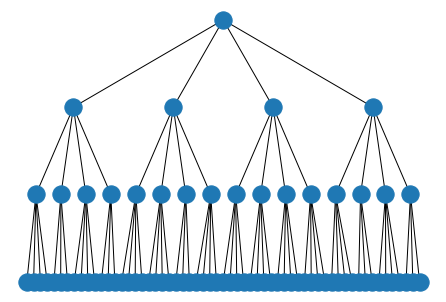

In [89]:
'''
## Visualization and Query
def hierarchy_pos(G, root, levels=None, width=1.5, height=.5):
    
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

pos = hierarchy_pos(G,root='*')    
nx.draw(G, pos=pos, with_labels=False)
#plt.savefig('hierarchy.png')
'''

In [127]:
### Generating output file ###

def readable_output(startpath,op_file):
    f = open(op_file,'w')
    for root, dirs, _ in os.walk(startpath):
        #print(dirs)
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        if not os.path.basename(root).startswith('.'):
            print('{}{}/'.format(indent, os.path.basename(root)))
            f.write('{}{}/'.format(indent, os.path.basename(root)))
            f.write('\n')
    f.close()

start_path = r'./autonto/data/drones/our-l3-0.15/'
output_file = r'./output/output.txt'
readable_output(start_path,output_file)

## Storing CSV output

dict_df = {'parent' : [], 'child':[]}
for p,c in G.edges():
    if p == '*':
        p = 'drone (ROOT)'
    dict_df['parent'].append(p)
    dict_df['child'].append(c)

op_df = pd.DataFrame(dict_df)
op_df.to_csv(r'./output/output.csv',index=None)

/
second_tti/
    first_second_layer/
    second_transmission_signal/
        second_antenna/
        second_transmission_line/
        second_transmission/
        first_transmission/
            first_power_transmission/
            second_transmission_line/
            first_transmission/
            second_transmission_signal/
            first_transmission_unit/
            first_transmission_path/
        threshold_level/
        first_frequency/
            first_radio_frequency/
            first_frequency_band/
            signal_second_frequency/
            first_frequency/
            signal_first_frequency/
            second_frequency/
        second_signal/
            first_control_signal/
            first_sequence/
            first_wireless_signal/
            second_reference_signal/
            second_audio_signal/
            second_signal/
        first_digital_signal/
        second_wireless_signal/
    second_light/
        second_optical_signal/
        second

            component_comprises/
        bulk_material/
            raw_material/
            fluorescent_material/
            phase_change_material/
            plastic_material/
            magnetic_material/
            property/
            luminescent_material/
            bulk_material/
    structure_low_cost/
        production_efficiency/
        small_size/
            large_scale/
            overall_arrangement/
            different_size/
            small_sized/
            light_weight/
            volume/
        high_cost/
        simple_easy_use/
            flexible/
            different_type/
            various_type/
            possible_provide/
            simple_easy_use/
            prior_art_advantage/
            many_advantage/
            beneficial_effect_lie/
        low_manufacturing_cost/
            display_device_manufacturing/
            manufacturing_process/
            additive_manufacturing/
            whole_process/
            manufacturing_